In [1]:
import math
import pickle

import numba
import typing as t
import numpy as np
import numpy.typing as npt
import pandas as pd
import astropy.constants as ac
import astropy.units as u
import matplotlib.pyplot as plt
from linelisttools.plot import get_vibrant_colors

from scipy.optimize import minimize, least_squares
from scipy.integrate import simpson

label_fontsize = 22
tick_fontsize = 18
line_width = 3

In [ ]:
# num_changes_flat = 3

n_layers = 10
n_lte_layers = 5
pop_grid = np.random.uniform(low=1e-6, high=1.0, size=(n_layers, 20))
# print(pop_grid)
pop_matrix = np.zeros((1, pop_grid.shape[0], pop_grid.shape[1]))
pop_matrix[0] = pop_grid

for n_iter in range(1, 20000):
    # new_pop_grid = np.random.uniform(low=1e-6, high=1.0, size=(1, pop_matrix.shape[1], pop_matrix.shape[2]))
    # new_pop_grid[0, n_lte_layers:, 9:] = 0
    # new_pop_grid[0, n_lte_layers:, 7] = 0
    new_pop_grid = np.random.uniform(low=1e-6, high=1.0, size=(pop_matrix.shape[1], pop_matrix.shape[2]))
    new_pop_grid[n_lte_layers:, 9:] = 0
    new_pop_grid[n_lte_layers:, 7] = 0

    pop_matrix = np.vstack((pop_matrix, new_pop_grid.reshape((1, pop_matrix.shape[1], pop_matrix.shape[2]))))

    max_pop_changes = np.empty(n_layers - n_lte_layers)

    for nlte_layer_idx in range(n_layers - n_lte_layers):
        layer_old_pops = pop_matrix[n_iter - 1, n_lte_layers + nlte_layer_idx]
        layer_new_pops = pop_matrix[n_iter, n_lte_layers + nlte_layer_idx]

        non_zero_idx_map = (layer_old_pops != 0) & (layer_new_pops != 0)
        layer_delta_pops = layer_new_pops[non_zero_idx_map] - layer_old_pops[non_zero_idx_map]
        layer_changes = np.abs(layer_delta_pops / layer_old_pops[non_zero_idx_map])
        max_pop_changes[nlte_layer_idx] = layer_changes.max()

    if max_pop_changes.max() < 3:
        print(f"All pop changes < 0.1, converged at I{n_iter}")
        break

# print(pop_change_matrix)

In [2]:
n_layers, n_angles, n_wavelengths = 10, 6, 15
source_function_matrix = np.random.rand(n_layers, n_wavelengths)
mu_values = np.random.rand(n_angles)
source_func_mu1 = source_function_matrix[:, None, :] / mu_values[None, :, None]
print(source_func_mu1.shape)

source_func_mu2 = source_function_matrix.reshape(n_layers, 1, n_wavelengths) / mu_values.reshape(1, n_angles, 1)
print(source_func_mu2.shape)
print(np.all(source_func_mu1 == source_func_mu2))

NameError: name 'np' is not defined

In [27]:
agg_col_nums = [9, 10]
agg_col_names = ["agg" + str(idx + 1) for idx in range(len(agg_col_nums))]
states = pd.read_csv(r"/mnt/c/PhD/OH/ExoMol/16O-1H__MYTHOS.states", sep=r"\s+",
                     names=["id", "energy", "g", "tau"] + agg_col_names,
                     usecols=[0, 1, 2, 5] + agg_col_nums)
agg_states = states.groupby(by=agg_col_names, as_index=False).agg(energy_agg=("energy", "min"))
agg_states = agg_states.sort_values(by="energy_agg")
n_agg_states = len(agg_states)
agg_states["id_agg"] = np.arange(0, n_agg_states, dtype=int)
# pop_matrix = np.zeros(len(n_agg_states))
ac_h_c_on_kB = ac.h * ac.c.cgs / ac.k_B
layer_temperature = 3000 * u.K
# print(agg_states)
states = states.merge(
    agg_states[["id_agg", "energy_agg"] + agg_col_names],
    on=agg_col_names,
    how="left",
)

states["q_lev"] = states["g"] * np.exp(
    -ac_h_c_on_kB * (states["energy"] << 1 / u.cm) / layer_temperature
)
states["n"] = states["q_lev"] / states["q_lev"].sum()
states_agg_n = states.groupby(by=["id_agg"], as_index=False).agg(n_agg=("n", "sum"))
pop_matrix = states_agg_n.sort_values(by="id_agg")["n_agg"]

pop_matrix = pop_matrix[:11]
pop_matrix = pop_matrix.to_numpy()
# pop_matrix /= pop_matrix.sum()
print(states)
print(pop_matrix)

          id         energy    g        tau      agg1  agg2  id_agg  \
0          1     126.292196    4  28.563000      X2Pi     0       0   
1          2    3695.355577    4   0.056453      X2Pi     1       1   
2          3    7098.826455    4   0.030017      X2Pi     2       2   
3          4   10338.617460    4   0.020636      X2Pi     3       3   
4          5   13415.819989    4   0.015441      X2Pi     4       4   
...      ...            ...  ...        ...       ...   ...     ...   
10601  10602  129966.983800  200   0.000006  C2Sigma+    68     121   
10602  10603  130496.166030  200   0.000006  C2Sigma+    69     122   
10603  10604  131033.183400  200   0.000006  C2Sigma+    70     123   
10604  10605  131577.969600  200   0.000006  C2Sigma+    71     124   
10605  10606  132130.462390  200   0.000006  C2Sigma+    72     125   

          energy_agg         q_lev             n  
0           0.000000  3.764916e+00  3.349139e-03  
1        3568.471362  6.797911e-01  6.047186e

In [ ]:
# rates = np.zeros(10)  # 1->0......10->9.

def test_rates(rates: npt.NDArray[np.float64], pop_matrix: npt.NDArray[np.float64], do_print: bool = False) -> float:
    y_matrix = np.zeros((pop_matrix.shape[0], pop_matrix.shape[0]))
    y_matrix += np.diag(rates, k=1)
    y_matrix -= np.diag(np.concatenate(([0], rates)))
    # print(y_matrix)
    y_matrix /= abs(y_matrix).sum(axis=1)[:, None]
    rhs = np.dot(y_matrix, pop_matrix)
    # print(rhs)
    if do_print:
        # print(y_matrix)
        print(rhs)

    # y_rect = np.vstack([y_matrix.copy(), np.ones(y_matrix.shape[1])])
    # rhs_rect = np.zeros(y_rect.shape[0])
    # rhs_rect[-1] = 1
    # rect_pops = np.linalg.pinv(y_rect) @ rhs_rect
    # print(f"rect pops = {rect_pops}, sum={sum(rect_pops)}")
    return sum(rhs**2)


x0 = np.zeros(10)
print("Initial rates:")
for v_val in range(1, len(x0) + 1):
    energy_u = agg_states.loc[agg_states["id_agg"] == v_val, "energy_agg"].values[0]
    energy_l = agg_states.loc[agg_states["id_agg"] == v_val - 1, "energy_agg"].values[0]
    print(f"v_val={v_val}, energy_u={energy_u}")
    energy_dif = energy_u - energy_l
    rate = np.exp(-(ac.h * energy_u * u.k * ac.c)/(ac.k_B * layer_temperature))
    x0[v_val - 1] = rate
x0 *= 1.60 / x0[0]
print(x0)

# test_rates(x0, pop_matrix)
bounds = ((1.6, 1.6), (1.697, 1.697), (0, 20), (0, 20), (0, 20), (0, 20), (0, 20), (0, 20), (0, 20), (0, 20))
res = minimize(test_rates, x0, args=pop_matrix, bounds=bounds)
print(res)
print(test_rates(res.x, pop_matrix, True))
rates = res.x * 1.60e-10 / res.x[0]
print("Fit rates:")
for v_val in range(1, len(x0) + 1):
    energy_u = agg_states.loc[agg_states["id_agg"] == v_val, "energy_agg"].values[0]
    energy_l = agg_states.loc[agg_states["id_agg"] == v_val - 1, "energy_agg"].values[0]
    energy_dif = energy_u - energy_l
    print(f"v_val = {v_val}, energy_u={energy_u}, rate = {rates[v_val - 1]}")
    plt.scatter(energy_u, rates[v_val - 1], label=f"{v_val}-{v_val -1}")
plt.legend()
plt.show()

In [ ]:
# rates = np.zeros(10)  # 1->0......10->9.

def test_rates(consts: npt.NDArray[np.float64], pop_matrix: npt.NDArray[np.float64], do_print: bool = False) -> float:
    a_const = consts[0]
    c_fi_rates = []
    c_if_rates = []
    for v_val in range(1, len(pop_matrix)):
        energy_u = agg_states.loc[agg_states["id_agg"] == v_val, "energy_agg"].values[0]
        energy_l = agg_states.loc[agg_states["id_agg"] == v_val - 1, "energy_agg"].values[0]
        energy_dif = energy_u - energy_l
        if v_val == 1:
            c_fi_rate = 1.6
        elif v_val == 2:
            c_fi_rate = 1.697
        else:
            c_fi_rate = a_const * np.exp(-(ac.h * energy_dif * u.k * ac.c)/(ac.k_B * layer_temperature))
            c_fi_rate = c_fi_rate.value
        c_fi_rates.append(c_fi_rate)
        # c_if_rate = c_fi_rate * pop_matrix[v_val] / pop_matrix[v_val - 1]
        c_if_rate = c_fi_rate * np.exp(-(ac.h * energy_dif * u.k * ac.c)/(ac.k_B * layer_temperature))
        c_if_rates.append(c_if_rate)

    c_fi_rates = np.concatenate(([0], c_fi_rates))
    c_if_rates = np.concatenate((c_if_rates, [0]))

    y_matrix = np.zeros((pop_matrix.shape[0], pop_matrix.shape[0]))
    y_matrix += np.diag(c_fi_rates[1:], k=1)
    y_matrix -= np.diag(c_fi_rates)
    y_matrix -= np.diag(c_if_rates)
    y_matrix += np.diag(c_if_rates[:-1], k=-1)
    # print(y_matrix)
    y_matrix /= abs(y_matrix).sum(axis=1)[:, None]
    # rhs = np.dot(y_matrix, pop_matrix)
    # print(rhs)

    y_rect = np.vstack([y_matrix.copy(), np.ones(y_matrix.shape[1])])
    rhs_rect = np.zeros(y_rect.shape[0])
    rhs_rect[-1] = 1
    rect_pops = np.linalg.pinv(y_rect) @ rhs_rect
    if do_print:
        # print(y_matrix)
        # print(rhs)
        print(f"rect pops = {rect_pops}, sum={sum(rect_pops)}")
    # error = sum(rhs**2)
    error = sum((rect_pops - pop_matrix)**2)
    return error

x0 = np.ones(1)
bounds = (0, 1e3)
# res = minimize(test_rates, x0, args=pop_matrix, bounds=bounds)
res = least_squares(
    test_rates,
    x0,
    args=(pop_matrix, False),
    bounds=bounds,
    method="trf",
    ftol=1e-15,
    gtol=1e-15,
    xtol=1e-15,
)

print(res)
print(test_rates(res.x, pop_matrix, True))
print(f"Pop matrix = {pop_matrix}")
#
# # rates = np.concatenate(([1.6, 1.697], rates))
fixed_rates = [1.6, 1.697]
rates = fixed_rates
plot_x = []
print("Fit rates:")
for v_val in range(1, len(pop_matrix)):
    energy_u = agg_states.loc[agg_states["id_agg"] == v_val, "energy_agg"].values[0]
    energy_l = agg_states.loc[agg_states["id_agg"] == v_val - 1, "energy_agg"].values[0]
    energy_dif = energy_u - energy_l
    if v_val >= 3:
        rate = res.x[0] * np.exp(-(ac.h * energy_dif * u.k * ac.c)/(ac.k_B * layer_temperature))
        rates.append(rate)
    plt.scatter(energy_dif, rates[v_val - 1], label=f"{v_val}-{v_val - 1}")
    print(f"v_val = {v_val}, energy_dif = {energy_dif}, rate = {rates[v_val - 1]}")
plt.legend()
plt.show()

In [ ]:
def test_rates(pop_matrix: npt.NDArray[np.float64], do_print: bool = False) -> float:
    c_fi_rates = [1.6, 1.697, 1.8, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4]
    c_if_rates = []
    for v_val in range(1, len(pop_matrix)):
        # c_if_rate = c_fi_rates[v_val - 1] * pop_matrix[v_val] / pop_matrix[v_val - 1]
        energy_u = agg_states.loc[agg_states["id_agg"] == v_val, "energy_agg"].values[0]
        energy_l = agg_states.loc[agg_states["id_agg"] == v_val - 1, "energy_agg"].values[0]
        energy_dif = energy_u - energy_l
        c_if_rate = c_fi_rates[v_val - 1] * np.exp(-(ac.h * energy_dif * u.k * ac.c)/(ac.k_B * layer_temperature))
        c_if_rates.append(c_if_rate)

    c_fi_rates = np.concatenate(([0], c_fi_rates))
    c_if_rates = np.concatenate((c_if_rates, [0]))

    y_matrix = np.zeros((pop_matrix.shape[0], pop_matrix.shape[0]))
    y_matrix += np.diag(c_fi_rates[1:], k=1)
    y_matrix -= np.diag(c_fi_rates)
    y_matrix -= np.diag(c_if_rates)
    y_matrix += np.diag(c_if_rates[:-1], k=-1)
    # print(y_matrix)
    y_matrix /= abs(y_matrix).sum(axis=1)[:, None]
    # rhs = np.dot(y_matrix, pop_matrix)
    # print(rhs)

    y_rect = np.vstack([y_matrix.copy(), np.ones(y_matrix.shape[1])])
    rhs_rect = np.zeros(y_rect.shape[0])
    rhs_rect[-1] = 1
    rect_pops = np.linalg.pinv(y_rect) @ rhs_rect
    if do_print:
        # print(y_matrix)
        # print(rhs)
        print(f"rect pops = {rect_pops}, sum={sum(rect_pops)}")
    # error = sum(rhs**2)
    error = sum((rect_pops - pop_matrix)**2)
    return error

print(test_rates(pop_matrix, True))

v_val = 1
Energy_dif = 3568.471362, rate = 1.6
v_val = 2
Energy_dif = 3402.874368, rate = 1.697
v_val = 3
Energy_dif = 3239.199221, rate = 1.8
v_val = 4
Energy_dif = 3076.6192740000006, rate = 1.9459664719441103
v_val = 5
Energy_dif = 2914.141809999999, rate = 2.103666329878406
v_val = 6
Energy_dif = 2750.550771, rate = 2.275360941140473
v_val = 7
Energy_dif = 2584.341703000002, rate = 2.464160750567081
v_val = 8
Energy_dif = 2413.620096999999, rate = 2.6744080058250446
v_val = 9
Energy_dif = 2235.970032000001, rate = 2.912254872958745
v_val = 10
Energy_dif = 2048.281117999999, rate = 3.186559499931827


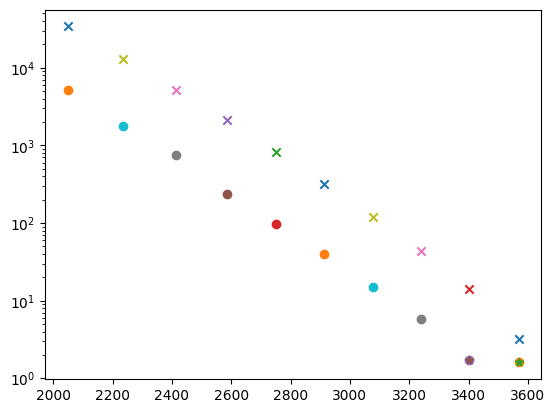

In [13]:
col_rates = np.array([1.6, 1.697, 0.4230149322599787, 0.4573182640609042, 0.49437903890617324, 0.5347286968797437,
                          0.5790982183215734, 0.6285080674553478, 0.6844040543380203, 0.7488679172255852])
col_rates_rel = col_rates[2:]
col_rates_rel = 1.8 *col_rates_rel / col_rates_rel[0]
col_rates_fit = np.concatenate([col_rates[:2], col_rates_rel])

he_rates = [3.2e-17, 1.4e-16, 4.4e-16, 1.2e-15, 3.2e-15, 8.2e-15, 2.1e-14, 5.1e-14, 1.3e-13, 3.4e-13]
# h_rates = [1.6e-10, 1.697e-10, 4.0e-10, 1.0e-9, 3.0e-9, 6.0e-9, 1.0e-8, 3.0e-8, 8.0e-8, 1.2e-7]
h_rates = [1.6e-10, 1.697e-10, 5.8e-10, 1.5e-9, 4.0e-9, 9.8e-9, 2.4e-8, 7.6e-8, 1.8e-7, 5.1e-7]

for v_val in range(1, len(col_rates_fit) + 1):
    print(f"v_val = {v_val}")
    energy_u = agg_states.loc[agg_states["id_agg"] == v_val, "energy_agg"].values[0]
    energy_l = agg_states.loc[agg_states["id_agg"] == v_val - 1, "energy_agg"].values[0]
    energy_dif = energy_u - energy_l
    print(f"Energy_dif = {energy_dif}, rate = {col_rates_fit[v_val - 1]}")
    # plt.scatter(energy_dif, col_rates_fit[v_val - 1], marker="x")
    plt.scatter(energy_dif, he_rates[v_val - 1] / 1e-17, marker="x")
    plt.scatter(energy_dif, h_rates[v_val - 1] / 1e-10, marker="o")
    if v_val <= 2:
        plt.scatter(energy_dif, col_rates[v_val -1], marker="*")
plt.yscale("log")
plt.show()

In [5]:
# a_const = -6.9
# b_const = 0.00459
rate_targets = [1.6e-10, 1.697e-10]


def get_rate(v_val, a_const, b_const):
    energy_upper = agg_states.loc[
                (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] == v_val), "energy_agg"
    ].values[0]
    energy_lower = agg_states.loc[
        (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] == v_val - 1), "energy_agg"
    ].values[0]
    energy_dif = energy_upper - energy_lower
    rate = v_val * np.exp(a_const - b_const * energy_dif)
    return rate

def fit_rates(params):
    a_const = params[0]
    b_const = params[1]
    errors = []
    for v_val in range(1, 3):
        rate = get_rate(v_val, a_const, b_const)
        print(f"H rate (v={v_val}-{v_val - 1}) = {rate}")
        # print(f'add_col_chem_rate("X2Pi", {v_val}, "X2Pi", {v_val - 1}, {rate:.1e}, "H")  # @ 298 K')
        errors.append(rate - rate_targets[v_val - 1])
    errors = np.array(errors)
    return sum((1e18*errors)**2)

x0 = [-6.90, 0.004743]
bounds = ((-10, -3), (0, 1e-1))
# res = minimize(fit_rates, x0,
#                method="trf",
#     ftol=1e-15,
#     gtol=1e-15,
#     xtol=1e-15,
# )
res = least_squares(
    fit_rates,
    x0,
    # args=(pop_matrix, False),
    bounds=bounds,
    method="trf",
    ftol=1e-15,
    gtol=1e-15,
    xtol=1e-15,
)
print(res)
h_rates = []
for v_val in range(1, 11):
    rate = get_rate(v_val, res.x[0], res.x[1])
    print(f"H rate (v={v_val}-{v_val - 1}) = {rate}")
    h_rates.append(rate)
h_rates = np.array(h_rates)

H rate (v=1-0) = 4.495947129046362e-11
H rate (v=2-1) = 1.9722301988737758e-10
H rate (v=1-0) = 4.495946666782049e-11
H rate (v=2-1) = 1.9722299960929945e-10
H rate (v=1-0) = 4.495708066259851e-11
H rate (v=2-1) = 1.9721301959674262e-10
H rate (v=1-0) = 7.604050964009239e-66
H rate (v=2-1) = 1.052785848900733e-62
H rate (v=1-0) = 2.854555381058885e-122
H rate (v=2-1) = 1.7825571677344642e-116
H rate (v=1-0) = 1.4434414362028277e-46
H rate (v=2-1) = 2.8065496573386675e-44
H rate (v=1-0) = 5.4190010274434354e-20
H rate (v=2-1) = 6.1638265062780055e-19
H rate (v=1-0) = 2.6377497110637633e-13
H rate (v=2-1) = 1.4686087941225237e-12
H rate (v=1-0) = 1.2439939979144964e-11
H rate (v=2-1) = 5.79220209544349e-11
H rate (v=1-0) = 3.260723630879708e-11
H rate (v=2-1) = 1.4518540395839165e-10
H rate (v=1-0) = 4.149005320491739e-11
H rate (v=2-1) = 1.8268317839667945e-10
H rate (v=1-0) = 4.406582134606509e-11
H rate (v=2-1) = 1.934830029165454e-10
H rate (v=1-0) = 4.473437379525072e-11
H rate (v=2

In [6]:
# a_const = -6.9
# b_const = 0.00459
rate_targets = [1.6e-10, 0.654e-10, 1.043e-10]


def get_rate(v_u, v_l, a_const, b_const):
    energy_upper = agg_states.loc[
                (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] == v_u), "energy_agg"
    ].values[0]
    energy_lower = agg_states.loc[
        (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] == v_l), "energy_agg"
    ].values[0]
    energy_dif = energy_upper - energy_lower
    rate = v_u * np.exp(a_const - b_const * energy_dif)
    return rate

def fit_rates(params):
    a_const = params[0]
    b_const = params[1]
    errors = []
    rate_v_pairs = [(1, 0), (2, 1), (2, 0)]
    for idx, v_pair in enumerate(rate_v_pairs):
        rate = get_rate(v_pair[0], v_pair[1], a_const, b_const)
        print(f"H rate (v={v_pair[0]}-{v_pair[1]}) = {rate}")
        # print(f'add_col_chem_rate("X2Pi", {v_val}, "X2Pi", {v_val - 1}, {rate:.1e}, "H")  # @ 298 K')
        errors.append(rate - rate_targets[idx])
    errors = np.array(errors)
    return sum(errors**2)

x0 = [-6.9, 0.00459]
bounds = ((-10, -4), (0, 1e-2))
# res = minimize(fit_rates, x0,
#                method="trf",
#     ftol=1e-15,
#     gtol=1e-15,
#     xtol=1e-15,
# )
res = least_squares(
    fit_rates,
    x0,
    # args=(pop_matrix, False),
    bounds=bounds,
    method="trf",
    ftol=1e-15,
    gtol=1e-15,
    xtol=1e-15,
)
print(res)
h_rates = []
for v_val in range(1, 11):
    rate = get_rate(v_val, v_val -1, res.x[0], res.x[1])
    print(f"H rate (v={v_val}-{v_val - 1}) = {rate}")
    h_rates.append(rate)
h_rates = np.array(h_rates)

H rate (v=1-0) = 7.761320376676128e-11
H rate (v=2-1) = 3.31946877096583e-10
H rate (v=2-0) = 2.556443055161197e-17
H rate (v=1-0) = 7.761319578672625e-11
H rate (v=2-1) = 3.3194684296646744e-10
H rate (v=2-0) = 2.556442792312832e-17
H rate (v=1-0) = 7.760907684350575e-11
H rate (v=2-1) = 3.319300455662272e-10
H rate (v=2-0) = 2.5561775027189568e-17
     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [ 8.871e-20]
           x: [-6.900e+00  4.590e-03]
        cost: 3.935025379586206e-39
         jac: [[ 1.642e-19 -5.565e-16]]
        grad: [ 1.456e-38 -4.937e-35]
  optimality: 2.670853592717787e-37
 active_mask: [0 0]
        nfev: 1
        njev: 1
H rate (v=1-0) = 7.761320376676128e-11
H rate (v=2-1) = 3.31946877096583e-10
H rate (v=3-2) = 1.0554357356416985e-09
H rate (v=4-3) = 2.9679685545068373e-09
H rate (v=5-4) = 7.820846849590695e-09
H rate (v=6-5) = 1.988562814972554e-08
H rate (v=7-6) = 4.975184603919781e-08
H rate (v=8-7) 

In [75]:
# a_const = -6.9
# b_const = 0.00459
temperature_list = np.array([50, 100, 300])
# rate_targets = [[2.013, 0.842, 1.259], [1.915, 0.788, 1.209], [1.600, 0.654, 1.043]]
rate_targets = [[2.013, 2.101], [1.915, 1.997], [1.600, 1.697]]
rate_targets = np.array(rate_targets)  * 1e-10
# rate_v_pairs = [(1, 0), (2, 1), (2, 0)]
rate_v_pairs = [(1, 0), (2, 1)]


def get_rate(v_u, v_l, temperature, a_const, b_const):
    energy_upper = agg_states.loc[
                (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] == v_u), "energy_agg"
    ].values[0]
    energy_lower = agg_states.loc[
        (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] == v_l), "energy_agg"
    ].values[0]
    energy_dif = energy_upper - energy_lower
    # print(f"v={v_u}-{v_l}, energy_dif = {energy_dif}")
    # print(np.exp(a_const * -(ac.h * ac.c.cgs * energy_dif * u.k) / (ac.k_B * temperature * u.K)))
    # rate = b_const * np.exp(a_const * -(ac.h * ac.c.cgs * energy_dif * u.k) / (ac.k_B * temperature * u.K))
    rate = a_const * energy_dif**b_const / temperature
    return rate

def fit_rates(params):
    a_const = params[0]
    b_const = params[1]
    rates = np.zeros((3, 2))
    for temp_idx, temperature in enumerate(temperature_list):
        for idx, v_pair in enumerate(rate_v_pairs):
            rate = get_rate(v_pair[0], v_pair[1], temperature, a_const, b_const)
            print(f"H k(T={temperature}, v={v_pair[0]}-{v_pair[1]}) = {rate}")
            rates[temp_idx, idx] = rate
    print(f"Rates = {rates}")
    error = 1e10*(rates - rate_targets)
    error *= (np.log10(rates) - np.log10(rate_targets))
    return sum(error**2)

# x0 = [1, 0.1]
x0 = [1, 1]
bounds = ((0, np.inf))
# res = minimize(fit_rates, x0,
#                method="trf",
#     ftol=1e-15,
#     gtol=1e-15,
#     xtol=1e-15,
# )
res = least_squares(
    fit_rates,
    x0,
    # args=(pop_matrix, False),
    bounds=bounds,
    method="trf",
    ftol=1e-15,
    gtol=1e-15,
    xtol=1e-15,
)
print(res)
rates = np.zeros((3, 3))
for temp_idx, temperature in enumerate(temperature_list):
    for v_val in range(1, 4):
        # rate = get_rate(v_val, v_val -1, temperature, res.x[0], res.x[1])
        rate = get_rate(v_val, v_val -1, temperature, res.x[0], res.x[1])
        print(f"H k(T={temperature},v={v_val}-{v_val - 1}) = {rate}")
        rates[temp_idx, v_val - 1] = rate
print(rates)

H k(T=50, v=1-0) = 71.36942724000001
H k(T=50, v=2-1) = 68.05748736
H k(T=100, v=1-0) = 35.684713620000004
H k(T=100, v=2-1) = 34.02874368
H k(T=300, v=1-0) = 11.89490454
H k(T=300, v=2-1) = 11.342914559999999
Rates = [[71.36942724 68.05748736]
 [35.68471362 34.02874368]
 [11.89490454 11.34291456]]
H k(T=50, v=1-0) = 71.36942830348735
H k(T=50, v=2-1) = 68.05748837413559
H k(T=100, v=1-0) = 35.68471415174368
H k(T=100, v=2-1) = 34.028744187067794
H k(T=300, v=1-0) = 11.894904717247892
H k(T=300, v=2-1) = 11.342914729022597
Rates = [[71.3694283  68.05748837]
 [35.68471415 34.02874419]
 [11.89490472 11.34291473]]
H k(T=50, v=1-0) = 71.36943593921275
H k(T=50, v=2-1) = 68.05749560733217
H k(T=100, v=1-0) = 35.684717969606375
H k(T=100, v=2-1) = 34.028747803666086
H k(T=300, v=1-0) = 11.894905989868791
H k(T=300, v=2-1) = 11.342915934555363
Rates = [[71.36943594 68.05749561]
 [35.68471797 34.0287478 ]
 [11.89490599 11.34291593]]
H k(T=50, v=1-0) = 45.052905853097045
H k(T=50, v=2-1) = 43.0

In [69]:
temperature = 300
a_const = 5.687840149822691e-10
b_const = 0.07411
rate_1_0 = a_const * np.exp(b_const * -(ac.h * ac.c.cgs * 3568.471362 * u.k) / (ac.k_B * temperature * u.K))
rate_2_1 = a_const * np.exp(b_const * -(ac.h * ac.c.cgs * 3402.874368 * u.k) / (ac.k_B * temperature * u.K))
print(rate_1_0, rate_2_1)
print(rate_2_1 / rate_1_0)

temperature = 100
rate_1_0 = a_const * np.exp(b_const * -(ac.h * ac.c.cgs * 3568.471362 * u.k) / (ac.k_B * temperature * u.K))
rate_2_1 = a_const * np.exp(b_const * -(ac.h * ac.c.cgs * 3402.874368 * u.k) / (ac.k_B * temperature * u.K))
print(rate_1_0, rate_2_1)
print(rate_2_1 / rate_1_0)

1.6e-10 1.696998464228983e-10
1.0606240401431144
1.2660917616220564e-11 1.5106003561612674e-11
1.1931207531324257


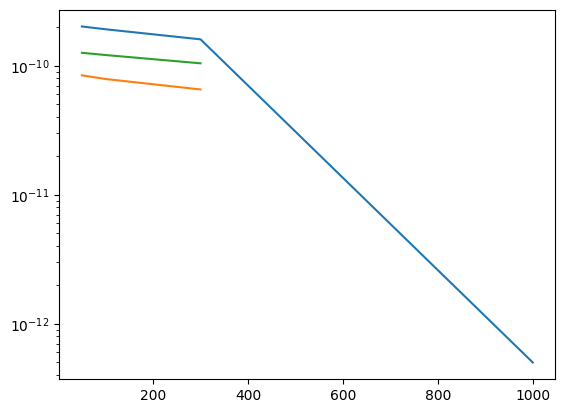

In [80]:
plot_rates_1_0 = [2.013e-10, 1.915e-10, 1.600e-10, 5e-13]
plot_temps_1_0 = [50, 100, 300, 1000]
plot_rates_2_1 = [0.842e-10, 0.788e-10, 0.654e-10]
plot_temps_2_1 = [50, 100, 300]
plot_rates_2_0 = [1.259e-10, 1.209e-10, 1.043e-10]
plot_temps_2_0 = [50, 100, 300]
plt.plot(plot_temps_1_0, plot_rates_1_0)
plt.plot(plot_temps_2_1, plot_rates_2_1)
plt.plot(plot_temps_2_0, plot_rates_2_0)
plt.yscale("log")
plt.show()

In [29]:
# v_u_list = np.arange(4, 10)
# rate_targets = np.array([1.834, 3.914, 6.845, 8.042, 7.597, 5.827]) * 1e-13
#
# # a_const = -6.9
# # b_const = 0.00459
# # rate_targets = [1.6e-10, 1.697e-10]
#
# def get_rate(v_val, a_const, b_const):
#     energy_upper = agg_states.loc[
#                 (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] == v_val), "energy_agg"
#     ].values[0]
#     energy_lower = agg_states.loc[
#         (agg_states["agg1"] == "X2Pi") & (agg_states["agg2"] == v_val - 1), "energy_agg"
#     ].values[0]
#     energy_dif = energy_upper - energy_lower
#     rate = v_val * np.exp(a_const - b_const * energy_dif)
#     return rate
#
# def fit_rates(params):
#     a_const = params[0]
#     b_const = params[1]
#     errors = []
#     for v_val in range(4, 10):
#         rate = get_rate(v_val, a_const, b_const)
#         print(f"H rate (v={v_val}-{v_val - 1}) = {rate}")
#         # print(f'add_col_chem_rate("X2Pi", {v_val}, "X2Pi", {v_val - 1}, {rate:.1e}, "H")  # @ 298 K')
#         errors.append(rate - rate_targets[v_val - 4])
#     errors = np.array(errors)
#     return sum((1e18*errors)**2)
#
# x0 = [-6.90, 0.004743]
# bounds = ((-10, -3), (0, 1e-1))
# # res = minimize(fit_rates, x0,
# #                method="trf",
# #     ftol=1e-15,
# #     gtol=1e-15,
# #     xtol=1e-15,
# # )
# res = least_squares(
#     fit_rates,
#     x0,
#     # args=(pop_matrix, False),
#     bounds=bounds,
#     method="trf",
#     ftol=1e-15,
#     gtol=1e-15,
#     xtol=1e-15,
# )
# print(res)
# h2_rates = []
# for v_val in range(1, 11):
#     rate = get_rate(v_val, res.x[0], res.x[1])
#     print(f"H rate (v={v_val}-{v_val - 1}) = {rate}")
#     h2_rates.append(rate)
# h2_rates = np.array(h2_rates)
#
#
# # plt.plot(v_u_list, h2_rates)
# # plt.yscale("log")
# # plt.show()

H rate (v=4-3) = 1.8536468732214047e-09
H rate (v=5-4) = 5.007461722779639e-09
H rate (v=6-5) = 1.3054892912498422e-08
H rate (v=7-6) = 3.350327813007637e-08
H rate (v=8-7) = 8.604817024345144e-08
H rate (v=9-8) = 2.248165086788434e-07
H rate (v=4-3) = 1.853646682633125e-09
H rate (v=5-4) = 5.007461207922397e-09
H rate (v=6-5) = 1.3054891570220378e-08
H rate (v=7-6) = 3.350327468533616e-08
H rate (v=8-7) = 8.604816139615025e-08
H rate (v=9-8) = 2.2481648556365774e-07
H rate (v=4-3) = 1.8535618943582131e-09
H rate (v=5-4) = 5.0072442829979054e-09
H rate (v=6-5) = 1.305435785039545e-08
H rate (v=7-6) = 3.3501987953986994e-08
H rate (v=8-7) = 8.604507551280261e-08
H rate (v=9-8) = 2.2480901824357308e-07
H rate (v=4-3) = 2.6172944358471436e-19
H rate (v=5-4) = 3.371974552653933e-18
H rate (v=6-5) = 4.2377065553114245e-17
H rate (v=7-6) = 5.376103611384854e-16
H rate (v=8-7) = 7.128321625752722e-15
H rate (v=9-8) = 1.0277077842307394e-13
H rate (v=4-3) = 2.6172943968464175e-19
H rate (v=5-4

/tmp/ipykernel_22368/4163947773.py:16: RuntimeWarning: overflow encountered in exp
  rate = v_val * np.exp(a_const - b_const * energy_dif)


H rate (v=7-6) = 4.541424631355076e-15
H rate (v=8-7) = 5.229886787634611e-14
H rate (v=9-8) = 6.511344510484852e-13
H rate (v=4-3) = 3.319295422871341e-18
H rate (v=5-4) = 3.739534169558634e-17
H rate (v=6-5) = 4.1058652428578005e-16
H rate (v=7-6) = 4.540914026007605e-15
H rate (v=8-7) = 5.229337807884235e-14
H rate (v=9-8) = 6.51071158407281e-13
H rate (v=4-3) = 3.3192953734099852e-18
H rate (v=5-4) = 3.739534113835233e-17
H rate (v=6-5) = 4.1058651816756414e-16
H rate (v=7-6) = 4.540913958342714e-15
H rate (v=8-7) = 5.22933772996103e-14
H rate (v=9-8) = 6.510711487055648e-13
H rate (v=4-3) = 3.3191432525978615e-18
H rate (v=5-4) = 3.739371787190354e-17
H rate (v=6-5) = 4.105696961669584e-16
H rate (v=7-6) = 4.5407391601727265e-15
H rate (v=8-7) = 5.229149734251258e-14
H rate (v=9-8) = 6.51049466021799e-13
H rate (v=4-3) = 3.319188072361829e-18
H rate (v=5-4) = 3.739419585919962e-17
H rate (v=6-5) = 4.105746463066794e-16
H rate (v=7-6) = 4.540790558372095e-15
H rate (v=8-7) = 5.2292

In [19]:

profiles = pd.read_csv(
    r"/mnt/c/PhD/programs/charlesrex/tests/inputs/KELT20_PT_abunds_med.dat",
    header=0,
    names=["logP", "T", "logCO", "logH2O", "logOH", "logFe"],
)

central_pressure = 10 ** profiles["logP"].to_numpy()[::-1] << u.bar
pressure_levels = (
    np.loadtxt(r"/mnt/c/PhD/programs/charlesrex/tests/inputs/KELT20_PT_abunds_maxl_fit_pressure_levels.txt") << u.bar
)
temperature_profile = profiles["T"].to_numpy()[::-1] << u.K

co_mmr = 10 ** profiles["logCO"].to_numpy()[::-1]
h2o_mmr = 10 ** profiles["logH2O"].to_numpy()[::-1]
oh_mmr = 10 ** profiles["logOH"].to_numpy()[::-1]
oh_scale_factor = 1
oh_mmr *= oh_scale_factor
fe_mmr = 10 ** profiles["logFe"].to_numpy()[::-1]

mass_h = 1.00782503223
mass_h2 = 2 * mass_h
mass_he = 4.00260325413
mass_o = 15.99491461957
mass_co = 12 + mass_o
mass_h2o = 2*mass_h + mass_o
mass_oh = mass_o + mass_h
mass_fe = 55.93493632600

# co_o_mass_frac = mass_o / mass_co
# h2o_o_mass_frac = mass_o / mass_h2o
# oh_o_mass_frac = mass_o / mass_oh
#
# total_o_mmr = (co_mmr[0] * co_o_mass_frac) + (h2o_mmr[0] * h2o_o_mass_frac)
# print(total_o_mmr)
# o_mmr = np.repeat(total_o_mmr, len(profiles)) - (co_mmr * co_o_mass_frac) - (h2o_mmr * h2o_o_mass_frac)
# print(o_mmr)

h_mmr = 10 ** (-0.2) # Median
total_h_mmr = np.repeat(h_mmr, len(profiles))
h2_dissociation_pressure = 10**-1.6 << u.bar
h2_mmr = np.where(
    central_pressure > h2_dissociation_pressure,
    total_h_mmr,
    total_h_mmr * (central_pressure / h2_dissociation_pressure)**4,
)
h_mmr = total_h_mmr - h2_mmr

he_mmr = np.ones_like(h_mmr) - h2_mmr - h_mmr - co_mmr - h2o_mmr - oh_mmr - fe_mmr

h2_rmmr = h2_mmr / mass_h2
h_rmmr = h_mmr / mass_h
he_rmmr = he_mmr / mass_he
# o_rmmr = o_mmr / mass_o
co_rmmr = co_mmr / mass_co
h2o_rmmr = h2o_mmr / mass_h2o
oh_rmmr = oh_mmr / mass_oh
fe_rmmr = fe_mmr / mass_fe

sum_mmr_m = sum([h2_mmr, h_rmmr, he_rmmr, co_rmmr, h2o_rmmr, oh_rmmr, fe_rmmr])

h2_vmr = h2_rmmr / sum_mmr_m
h_vmr = h_rmmr / sum_mmr_m
he_vmr = he_rmmr / sum_mmr_m
# o_vmr = o_rmmr / sum_mmr_m
co_vmr = co_rmmr / sum_mmr_m
h2o_vmr = h2o_rmmr / sum_mmr_m
oh_vmr = oh_rmmr / sum_mmr_m
fe_vmr = fe_rmmr / sum_mmr_m

profiles_maxl = pd.read_csv(
    r"/mnt/c/PhD/programs/charlesrex/tests/inputs/KELT20_PT_abunds_maxl.dat",
    header=0,
    names=["logP", "T", "logCO", "logH2O", "logOH", "logFe"],
)
temperature_profile_maxl = profiles_maxl["T"].to_numpy()[::-1] << u.K

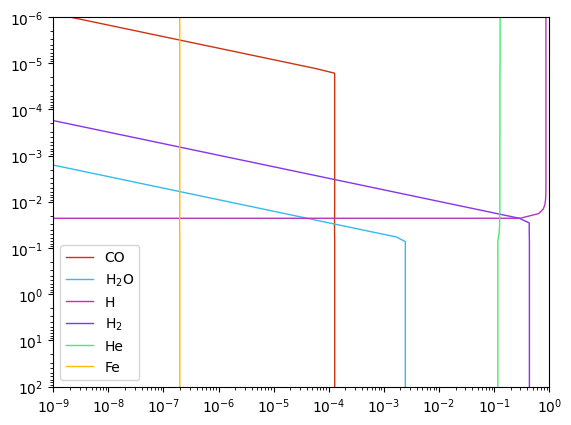

In [26]:
line_width = 1
plt.plot(co_vmr, central_pressure, label="CO", color="#CC3311", linewidth=line_width)
plt.plot(h2o_vmr, central_pressure, label="H$_{2}$O", color="#33BBEE", linewidth=line_width)
plt.plot(h_vmr, central_pressure, label="H", color="#BB33BB", linewidth=line_width)
plt.plot(h2_vmr, central_pressure, label="H$_{2}$", color="#8833EE", linewidth=line_width)
plt.plot(he_vmr, central_pressure, label="He", color="#44EE66", linewidth=line_width)
plt.plot(fe_vmr, central_pressure, label="Fe", color="#FFBB00", linewidth=line_width)


plt.xlim(left=1e-9, right=1)
plt.ylim(bottom=central_pressure[-1].value, top=central_pressure[0].value)
plt.gca().invert_yaxis()
plt.yscale("log")
plt.xscale("log")
plt.legend(loc="best")
plt.show()

In [18]:
mu_values, mu_weights = np.polynomial.legendre.leggauss(50)
mu_values, mu_weights = (mu_values + 1) * 0.5, mu_weights / 2
n_layers = 20
n_wn = 30
global_xsec_matrix = np.random.rand(n_layers, n_wn) << u.cm**2
dz_profile = np.random.rand(n_layers) << u.m
res = global_xsec_matrix * dz_profile[:, None]
dtau = res.decompose().value
tau = dtau[::-1].cumsum(axis=0)[::-1]
inv_mu = 1 / mu_values
layer_tau = tau - dtau
emission_tau = np.exp(-layer_tau) - np.exp(-tau)
source_func = np.random.rand(n_layers, n_wn) << u.J / (u.sr * u.m**2)
intensity = (
        np.exp(-inv_mu[:, None, None] * layer_tau[None, ...])
        - np.exp(-inv_mu[:, None, None] * tau[None, ...])
) * source_func[None, ...]
print(intensity.shape)
print(mu_values.shape)
# print(intensity * mu_values[:, None, None])
intensity = 2 * np.pi * (intensity * mu_values[:, None, None,] * mu_weights[:, None, None]).sum(axis=0) * u.sr
print(intensity.shape)

(50, 20, 30)
(50,)
(20, 30)


In [48]:
n_angular_points = 20
mu_values, mu_weights = np.polynomial.legendre.leggauss(n_angular_points)
mu_values, mu_weights = (mu_values + 1) * 0.5, mu_weights / 2

source_func = np.random.rand(n_layers, n_wn)

n_layers = 5
n_wn = 6
dtau = np.random.rand(n_layers, n_wn)
tau = dtau[::-1].cumsum(axis=0)[::-1]
# tau_mu = tau[:, None, :] / mu_values[None, :, None]
# print(tau_mu.shape)

inv_mu = 1 / mu_values
layer_tau = tau - dtau

intensity_out = (
                        np.exp(-inv_mu[:, None, None] * layer_tau[None, ...])
                        - np.exp(-inv_mu[:, None, None] * tau[None, ...])
) * source_func[None, ...]
intensity_out = (
        2 * np.pi * u.sr *
        (intensity_out * mu_values[:, None, None,] * mu_weights[:, None, None]).sum(axis=0)
)
print(intensity_out)
# print(f"Tau = {tau}")
# print(f"Layer tau = {layer_tau}")

intensity_in = (
    np.exp(-inv_mu[:, None, None] * tau[None, ...])
    - np.exp(-inv_mu[:, None, None] * layer_tau[None, ...])
) * source_func[None, ...]
intensity_in = (
        2 * np.pi * u.sr *
        (intensity_in * -mu_values[:, None, None,] * mu_weights[:, None, None]).sum(axis=0)
)
print(intensity_in)

# i_in_matrix = np.random.rand(*tau_mu.shape)
# i_out_matrix = np.random.rand(*tau_mu.shape)
#
# i_grid = 0.5 * np.sum(
#     (i_in_matrix + i_out_matrix) * mu_weights[:, None],
#     axis=1,
# )
# print(i_grid.shape)
# i_grid

[[4.74950999e-02 7.30656485e-02 3.10522119e-02 1.15135600e-02
  8.11856710e-03 3.94585819e-02]
 [4.37631947e-02 2.42183874e-02 4.72048127e-02 1.38533521e-01
  1.48734134e-04 1.33712033e-01]
 [2.82390955e-02 1.16419569e-03 2.79267422e-01 1.47986112e-01
  2.07704490e-01 5.81794671e-02]
 [8.39513336e-01 6.66275033e-01 7.43622023e-01 3.34047487e-01
  7.73753778e-02 8.63789960e-02]
 [4.84721376e-01 3.81060744e-01 7.63083781e-01 1.42692734e+00
  2.15621996e+00 6.63724533e-01]] sr
[[4.74950999e-02 7.30656485e-02 3.10522119e-02 1.15135600e-02
  8.11856710e-03 3.94585819e-02]
 [4.37631947e-02 2.42183874e-02 4.72048127e-02 1.38533521e-01
  1.48734134e-04 1.33712033e-01]
 [2.82390955e-02 1.16419569e-03 2.79267422e-01 1.47986112e-01
  2.07704490e-01 5.81794671e-02]
 [8.39513336e-01 6.66275033e-01 7.43622023e-01 3.34047487e-01
  7.73753778e-02 8.63789960e-02]
 [4.84721376e-01 3.81060744e-01 7.63083781e-01 1.42692734e+00
  2.15621996e+00 6.63724533e-01]] sr


# Ray Geormetry

0.6
A/H = 0.9333333333333332
O/H = 0.35901098714230056
0.7
A/H = 0.7999999999999999
O/H = 0.6000000000000001
0.8
A/H = 0.6999999999999998
O/H = 0.7141428428542852
0.9
A/H = 0.6222222222222221
O/H = 0.7828406646137127
1.0
A/H = 0.5599999999999999
O/H = 0.8284926070883192


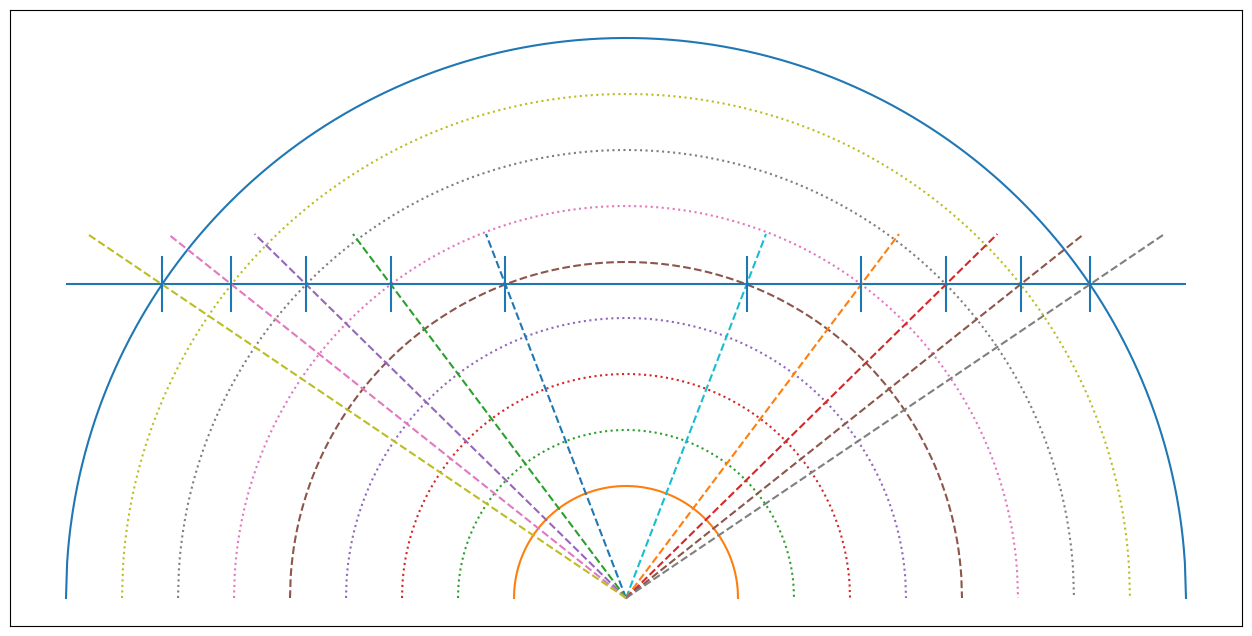

In [39]:
n_angular_points = 50
mu_values, mu_weights = np.polynomial.legendre.leggauss(n_angular_points)
mu_values, mu_weights = (mu_values + 1) * 0.5, mu_weights / 2

outer_radius = 1.0
shell_x = np.linspace(-outer_radius, outer_radius, 1000)
shell_y = np.sin(np.acos(shell_x / outer_radius)) * outer_radius

surface_radius = 0.2
surface_x = np.linspace(-surface_radius, surface_radius, 1000)
surface_y = np.sin(np.acos(surface_x / surface_radius)) * surface_radius

plt.figure(figsize=(16, 8))

plt.plot(shell_x, shell_y)
plt.plot(surface_x, surface_y)
intersect_radius = 0.6
layer_step_size = 0.1
for layer_radius in np.arange(surface_radius + layer_step_size, outer_radius, layer_step_size):
    layer_x = np.linspace(-layer_radius, layer_radius, 1000)
    layer_y = np.sin(np.acos(layer_x / layer_radius)) * layer_radius
    plt.plot(layer_x, layer_y, linestyle="--" if layer_radius == intersect_radius else ":")

intersect_height = intersect_radius - 0.4 * layer_step_size
plt.hlines(y=intersect_height, xmin=-outer_radius, xmax=outer_radius)

for intersect_layer_radius in np.linspace(intersect_radius, outer_radius, int((outer_radius - intersect_radius) / layer_step_size) + 1):
    print(intersect_layer_radius)
    intersect_plus_x_point = np.cos(np.asin(intersect_height / intersect_layer_radius)) * intersect_layer_radius
    print(f"A/H = {intersect_height/intersect_layer_radius}")
    print(f"O/H = {intersect_plus_x_point/intersect_layer_radius}")
    intersect_y = np.linspace(0, intersect_radius + layer_step_size / 2, 100)
    intersect_x = intersect_y * intersect_plus_x_point / intersect_height
    plt.plot(intersect_x, intersect_y, "--")
    vline_len = layer_step_size / 2
    plt.vlines(intersect_plus_x_point, ymin=intersect_height - vline_len, ymax=intersect_height + vline_len)
    plt.plot(-intersect_x, intersect_y, "--")
    plt.vlines(-intersect_plus_x_point, ymin=intersect_height - vline_len, ymax=intersect_height + vline_len)

plt.tick_params(axis="both", which="both", labelleft=False, labelbottom=False, left=False, bottom=False)

plt.gca().set_aspect('equal')
plt.show()

0.5729840746221627
0.4021060186435709 0.4021060186435709


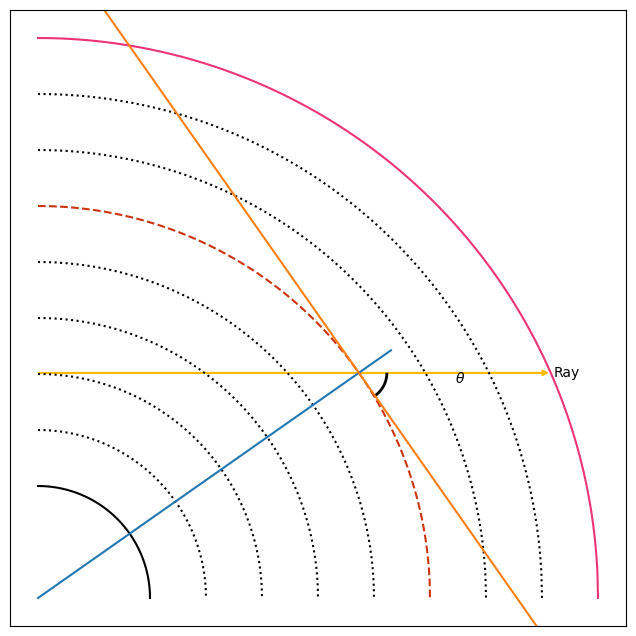

In [145]:
n_angular_points = 10
mu_values, mu_weights = np.polynomial.legendre.leggauss(n_angular_points)
mu_values, mu_weights = (mu_values + 1) * 0.5, mu_weights / 2

outer_radius = 1.0
shell_x = np.linspace(0, outer_radius, 1000)
shell_y = np.sin(np.acos(shell_x / outer_radius)) * outer_radius

surface_radius = 0.2
surface_x = np.linspace(0, surface_radius, 1000)
surface_y = np.sin(np.acos(surface_x / surface_radius)) * surface_radius

plt.figure(figsize=(8, 8))

plt.plot(shell_x, shell_y, color="#EE3377")
plt.plot(surface_x, surface_y, color="#000000")
intersect_radius = 0.7
layer_step_size = 0.1
for layer_radius in np.arange(surface_radius + layer_step_size, outer_radius, layer_step_size):
    layer_x = np.linspace(0, layer_radius, 1000)
    layer_y = np.sin(np.acos(layer_x / layer_radius)) * layer_radius
    if layer_radius == intersect_radius:
        plt.plot(layer_x, layer_y, linestyle="--", color="#CC3311")
    else:
        plt.plot(layer_x, layer_y, linestyle=":", color="#000000")

from matplotlib.patches import Arc

# plt.scatter(np.sin(np.acos(mu_values)) * intersect_radius, mu_values * intersect_radius)
select_mu = 5
for mu_value in mu_values[select_mu:select_mu+1]:
    intersect_x_point = np.sin(np.acos(mu_value)) * intersect_radius
    print(intersect_x_point)
    intersect_y_point = mu_value * intersect_radius
    print(mu_value * intersect_radius, intersect_y_point)
    intersect_x = np.linspace(0, intersect_x_point * 1.1, 100)
    intersect_y = intersect_x * intersect_y_point / intersect_x_point
    plt.plot(intersect_x, intersect_y)
    # vline_len = layer_step_size / 2
    vline_len = np.sqrt((intersect_y.max() - intersect_y_point)**2 + (intersect_x.max() - intersect_x_point)**2)

    # print(180 + (180 * np.acos(mu_value) / np.pi))
    # plt.hlines(intersect_y_point, 0, 0.9, color="#FFBB00")
    plt.arrow(0, intersect_y_point, 0.9, 0, head_width=0.01, head_length=0.01, color="#FFBB00")
    arc = Arc((intersect_x_point, intersect_y_point), width=0.1, height=0.1,
              angle=0,
              theta1=360 - (180 * np.acos(mu_value) / np.pi), theta2=360,
              color="#000000", lw=2)
    plt.gca().add_patch(arc)
    plt.text(0.92, intersect_y_point, r"Ray", ha="left", va="center")
    # plt.vlines(intersect_x_point, intersect_y_point - vline_len, intersect_y_point + vline_len)
    # arc = Arc((intersect_x_point, intersect_y_point), width=0.1, height=0.1,
    #           angle=0, theta1=90 - (180 * np.acos(mu_value) / np.pi), theta2=90,
    #           color='blue', lw=2)
    # plt.gca().add_patch(arc)
    ray_x = np.linspace(0, 0.9, 100)
    ray_c = intersect_radius / mu_value
    ray_grad = (intersect_y_point - ray_c) / intersect_x_point
    ray_y = ray_grad * ray_x + ray_c
    plt.plot(ray_x, ray_y)
    # plt.arrow(ray_x[0], ray_y[0], ray_x[-1] - ray_x[0], ray_y[-1] - ray_y[0], head_width=0.01, head_length=0.01, color="#FFBB00")
    plt.text(intersect_x_point * 1.3, intersect_y_point * 0.975, r"$\theta$", ha="left", va="center")

plt.xlim(left=0 - layer_step_size / 2, right=outer_radius + layer_step_size / 2)
plt.ylim(bottom=0 - layer_step_size / 2, top=outer_radius + layer_step_size / 2)
plt.tick_params(axis="both", which="both", labelleft=False, labelbottom=False, left=False, bottom=False)

plt.gca().set_aspect('equal')
plt.show()

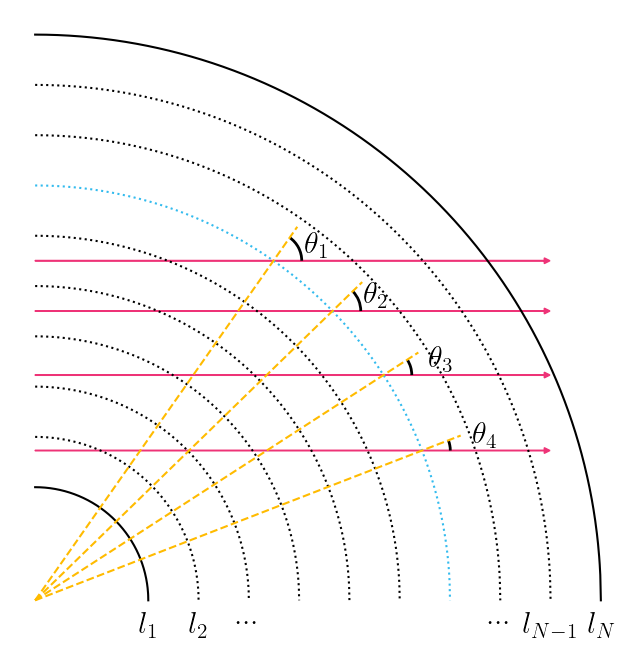

In [51]:
n_angular_points = 10
mu_values, mu_weights = np.polynomial.legendre.leggauss(n_angular_points)
mu_values, mu_weights = (mu_values + 1) * 0.5, mu_weights / 2

outer_radius = 1.0
shell_x = np.linspace(0, outer_radius, 1000)
shell_y = np.sin(np.acos(shell_x / outer_radius)) * outer_radius

surface_radius = 0.2
surface_x = np.linspace(0, surface_radius, 1000)
surface_y = np.sin(np.acos(surface_x / surface_radius)) * surface_radius

plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r"\usepackage{amsmath}")
plt.figure(figsize=(8, 8))

plt.plot(shell_x, shell_y, color="#000000")
plt.plot(surface_x, surface_y, color="#000000")
n_layers = n_angular_points
# layer_step_size = 0.1
layer_step_size = (outer_radius - surface_radius) / (n_layers - 1)
# intersect_radius = 0.7
intersect_radius = surface_radius + 6 * layer_step_size
for layer_radius in np.arange(surface_radius + layer_step_size, outer_radius, layer_step_size):
    layer_x = np.linspace(0, layer_radius, 1000)
    layer_y = np.sin(np.acos(layer_x / layer_radius)) * layer_radius
    if layer_radius == intersect_radius:
        plt.plot(layer_x, layer_y, linestyle=":", color="#33BBEE")
    else:
        plt.plot(layer_x, layer_y, linestyle=":", color="#000000")


plt.text(surface_radius, -0.5 * layer_step_size, r"${l}_{1}$", ha="center", va="center", fontsize=label_fontsize)
plt.text(surface_radius + layer_step_size, -0.5 * layer_step_size, r"${l}_{2}$", ha="center", va="center", fontsize=label_fontsize)

plt.text(surface_radius + 2 * layer_step_size, -0.3 * layer_step_size, r"$...$", ha="center", va="center", fontsize=label_fontsize)
# plt.text((outer_radius + surface_radius) / 2, -0.5 * layer_step_size, r"$...$", ha="center", va="center", fontsize=label_fontsize)
plt.text(outer_radius - 2 * layer_step_size, -0.3 * layer_step_size, r"$...$", ha="center", va="center", fontsize=label_fontsize)

plt.text(outer_radius - layer_step_size, -0.5 * layer_step_size, r"${l}_{N-1}$", ha="center", va="center", fontsize=label_fontsize)
plt.text(outer_radius, -0.5 * layer_step_size, r"${l}_{N}$", ha="center", va="center", fontsize=label_fontsize)

from matplotlib.patches import Arc

# plt.scatter(np.sin(np.acos(mu_values)) * intersect_radius, mu_values * intersect_radius)
select_mu_idxs = [5, 6, 7, 8]
theta_offsets = [(0.055, 0.027), (0.055, 0.027), (0.08, 0.027), (0.09, 0.027)]
for ray_idx, mu_value in enumerate(mu_values[select_mu_idxs]):
    intersect_x_point = intersect_radius * mu_value
    intersect_y_point = intersect_radius * np.sin(np.acos(mu_value))
    intersect_x = np.linspace(0, intersect_x_point * 1.1, 100)
    intersect_y = intersect_x * intersect_y_point / intersect_x_point
    plt.plot(intersect_x, intersect_y, color="#FFBB00", linestyle="--")
    vline_len = np.sqrt((intersect_y.max() - intersect_y_point)**2 + (intersect_x.max() - intersect_x_point)**2)

    # print(180 + (180 * np.acos(mu_value) / np.pi))
    # plt.hlines(intersect_y_point, 0, 0.9, color="#FFBB00")
    plt.arrow(0, intersect_y_point, 0.9, 0, head_width=0.01, head_length=0.01, color="#EE3377")
    arc = Arc((intersect_x_point, intersect_y_point), width=0.1, height=0.1,
              angle=0,
              theta1=0, theta2=180 * np.acos(mu_value) / np.pi,
              color="#000000", lw=2)
    plt.gca().add_patch(arc)
    # if ray_idx == 0:
        # plt.text(0.92, intersect_y_point, r"Ray", ha="left", va="center", fontsize=label_fontsize)
    plt.text(intersect_x_point + theta_offsets[ray_idx][0], intersect_y_point + theta_offsets[ray_idx][1],
             fr"$\theta_{{{ray_idx + 1}}}$", ha="left", va="center", fontsize=label_fontsize)

plt.xlim(left=0 - layer_step_size / 2, right=outer_radius + layer_step_size / 2)
plt.ylim(bottom=0 - layer_step_size / 2, top=outer_radius + layer_step_size / 2)
plt.tick_params(axis="both", which="both", labelleft=False, labelbottom=False, left=False, bottom=False)
plt.axis("off")

plt.gca().set_aspect('equal')
plt.savefig(r"/mnt/c/PhD/NLTE/figures/angular_geometry.png", dpi=600, transparent=True, bbox_inches="tight")
plt.show()

In [5]:
ac_sqrt_NA_kB_on_c = (np.sqrt(ac.N_A * ac.k_B.cgs) / ac.c.cgs).to(
    u.kg**0.5 / (u.K**0.5 * u.mol**0.5), equivalencies=u.spectral()
)
const_sqrt_NA_kB_on_c = ac_sqrt_NA_kB_on_c.value
energy_fi = 50000
temperature = 10000
species_mass = 15
sigma = energy_fi * const_sqrt_NA_kB_on_c * np.sqrt(temperature / species_mass)
fwhm = 2 * np.sqrt(2 * np.log(2)) * sigma
print(fwhm)

0.02924007541673443


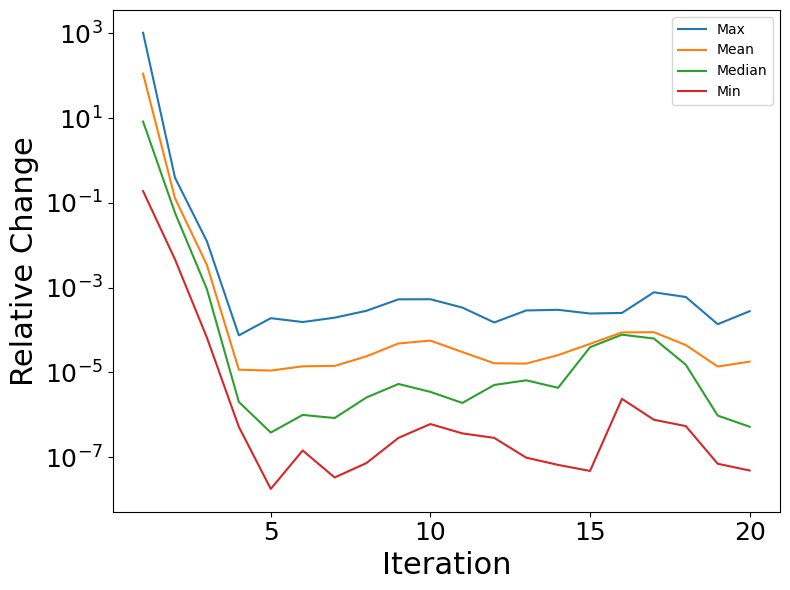

In [39]:
it1 = np.array([7.88709178e-01,1.30766355e+00,1.99487665e+00,2.88565857e+00,4.04662340e+00,5.53746681e+00,7.44766720e+00,9.82299160e+00,1.28476564e+01,1.65953846e+01,2.02233483e+01,1.97307060e+01,1.09570365e+01,2.66551921e+00,1.89747074e-01,2.80056551e-01,3.48381918e-01,3.54344076e-01,3.43804107e-01,3.34756444e-01,3.01207515e-01,2.94911477e-01,2.29745500e-01,2.23622611e-01,2.23985028e-01,2.24200546e-01,4.79525886e-01,4.98258097e-01,9.33445531e-01,9.79661094e-01,1.74105166e+00,1.86514878e+00,3.14185518e+00,3.33773151e+00,5.51406971e+00,6.31707566e+00,9.14605513e+00,1.19655001e+01,1.55413938e+01,1.99546096e+01,2.56439005e+01,3.25973451e+01,4.12592030e+01,5.18368478e+01,6.52825237e+01,8.13945980e+01,1.01076099e+02,1.24054920e+02,1.53635568e+02,1.88196746e+02,2.30102476e+02,2.78773858e+02,3.36161875e+02,4.02111585e+02,4.77744004e+02,5.66064079e+02,6.67270599e+02,7.79677224e+02,9.01314177e+02,1.02979754e+03])
it2 = np.array([0.21121923,0.23574566,0.25506846,0.26743132,0.28207267,0.29099875,0.29787748,0.30253455,0.29795433,0.31014407,0.31259978,0.31019086,0.30295353,0.26075495,0.14266845,0.03267961,0.00858288,0.01283337,0.00465218,0.02811888,0.00756056,0.06041505,0.0254792,0.10976306,0.05793918,0.17619187,0.10190163,0.25603683,0.15317572,0.3346285,0.20059614,0.38776202,0.22852546,0.3934539,0.26122858,0.24939931,0.20341203,0.05864538,0.04769148,0.01224005,0.01153906,0.00847442,0.00888227,0.00902998,0.0095423,0.01002691,0.01052579,0.01103066,0.01150541,0.01198599,0.01243449,0.01287054,0.01325919,0.01360587,0.01389737,0.01410717,0.01415845,0.01406127,0.01373086,0.01313184])
it3 = np.array([7.22196104e-03,8.46918767e-03,9.39194626e-03,1.01077713e-02,1.05988309e-02,1.11773348e-02,1.16796517e-02,1.17655107e-02,1.20156933e-02,1.21764775e-02,1.23693365e-02,1.23613756e-02,1.19676027e-02,1.01057739e-02,4.94081761e-03,1.51002835e-03,5.70408002e-04,3.96111010e-04,4.00275248e-04,4.19869336e-04,6.35971220e-04,5.85231735e-04,9.99958380e-04,8.41791249e-04,1.29246079e-03,1.23852128e-03,1.35604980e-03,1.91204979e-03,1.18017921e-03,3.09381739e-03,1.01354466e-03,4.95918056e-03,1.29128528e-03,6.64031431e-03,2.90733449e-03,6.89353749e-03,6.24183124e-03,5.72543878e-04,4.67369457e-04,6.62452955e-05,7.07739814e-05,7.00258628e-05,7.59908605e-05,8.14163022e-05,8.71817893e-05,9.27400113e-05,9.79804175e-05,1.03151234e-04,1.07939157e-04,1.12546575e-04,1.16805343e-04,1.20931291e-04,1.24533140e-04,1.27786346e-04,1.30491161e-04,1.32498151e-04,1.32912692e-04,1.31937920e-04,1.28748764e-04,1.22977347e-04])
it4 = np.array([4.99184099e-05,7.47448398e-05,2.79870423e-05,4.14699044e-06,4.88734137e-05,7.04834709e-05,4.46330196e-05,5.86326611e-06,2.06140388e-05,3.02190675e-05,8.46919696e-06,8.40057132e-06,8.14336068e-06,5.57132622e-06,3.81653158e-06,1.35850758e-06,7.73787101e-07,7.36320222e-07,6.64181437e-07,3.65896595e-06,1.78156631e-06,1.17791958e-06,1.58586258e-06,1.39351769e-06,3.15772437e-06,2.66132091e-06,3.91304378e-06,5.02579195e-06,2.51966412e-06,9.61314594e-06,6.21163451e-06,1.81979742e-05,1.11332560e-05,3.20198910e-05,2.16487722e-05,6.08397431e-05,6.75254344e-05,2.24325108e-06,1.57175597e-06,5.19708728e-07,5.67685726e-07,5.46477989e-07,6.01510692e-07,6.86194006e-07,7.44298451e-07,8.30706284e-07,9.09700463e-07,9.78997629e-07,1.00380154e-06,1.13796633e-06,1.20232591e-06,1.26990296e-06,1.33479943e-06,1.38086841e-06,1.42663028e-06,1.40643296e-06,1.46885822e-06,1.47892169e-06,1.48676309e-06,1.46255122e-06])
it5 = np.array([9.26240345e-05,4.42598236e-05,5.39273716e-05,7.35838915e-05,3.22717880e-05,1.90427243e-04,4.13702620e-06,4.96109666e-06,2.49579420e-05,4.08599785e-05,1.22319332e-05,1.05934408e-05,7.96922515e-06,2.94639386e-06,3.38271196e-06,4.62340108e-07,2.08163774e-07,1.36666328e-07,1.94974958e-07,5.62088771e-06,5.05640825e-08,2.56286550e-08,1.78273646e-08,2.47958640e-08,4.07413704e-08,4.88974808e-08,7.60440943e-08,8.06075442e-08,1.12053897e-07,3.74101909e-05,7.73184485e-06,1.01204503e-06,1.44129526e-06,7.28051695e-07,5.82939680e-07,7.01394186e-07,5.16758678e-07,4.16239619e-07,3.50887958e-07,6.17371639e-07,4.90161306e-07,3.89432553e-07,2.99995334e-07,2.28951992e-07,1.84216390e-07,2.18303500e-07,2.46731274e-07,1.67355539e-07,1.89165664e-07,2.08521841e-07,2.27881578e-07,2.28959059e-07,2.22277336e-07,2.22770948e-07,2.27887646e-07,2.55096761e-07,2.98802141e-07,3.55346877e-07,3.72177163e-07,3.95553926e-07])
it6 = np.array([9.60042902e-05,5.24006803e-05,4.52980050e-05,2.04583797e-05,1.54260565e-04,1.37010113e-04,1.10739504e-05,1.69491937e-05,4.51513894e-05,5.41991066e-05,6.70137386e-06,1.93109559e-06,1.97879946e-05,6.38682124e-06,1.37160126e-06,5.34277688e-07,1.44027756e-07,3.13110483e-07,5.11729929e-07,2.79533938e-06,8.46515412e-07,1.68258822e-06,1.99274394e-06,3.80562521e-06,4.44436819e-06,7.17210582e-06,7.95568848e-06,5.07269145e-06,2.64958013e-05,6.69784526e-05,1.55645741e-05,2.31227726e-06,1.39236418e-06,1.18894447e-06,8.82686163e-07,1.08076137e-06,7.95687508e-07,8.48795761e-07,7.24917159e-07,9.05093919e-07,6.98212260e-07,5.35252892e-07,3.95427435e-07,2.86427299e-07,3.31695515e-07,3.73527486e-07,4.05046356e-07,4.62742710e-07,5.15293383e-07,5.58013784e-07,6.03416171e-07,6.09750179e-07,5.94553898e-07,6.00843121e-07,6.06871695e-07,5.93596548e-07,5.67971500e-07,5.94209994e-07,5.55352902e-07,5.77395927e-07])
it7 = np.array([1.95523800e-04,3.24188898e-05,7.57130396e-05,4.07670537e-05,1.88483624e-04,4.22436690e-05,1.86693260e-05,4.48774895e-06,8.53655252e-06,9.08840104e-06,3.29670578e-05,3.30609660e-06,1.29335061e-05,8.62005786e-06,1.79592731e-06,6.39430428e-07,1.87557729e-07,4.48250825e-07,5.70002903e-07,3.31837614e-08,1.33668796e-06,8.00190915e-06,3.79310501e-06,7.36736798e-06,8.31327866e-06,1.36618731e-05,1.45499216e-05,1.02137157e-05,4.77535715e-05,3.40070365e-05,9.80776906e-06,1.59706516e-06,5.85686095e-07,4.83247654e-07,3.17896968e-07,6.02787304e-07,4.46150113e-07,4.90883770e-07,5.37593666e-07,4.20954333e-07,4.02448685e-07,3.77061654e-07,3.83743935e-07,3.98846203e-07,4.16302547e-07,4.83045438e-07,5.42740259e-07,4.82305273e-07,5.09098047e-07,5.24702239e-07,4.86527461e-07,5.91138337e-07,6.41480001e-07,6.69831831e-07,6.97983216e-07,7.49568883e-07,8.22732376e-07,8.55239753e-07,9.22457831e-07,9.35980923e-07])
it8 = np.array([6.26881419e-05,1.95527327e-04,2.17054759e-04,2.84714471e-04,1.67758101e-04,1.64617399e-04,3.18011536e-05,3.65568267e-05,4.89958946e-05,5.79002617e-05,1.81769788e-05,6.83223054e-06,6.82981419e-07,8.59173134e-06,2.58513431e-06,2.31656138e-07,1.05490001e-07,1.66867167e-07,1.74306962e-07,7.82669852e-08,5.63658909e-07,8.86835953e-06,2.12100879e-06,4.20425589e-06,4.54261440e-06,7.46959004e-06,7.67564675e-06,5.98596266e-06,2.50165697e-05,4.84331931e-06,1.90483319e-06,2.84842718e-07,4.79869393e-07,7.28184720e-08,1.40605526e-05,1.02051183e-06,1.46839573e-06,6.24009280e-07,6.54297414e-07,5.92492085e-07,6.43547837e-07,7.41220745e-07,8.36644316e-07,1.01033132e-06,1.77340846e-06,1.80003420e-06,1.96543507e-06,2.01438168e-06,2.14043277e-06,2.14683154e-06,2.23269206e-06,2.48473812e-06,2.61420383e-06,2.66213492e-06,2.72781809e-06,2.76922705e-06,2.79910542e-06,2.84740418e-06,2.73073232e-06,2.54962550e-06])
it9 = np.array([3.44772520e-04,8.88991802e-05,4.58257147e-04,5.30043237e-04,3.94907362e-04,3.18265853e-04,1.60145091e-05,1.63608268e-04,6.21295725e-05,1.31982978e-04,4.82019834e-05,5.24558625e-05,4.41413978e-05,2.60515687e-05,1.36001559e-05,4.06547964e-06,1.48819294e-06,2.93792405e-06,6.93353449e-07,6.87562688e-07,2.85531402e-07,2.44869995e-06,6.78962494e-07,3.31924740e-07,3.19037790e-07,7.47882197e-07,8.03946248e-07,2.17948036e-05,3.96444714e-06,1.27878301e-06,2.10791866e-06,3.66874891e-06,1.96380292e-06,9.55740574e-06,2.67211222e-05,1.79845191e-06,2.48667800e-06,9.16560161e-07,1.02130212e-06,1.15639908e-06,1.45819731e-06,1.80164661e-06,2.16822770e-06,2.64995470e-06,4.28315226e-06,4.48950709e-06,4.93647636e-06,5.16512684e-06,5.50104727e-06,5.55425149e-06,5.66234084e-06,6.35261496e-06,6.65783955e-06,6.79315195e-06,6.96662602e-06,7.07036977e-06,7.14016829e-06,7.26620369e-06,7.08332193e-06,6.79475072e-06])
it10 = np.array([3.06277638e-04,2.30753729e-04,5.32701594e-04,4.29878468e-04,4.60880262e-04,3.04878430e-04,5.99446466e-05,2.25536167e-04,9.45513205e-05,1.76352719e-04,8.76438290e-05,9.06022884e-05,8.37933253e-05,4.68720083e-05,2.55490353e-05,8.12961997e-06,1.92147300e-06,5.90212074e-06,1.42332908e-06,1.14907238e-06,6.04848304e-07,1.00882764e-06,1.22531258e-06,2.13345814e-06,2.55572069e-06,2.66563397e-06,1.78131532e-05,3.91989640e-05,1.78059513e-06,3.07975985e-06,4.68315641e-06,7.27628427e-06,5.28488950e-06,1.93541032e-05,2.47377389e-05,2.23217125e-06,1.69017383e-06,1.90182007e-06,1.82573078e-06,1.80620659e-06,1.63258966e-06,1.43396362e-06,1.26651469e-06,1.79294453e-06,3.27397993e-06,2.44493798e-06,2.67516196e-06,2.75731338e-06,2.90864489e-06,2.88613796e-06,2.85413620e-06,3.23454167e-06,3.41994506e-06,3.49852976e-06,3.59573932e-06,3.65513181e-06,3.69137678e-06,3.75615591e-06,3.63136005e-06,3.44262214e-06])
it11 = np.array([2.35877163e-04,5.68277770e-05,3.38457986e-04,2.24690380e-04,1.49179962e-04,1.39181642e-04,6.70905560e-05,1.21180675e-04,3.52041087e-05,7.92877317e-05,5.39855565e-05,5.00503169e-05,4.34864620e-05,3.75504996e-05,2.42906331e-05,8.18343572e-06,2.03161386e-06,4.22991411e-06,1.24155106e-06,7.62734234e-07,8.80672758e-07,1.81521292e-06,2.01862722e-06,4.13231697e-06,4.91091525e-06,5.22181178e-06,3.28631670e-05,1.92552593e-05,3.64128215e-07,1.99792277e-06,3.08453943e-06,4.38967876e-06,3.53725232e-06,1.16696717e-05,1.40067330e-05,1.35426572e-06,1.24971878e-06,1.69683293e-06,1.63942362e-06,1.70621290e-06,1.63335844e-06,1.57523635e-06,1.51691854e-06,1.45951184e-06,1.31659797e-06,1.36587839e-06,1.42703653e-06,1.50626324e-06,1.56441196e-06,1.61897512e-06,1.77628562e-06,1.43654434e-06,1.27594041e-06,1.19450850e-06,1.13549285e-06,1.10114702e-06,1.08177999e-06,1.06860065e-06,1.07174858e-06,1.08981077e-06])
it12 = np.array([1.17488355e-04,1.42843868e-04,4.34791827e-05,8.25212241e-05,2.72813985e-05,5.47135521e-05,3.30061484e-05,6.41439998e-06,2.78713718e-05,5.49857630e-05,1.96863568e-05,1.42229226e-05,2.25458523e-05,2.00629684e-05,1.22589588e-05,4.69860793e-06,1.15285573e-06,1.35413087e-06,5.64205949e-07,2.85210748e-07,3.50282090e-07,9.62777621e-07,9.49446925e-07,2.37638255e-06,1.50698880e-04,4.17270596e-06,1.74575951e-05,3.96586978e-06,2.58789497e-06,8.53290161e-07,6.66345411e-07,9.76562220e-07,1.10553578e-06,2.45549200e-06,1.29312705e-06,1.13098150e-06,1.31913062e-06,1.76379506e-06,1.98218348e-06,2.24173172e-06,2.43607066e-06,2.62684001e-06,2.80475461e-06,2.98926993e-06,3.24742868e-06,5.62064546e-06,5.76171511e-06,5.91234314e-06,5.99354031e-06,6.10008923e-06,6.33667124e-06,5.86736091e-06,5.63781626e-06,5.52365492e-06,5.41943871e-06,5.33011570e-06,5.23340445e-06,5.12097658e-06,4.99509897e-06,4.85416316e-06])
it13 = np.array([5.07220473e-05,3.56946303e-05,2.74900786e-05,6.70547006e-06,2.22815352e-05,1.08128534e-05,5.68873231e-05,1.55642533e-05,1.58930455e-05,5.02723234e-05,6.03620093e-06,8.61153923e-06,3.61199322e-06,8.17848713e-07,2.26520377e-06,5.22477241e-07,1.86074722e-07,9.75022597e-08,1.01934343e-07,3.71108581e-07,5.35750990e-07,1.10855437e-06,1.37641069e-06,1.58326278e-04,2.89590391e-04,5.03290586e-06,2.51571447e-06,1.55766290e-06,4.61499673e-06,1.81368068e-06,1.47148862e-06,1.21561515e-06,1.42489201e-06,1.71380149e-06,1.90688899e-06,2.80293102e-06,3.51584599e-06,4.20016198e-06,4.66139509e-06,5.16705513e-06,5.56595615e-06,5.95572285e-06,6.31728565e-06,6.71736383e-06,7.40702077e-06,8.94998657e-06,8.85117498e-06,8.77956650e-06,8.66586520e-06,8.60680930e-06,8.56665326e-06,8.39360700e-06,8.25949929e-06,8.35582906e-06,8.53514844e-06,8.69278384e-06,8.76105723e-06,8.67116165e-06,8.28732540e-06,7.65043695e-06])
it14 = np.array([4.20794631e-05,1.77303186e-04,5.03015019e-05,2.24463871e-04,1.24230808e-04,1.71370959e-04,2.21294144e-05,3.58594323e-05,3.80580239e-06,1.49955083e-05,2.76535412e-05,3.58537064e-05,5.98970323e-06,1.97991582e-06,1.43368985e-06,6.57356684e-08,7.79737803e-08,1.76659085e-07,1.33627251e-07,5.79597144e-07,7.18736338e-07,1.66068579e-06,2.33708160e-06,2.99969343e-04,1.61563369e-04,1.80733635e-06,2.20969686e-07,4.01274658e-07,2.40339011e-06,8.78382246e-07,9.25439212e-07,9.53157326e-07,1.31564814e-06,1.46652839e-06,1.68374093e-06,2.52255649e-06,3.26173510e-06,3.90729835e-06,4.31476748e-06,4.77761057e-06,5.13367438e-06,5.48042523e-06,5.78504124e-06,6.10041953e-06,6.54422577e-06,5.21996888e-06,4.93932409e-06,4.69142575e-06,4.45480889e-06,4.27188213e-06,4.03449051e-06,4.14808452e-06,4.16337425e-06,4.35723009e-06,4.65584056e-06,4.92969243e-06,5.12540015e-06,5.15051384e-06,4.84395140e-06,4.26702241e-06])
it15 = np.array([4.89787765e-05,1.34407652e-04,6.52707833e-05,2.45139093e-04,3.67436436e-05,1.41537962e-04,6.83439276e-05,5.17203732e-05,5.36993679e-05,3.03772862e-05,7.64755468e-05,3.85111295e-05,1.45574418e-05,5.59440378e-06,2.55455269e-07,4.86050645e-08,4.73109166e-08,1.12969990e-07,6.85396984e-08,2.41992020e-07,3.11784955e-07,7.28506327e-05,2.23555902e-05,1.64121477e-04,4.00061863e-05,2.79086959e-05,3.26523177e-05,3.30160746e-05,3.73186020e-05,3.90583785e-05,4.35450169e-05,4.53379651e-05,4.93009075e-05,5.19903204e-05,5.31391330e-05,5.98371311e-05,5.96470703e-05,6.72861789e-05,6.73970779e-05,6.87189269e-05,6.62523321e-05,6.33150603e-05,5.92182955e-05,5.49786010e-05,5.10826273e-05,4.62548163e-05,4.26857489e-05,3.97448094e-05,3.69336195e-05,3.48100113e-05,3.27809070e-05,3.15298915e-05,3.03692331e-05,2.94916617e-05,2.87435620e-05,2.81148695e-05,2.74995675e-05,2.68290918e-05,2.59752042e-05,2.49391340e-05])
it16 = np.array([2.41884390e-04,2.52956913e-04,5.14455289e-05,1.23612328e-04,1.65869777e-04,6.55594975e-05,4.41009391e-05,4.60462173e-05,1.26167446e-04,4.97095605e-05,1.13999303e-04,5.87246620e-06,2.17107607e-05,1.33436937e-05,4.92458193e-06,4.80016373e-06,4.15985137e-06,2.37741908e-06,3.51951468e-06,6.35909136e-06,1.23934241e-04,1.46561601e-04,3.18949934e-05,2.30127330e-05,1.73283306e-05,4.87757715e-05,5.76751982e-05,6.55947645e-05,7.45983596e-05,7.74543968e-05,8.67486688e-05,8.98552296e-05,9.82344221e-05,1.02863099e-04,1.05845389e-04,2.11310930e-04,1.82443420e-04,1.61663385e-04,1.61199041e-04,1.62472957e-04,1.57392412e-04,1.51446850e-04,1.43296836e-04,1.34937578e-04,1.26004654e-04,1.16229699e-04,1.07629587e-04,1.00260038e-04,9.29896428e-05,8.72473250e-05,8.17427803e-05,7.77655859e-05,7.41243836e-05,7.12200419e-05,6.86311178e-05,6.63439351e-05,6.40499363e-05,6.16000537e-05,5.86976942e-05,5.52377375e-05])
it17 = np.array([3.59602450e-04,7.76707125e-04,1.80512547e-04,7.06420222e-05,2.45314282e-04,9.50363547e-05,5.86162143e-05,7.40959907e-05,1.66773287e-04,6.77593868e-05,1.21532283e-04,1.44910727e-05,2.44262156e-05,1.36898455e-05,9.05109893e-06,7.81053074e-06,6.80707991e-06,3.48974841e-06,5.32280826e-06,1.30670245e-05,2.48259970e-04,8.55682083e-05,1.14812510e-05,7.63881748e-07,1.16231688e-06,2.54104504e-05,3.02003104e-05,4.04672930e-05,4.67100903e-05,5.07477751e-05,5.71126157e-05,6.44543686e-05,7.22202453e-05,9.41812017e-05,5.27648899e-05,2.04883868e-04,1.60325910e-04,1.20743108e-04,1.19447652e-04,1.18926265e-04,1.15492436e-04,1.11462814e-04,1.05996558e-04,1.00373421e-04,9.41933190e-05,8.74545544e-05,8.12776465e-05,7.58374997e-05,7.03537470e-05,6.58960245e-05,6.15850842e-05,5.83276284e-05,5.53431121e-05,5.29057446e-05,5.07169232e-05,4.87382461e-05,4.67231061e-05,4.45226263e-05,4.18980598e-05,3.87297181e-05])
it18 = np.array([2.67576987e-04,6.01855079e-04,7.12011601e-05,2.18559767e-04,2.05346796e-04,6.09049347e-05,7.37058240e-05,6.90456355e-05,1.44180805e-04,5.68015521e-05,4.99956449e-05,4.02567484e-06,1.72950794e-05,5.38212981e-06,4.49589187e-06,3.25542786e-06,2.93324110e-06,1.16055622e-06,1.97080810e-06,7.95715956e-06,1.45793595e-04,1.25927855e-05,1.42504767e-06,5.41177090e-07,8.20104279e-07,5.50392190e-06,5.83799735e-06,8.37255171e-06,1.04344885e-05,1.35268352e-05,1.57898364e-05,2.33442856e-05,2.75113501e-05,5.46830114e-05,4.85193445e-06,5.39625005e-05,3.63767008e-05,2.50245404e-05,2.41837744e-05,2.36886538e-05,2.29329881e-05,2.21534125e-05,2.11215378e-05,2.00911744e-05,1.89663066e-05,1.77683434e-05,1.66599209e-05,1.56832141e-05,1.46839121e-05,1.38649295e-05,1.30657672e-05,1.24469265e-05,1.18804712e-05,1.14075638e-05,1.09763777e-05,1.05734259e-05,1.01550265e-05,9.67757501e-06,9.09787267e-06,8.38280230e-06])
it19 = np.array([7.03770928e-05,1.34729855e-04,6.32267854e-05,1.37317565e-04,5.98062918e-05,7.70055835e-05,2.06987773e-05,1.42306067e-05,6.62402934e-05,5.44730709e-06,3.02367943e-05,1.07642762e-05,5.78189483e-06,6.62315898e-06,1.42554034e-06,3.34664090e-07,3.16021212e-07,6.99125970e-08,1.76921060e-07,1.34327418e-06,7.50263116e-05,2.57534347e-06,7.42505285e-07,4.17301461e-07,3.63108765e-07,1.49588702e-07,5.09507847e-07,3.39908002e-07,4.87192938e-07,8.77285475e-07,1.06390779e-06,2.15564355e-06,2.86496456e-06,8.32533772e-06,4.20012783e-07,3.07730712e-06,1.53034219e-06,1.18739399e-06,1.08776165e-06,1.05815659e-06,1.02629727e-06,1.00731052e-06,9.73125112e-07,9.41874013e-07,9.06178076e-07,8.68580044e-07,8.33983350e-07,8.04269094e-07,7.73071344e-07,7.46743824e-07,7.24785978e-07,7.08591614e-07,6.94178017e-07,6.83249522e-07,6.73837402e-07,6.64691143e-07,6.47527444e-07,6.28154251e-07,6.03091860e-07,5.62501026e-07])
it20 = np.array([4.73458469e-05,4.50591114e-05,2.78360000e-04,2.01584857e-04,4.74964252e-05,2.83366316e-05,2.58680759e-05,1.39483762e-05,2.10637321e-05,3.34181600e-05,3.84841274e-05,8.12251640e-06,4.97101019e-06,4.63507003e-06,1.25925468e-06,6.28112084e-07,4.85006250e-08,6.66802475e-08,8.38475338e-08,9.88015465e-05,1.49188218e-04,8.14929859e-06,1.30699947e-06,1.10416255e-06,7.95506184e-07,6.81153012e-07,6.41160798e-07,7.05884187e-07,7.36775628e-07,5.05797841e-07,5.03592076e-07,3.89215153e-07,3.44851862e-07,1.49436328e-07,7.98898403e-07,4.41534167e-07,4.75113577e-07,4.97725414e-07,5.05681379e-07,5.54010560e-07,5.37234553e-07,5.31962942e-07,5.13038689e-07,4.96027880e-07,4.77832424e-07,4.60315783e-07,4.43628006e-07,4.30113243e-07,4.15553923e-07,4.05411456e-07,3.92647045e-07,3.82343392e-07,3.70171197e-07,3.57671152e-07,3.42185481e-07,3.22742822e-07,3.01717308e-07,2.79022826e-07,2.91434510e-07,3.44129791e-07])

pop_change_matrix = np.stack([it1, it2, it3, it4, it5, it6, it7, it8, it9, it10, it11, it12, it13, it14, it15, it16, it17, it18, it19, it20])

plt.figure(figsize=(8, 6), dpi=100)

plt.plot(np.arange(1, pop_change_matrix.shape[0] + 1), pop_change_matrix.max(axis=1), label="Max")
plt.plot(np.arange(1, pop_change_matrix.shape[0] + 1), pop_change_matrix.mean(axis=1), label="Mean")
plt.plot(np.arange(1, pop_change_matrix.shape[0] + 1), np.median(pop_change_matrix, axis=1), label="Median")
plt.plot(np.arange(1, pop_change_matrix.shape[0] + 1), pop_change_matrix.min(axis=1), label="Min")
plt.legend(loc="best")
plt.yscale("log")
plt.xlabel("Iteration", fontsize=label_fontsize)
plt.ylabel("Relative Change", fontsize=label_fontsize)
plt.tick_params(labelsize=tick_fontsize)
plt.tight_layout()
plt.show()

In [12]:
l27_pops1 = np.array([0.9717975489586008, 0.027262709583874622, 0.0009028066201932588, 3.5223845449818e-05, 1.6175384170938323e-06, 8.742287915734169e-08, 5.568697037114237e-09, 4.195709961061895e-10, 3.766842715029786e-11, 4.108414774384596e-12, 5.402397032031179e-13])

# l26_pops1 = np.array([0.9716568667798354, 0.027394220575533975, 0.0009114497881290077, 3.572007650238424e-05, 1.6472160588911597e-06, 8.93752113511399e-08,
#                      5.7133594328156065e-09, 4.31763221443925e-10, 3.882888585275954e-11, 4.223655942827642e-12, 5.5388555799118e-13])
l26_pops1 = np.array([0.9716568667798354, 0.027394220575533975, 0.0, 3.572007650238424e-05, 1.6472160588911597e-06, 8.93752113511399e-08,
                     5.7133594328156065e-09, 4.31763221443925e-10, 3.882888585275954e-11, 4.223655942827642e-12, 5.5388555799118e-13])
l26_pops2 = np.array([0.9716568667795773, 0.027394220575526596, 0.0009114497882389287, 3.57200766410907e-05, 1.6472160730340082e-06, 8.937521353683467e-08,
                      5.713359918964718e-09, 4.3176316233335024e-10, 3.882881059307972e-11, 4.2236855045292646e-12, 5.537993363959595e-13])
# l26_pops2 = np.array([0.9716568667795773, 0.0, 0.0009114497882389287, 3.57200766410907e-05, 1.6472160730340082e-06, 8.937521353683467e-08,
#                       5.713359918964718e-09, 4.3176316233335024e-10, 3.882881059307972e-11, 4.2236855045292646e-12, 5.537993363959595e-13])
l26_pops3 = np.array([0.9715188017446875, 0.027530549114996233, 0.0009131179007604464, 3.5785327308258876e-05, 1.6501867832148102e-06, 8.952781600152956e-08,
                      5.721756836311468e-09, 4.32274705328416e-10, 3.884912987581057e-11, 4.2162150233479744e-12, 5.51410337383625e-13])
l26_delta = (l26_pops3 - l26_pops2) / 2.0
# l26_delta
l26_pops3_nosor = l26_pops2 + l26_delta
print(l26_pops3_nosor)

max_delta = max(abs(l26_delta)) / max(abs(l26_pops2 - l26_pops1))
print(max_delta)
print(abs(l26_pops2 - l26_pops1))
# curr_rel_change = abs(l26_pops3_nosor - l26_pops2) / l26_pops2
with np.errstate(divide='ignore'):
    prev_rel_change = abs(l26_pops2 - l26_pops1) / l26_pops1
    curr_rel_change = abs(l26_pops3_nosor - l26_pops2) / l26_pops2
    new_max_delta = curr_rel_change.max() / prev_rel_change.max()

print(f"Prev. Rel. Change = {prev_rel_change} (Max. = {prev_rel_change.max()})")
print(f"Curr. Rel. Change = {curr_rel_change} (Max. = {curr_rel_change.max()})")
print(f"[New] Max. delta = {new_max_delta}")
new_max_delta = min(new_max_delta, 1.0)
print(f"[New] Max. delta = {new_max_delta}")

[9.71587834e-01 2.74623848e-02 9.12283844e-04 3.57527020e-05
 1.64870143e-06 8.94515148e-08 5.71755838e-09 4.32018934e-10
 3.88389702e-11 4.21995026e-12 5.52604837e-13]
0.07573924349499422
[2.58126853e-13 7.37951367e-15 9.11449788e-04 1.38706463e-13
 1.41428486e-14 2.18569476e-15 4.86149111e-16 5.91105748e-17
 7.52596798e-17 2.95617016e-17 8.62215952e-17]
Prev. Rel. Change = [2.65656388e-13 2.69382137e-13            inf 3.88315134e-09
 8.58590983e-09 2.44552682e-08 8.50898875e-08 1.36905072e-07
 1.93823949e-06 6.99907900e-06 1.55666805e-04] (Max. = inf)
Curr. Rel. Change = [7.10461890e-05 2.48827192e-03 9.15087448e-04 9.13361243e-04
 9.01736642e-04 8.53718042e-04 7.34849324e-04 5.92388420e-04
 2.61652139e-04 8.84355757e-04 2.15691755e-03] (Max. = 0.0024882719165850915)
[New] Max. delta = 0.0
[New] Max. delta = 0.0


In [13]:
# Broken 2-0 trans test:
imi = 1.5942921298265753e-10
lambda_source_mean = 1.5984650785296187e-10
lambda_source_integral = 1.589898364411079e-10

print(imi - lambda_source_mean, imi - lambda_source_integral)

-4.1729487030434135e-13 4.393765415496175e-13


In [29]:
y_mat = np.random.rand(5, 5)
diag = np.diag(np.ones(5)*-1)
diag[diag == 0] = 1.0
y_mat = y_mat * diag
y_mat[1, 1] *= -1
y_mat[3, 3] *= -1
print(y_mat)
check_rows = np.array(
    [np.all(y_mat[idx, :] > 0) or np.all(y_mat[idx, :] < 0) for idx in range(y_mat.shape[0])]
)
print(check_rows)
if np.any(check_rows):
    print(f"Y matrix all positive in rows = {np.nonzero(check_rows)[0]}")

[[-0.82849657  0.68830138  0.04835986  0.53330373  0.33165605]
 [ 0.77618107  0.58798449  0.85446568  0.3529551   0.20000357]
 [ 0.95026399  0.84464215 -0.57623845  0.02744021  0.52942846]
 [ 0.32971278  0.90475772  0.9981982   0.05075932  0.94797213]
 [ 0.45924467  0.91694717  0.38679398  0.48284922 -0.06735213]]
[False  True False  True False]
Y matrix all positive in rows = [1 3]


In [58]:
y_mat = np.array([[-1.38172567e-01, 5.21542510e-01, 3.39328815e-01, 9.00347582e-04, 4.83883609e-05, 5.98137680e-06, 1.10075012e-06, 2.36395106e-07, 4.57802380e-08, 6.75675720e-09, 3.57600159e-10],
 [ 1.22814115e-01, -6.26011336e-01, 2.44402698e-01, 5.56212655e-03, 1.00117274e-03, 1.72006842e-04, 2.93125746e-05, 5.81626709e-06, 1.16213445e-06, 2.25179330e-07, 2.77126493e-08],
 [ 6.62284059e-03, 2.23528168e-02, -3.50344023e-01, 6.15601828e-01, 3.97802596e-03, 9.25410771e-04, 1.43321671e-04, 2.54902104e-05, 5.06482098e-06, 1.01794317e-06, 1.59617744e-07],
 [ 7.21187402e-05, 5.78409693e-04, 5.73516728e-02, -3.76784475e-01, 5.61610942e-01, 2.81543995e-03, 6.60103278e-04, 1.03683329e-04, 1.85216440e-05, 3.93646292e-06, 6.97276216e-07],
 [ 5.13966094e-07, 2.73935921e-05, 5.00593132e-04, 5.82352862e-02, -3.76889775e-01, 5.61801788e-01, 2.00297136e-03, 4.62375217e-04, 6.50822249e-05, 1.18643107e-05, 2.35696544e-06],
 [ 2.82280053e-09, 5.83766630e-07, 2.92250386e-05, 3.88655760e-04, 6.41728120e-02, -3.90606278e-01, 5.43122595e-01, 1.35688085e-03, 2.79451555e-04, 3.74926106e-05, 6.02234646e-06],
 [ 5.87617694e-11, 7.48191625e-09, 7.36313626e-07, 2.39092852e-05, 2.86578195e-04, 6.70449336e-02, -3.95691670e-01, 5.36044685e-01, 7.46213577e-04, 1.45205335e-04, 1.60611229e-05],
 [ 1.42629632e-12, 1.37274571e-10, 1.01097566e-08, 5.64804922e-07, 1.47836581e-05, 1.56831208e-04, 5.83037871e-02, -3.76992574e-01, 5.64207802e-01, 2.75013658e-04, 4.86328631e-05],
 [ 3.90677446e-14, 3.64425656e-12, 2.03781851e-10, 1.04823970e-08, 4.20769159e-07, 8.89617664e-06, 7.87731104e-05, 7.60008235e-02, -4.11118126e-01, 5.12714475e-01, 7.84749414e-05],
 [ 9.30949759e-16, 9.62601200e-14, 5.36434141e-12, 2.19737092e-10, 9.94934627e-09, 2.94184209e-07, 4.26341568e-06, 3.12241108e-05, 7.05239645e-02, -4.02632730e-01, 5.26807514e-01],
 [ 4.11154944e-17, 6.53314407e-15, 4.15275558e-13, 1.88044230e-11, 5.98045123e-10, 1.94183079e-08, 4.01967617e-07, 6.13974281e-06, 3.10325610e-05, 2.91289606e-01, -7.08672800e-01]])
y_mat = np.vstack((y_mat, np.ones(y_mat.shape[1])))
print(y_mat)
rhs = np.zeros(y_mat.shape[0])
rhs[-1] = 1
new_pops = np.linalg.pinv(y_mat) @ rhs
print(new_pops)

old_pops = [0.092257874204159, 0.7437804218210183, 0.11426985283917247, 0.0346044766815139, 0.010387520439867617, 0.0031727992765302492,
            0.00100721587340253, 0.00033650806562198203, 0.0001192179524050703, 4.541807931376165e-05, 1.8694766995047943e-05]
pop_delta = new_pops - old_pops
# pop_delta
old_pops[1] + 2*pop_delta[1]
scale_factor = -(old_pops[1]/pop_delta[1])
# scale_factor
old_pops + scale_factor*pop_delta

[[-1.38172567e-01  5.21542510e-01  3.39328815e-01  9.00347582e-04
   4.83883609e-05  5.98137680e-06  1.10075012e-06  2.36395106e-07
   4.57802380e-08  6.75675720e-09  3.57600159e-10]
 [ 1.22814115e-01 -6.26011336e-01  2.44402698e-01  5.56212655e-03
   1.00117274e-03  1.72006842e-04  2.93125746e-05  5.81626709e-06
   1.16213445e-06  2.25179330e-07  2.77126493e-08]
 [ 6.62284059e-03  2.23528168e-02 -3.50344023e-01  6.15601828e-01
   3.97802596e-03  9.25410771e-04  1.43321671e-04  2.54902104e-05
   5.06482098e-06  1.01794317e-06  1.59617744e-07]
 [ 7.21187402e-05  5.78409693e-04  5.73516728e-02 -3.76784475e-01
   5.61610942e-01  2.81543995e-03  6.60103278e-04  1.03683329e-04
   1.85216440e-05  3.93646292e-06  6.97276216e-07]
 [ 5.13966094e-07  2.73935921e-05  5.00593132e-04  5.82352862e-02
  -3.76889775e-01  5.61801788e-01  2.00297136e-03  4.62375217e-04
   6.50822249e-05  1.18643107e-05  2.35696544e-06]
 [ 2.82280053e-09  5.83766630e-07  2.92250386e-05  3.88655760e-04
   6.41728120e-02 -

array([9.57392442e-01, 0.00000000e+00, 3.12288444e-02, 8.14943880e-03,
       2.25895015e-03, 6.60788200e-04, 2.04932306e-04, 6.77740248e-05,
       2.39474403e-05, 9.12615327e-06, 3.75614681e-06])

In [6]:
class BandProfile:
    __slots__ = ("start_idx", "profile", "integral")

    def __init__(self, profile: npt.NDArray[np.float64], start_idx: int = None) -> None:
        """

        :param start_idx: Index on the spectroscopic grid where the trimmed band profile begins.
        :param profile:   The band profile of the transition.
        integral:         The integral of the absorption profile pre-normalisation.
        """
        self.integral = 0.0
        if start_idx is None:
            if np.all(profile < _INTENSITY_CUTOFF):
                self.start_idx = 0
                self.profile = np.empty(0)
            else:
                self.start_idx = np.argmax(profile >= _INTENSITY_CUTOFF)
                end_idx = len(profile) - np.argmax(profile[::-1] >= _INTENSITY_CUTOFF)
                self.profile = profile[self.start_idx : end_idx]
        else:
            self.start_idx = start_idx
            self.profile = profile

    def __repr__(self):
        return f"BandProfile([{self.start_idx}, {self.profile}, {self.integral}])"

    def __str__(self):
        return (
            f"BandProfile(start_idx: {self.start_idx}, profile: "
            f"{self.profile}"
            f"({self.profile.size} points),"
            f" integral: {self.integral},"
            ")"
        )

    def merge_band_profiles(
        self, band_profiles: t.List["BandProfile"], normalise: bool = False, spectral_grid: u.Quantity = None
    ) -> None:
        # TODO: Handle case where some band_profiles are empty?
        if len(band_profiles) > 0:
            start_idxs = np.concatenate(([self.start_idx], [band_profile.start_idx for band_profile in band_profiles]))
            profiles = [self.profile] + [band_profile.profile for band_profile in band_profiles]

            min_start_idx = min(start_idxs)
            primary_idx = np.argmax(start_idxs == min_start_idx)
            max_end_idx = max(
                np.concatenate(
                    (
                        [self.start_idx + len(self.profile)],
                        [band_profile.start_idx + len(band_profile.profile) for band_profile in band_profiles],
                    )
                )
            )
            offset = max_end_idx - min_start_idx - len(profiles[primary_idx])

            merged_profile = np.pad(profiles[primary_idx], (0, offset), "constant")

            for profile_idx in range(len(start_idxs)):
                if profile_idx != primary_idx:
                    profile_offset = start_idxs[profile_idx] - min_start_idx
                    merged_profile[profile_offset : profile_offset + len(profiles[profile_idx])] += profiles[
                        profile_idx
                    ]

            self.start_idx = min_start_idx
            self.profile = merged_profile
        if normalise:
            if spectral_grid is None:
                raise RuntimeError("Normalisation specified but no wn_grid provided for integration.")
            self.normalise_band_profile(spectral_grid=spectral_grid)

    def normalise_band_profile(self, spectral_grid: u.Quantity) -> None:
        if self.profile.size == 0:
            pass
        else:
            if len(self.profile) == 1 and sum(self.profile) != 0:
                self.integral = self.profile.sum()
            else:
                self.integral = simpson(
                    self.profile,
                    x=spectral_grid[self.start_idx : self.start_idx + len(self.profile)].value,
                )
            if self.integral == 0:
                raise RuntimeError("Abs factor is 0 - Why?")
            self.profile /= self.integral

In [14]:
def calc_band_source(abs_band_profile: BandProfile, emi_band_profile: BandProfile, a_fi: u.Quantity, b_fi: u.Quantity,
                     a_if: u.Quantity, n_u: float, n_l: float) -> u.Quantity:
    min_start_idx = min(abs_band_profile.start_idx, emi_band_profile.start_idx)
    print(min_start_idx)
    max_end_idx = max([
        abs_band_profile.start_idx + len(abs_band_profile.profile),
        emi_band_profile.start_idx + len(emi_band_profile.profile)
    ])

    abs_profile = np.pad(
        abs_band_profile.profile,
        (abs_band_profile.start_idx - min_start_idx, max_end_idx - abs_band_profile.start_idx - len(abs_band_profile.profile)),
        "constant"
    )
    emi_profile = np.pad(
        emi_band_profile.profile,
        (emi_band_profile.start_idx - min_start_idx, max_end_idx - emi_band_profile.start_idx - len(emi_band_profile.profile)),
        "constant"
    )
    print(abs_profile, emi_profile)
    source_profile = (a_fi * n_u * emi_profile) / (n_l * b_if * abs_profile - n_u * b_fi * emi_profile)
    print(source_profile)

abs_band_profile = BandProfile(start_idx=104, profile=np.random.rand(20))
emi_band_profile = BandProfile(start_idx=107, profile=np.random.rand(15))
a_fi = 10
b_fi = 18
b_if = 20
n_u = 0.004
n_l = 0.03

calc_band_source(abs_band_profile, emi_band_profile, a_fi, b_fi, b_if, n_u, n_l)

104
[0.06631542 0.63825047 0.78611625 0.04107187 0.30330788 0.37217257
 0.80148385 0.98263328 0.361402   0.83917559 0.00222521 0.50306896
 0.42475667 0.18343339 0.62162042 0.1636703  0.46341547 0.99672863
 0.23910486 0.39567848] [0.         0.         0.         0.30015891 0.94858876 0.86766922
 0.3422753  0.80850129 0.90547568 0.8686246  0.02899352 0.87862858
 0.01886669 0.11406134 0.56588959 0.96009432 0.7507697  0.04850842
 0.         0.        ]
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.96030123e+00
  3.33756471e-01  2.15796034e-01  3.00079286e-02  6.08618869e-02
  2.38837822e-01  7.87931752e-02 -1.54136979e+00  1.47309606e-01
  2.97704407e-03  4.47968620e-02  6.81326373e-02  1.32083437e+00
  1.34069689e-01  3.26356831e-03  0.00000000e+00  0.00000000e+00]


ValueError: index can't contain negative values

In [85]:
def calc_lambda_approx_source(abs_band_profile: BandProfile, emi_band_profile: BandProfile, lambda_grid: npt.NDArray[np.float64],
                              wn_grid: u.Quantity, a_fi: u.Quantity, b_fi: u.Quantity,
                              b_if: u.Quantity, n_u: float, n_l: float, vmr: float, is_emi: bool = True) -> u.Quantity:
    abs_end_idx = abs_band_profile.start_idx + len(abs_band_profile.profile)
    emi_end_idx = emi_band_profile.start_idx + len(emi_band_profile.profile)
    if is_emi:
        emi_profile = emi_band_profile.profile
        if abs_band_profile.start_idx > emi_band_profile.start_idx:
            abs_profile = np.pad(abs_band_profile.profile, (abs_band_profile.start_idx - emi_band_profile.start_idx, 0), "constant")
        else:
            abs_profile = abs_band_profile.profile[emi_band_profile.start_idx - abs_band_profile.start_idx:]
        if abs_end_idx < emi_end_idx:
            abs_profile = np.pad(abs_profile, (0, emi_end_idx - abs_end_idx), "constant")
        else:
            abs_profile = abs_profile[:emi_end_idx - abs_end_idx]
    else:
        abs_profile = abs_band_profile.profile
        if emi_band_profile.start_idx > abs_band_profile.start_idx:
            emi_profile = np.pad(emi_band_profile.profile, (emi_band_profile.start_idx - abs_band_profile.start_idx, 0), "constant")
        else:
            emi_profile = emi_band_profile.profile[abs_band_profile.start_idx - emi_band_profile.start_idx:]
        if emi_end_idx < abs_end_idx:
            emi_profile = np.pad(emi_profile, (0, abs_end_idx - emi_end_idx), "constant")
        else:
            emi_profile = emi_profile[:abs_end_idx - emi_end_idx]
    # source_profile = (a_fi * n_u * emi_profile) / (n_l * b_if * abs_profile - n_u * b_fi * emi_profile)
    source_profile = np.where(
        (emi_profile == 0) & (abs_profile == 0),
        0,
        (a_fi * n_u * emi_profile) / (n_l * b_if * abs_profile - n_u * b_fi * emi_profile) / u.sr
    )
    print(source_profile)

    if len(source_profile) == 0:
        return 0 << source_profile.unit
    else:
        if is_emi:
            profile = emi_band_profile
        else:
            profile = abs_band_profile
        start_idx = profile.start_idx
        end_idx = start_idx + len(profile.profile)

        if len(profile.profile) == 1 and sum(profile.profile) != 0:
            return sum(profile.profile * lambda_grid[start_idx:end_idx] * source_profile * vmr) << source_profile.unit
        else:
            return (
                simpson(profile.profile * lambda_grid[start_idx:end_idx] * source_profile * vmr, x=wn_grid[start_idx:end_idx]) << source_profile.unit
            )


abs_band_profile = BandProfile(start_idx=104, profile=np.random.rand(20))
emi_band_profile = BandProfile(start_idx=107, profile=np.random.rand(15))
zero_idxs = np.random.randint(low=0, high=min(abs_band_profile.profile.shape[0], emi_band_profile.profile.shape[0]), size=2)
abs_band_profile.profile[zero_idxs] = 0
emi_band_profile.profile[zero_idxs] = 0
a_fi = 10 * 1 / u.s
b_fi = 18 * (u.m**2) / (u.J * u.s)
b_if = 20 * (u.m**2) / (u.J * u.s)
n_u = 0.004
n_l = 0.03
vmr = 0.5
print(abs_band_profile)
print(emi_band_profile)
wn_grid = np.linspace(0, 10000, 10001) << u.k
lambda_grid = np.random.rand(wn_grid.shape[0])
calc_lambda_approx_source(abs_band_profile, emi_band_profile, lambda_grid, wn_grid, a_fi, b_fi, b_if, n_u, n_l, vmr, is_emi=False)

BandProfile(start_idx: 104, profile: [0.17523633 0.39068425 0.46893337 0.         0.4977565  0.81900696
 0.65889176 0.08675885 0.33587925 0.71469433 0.04588168 0.92506899
 0.         0.21768145 0.45756833 0.52142004 0.74013127 0.30519547
 0.80278229 0.61892909](20 points), integral: 0.0,)
BandProfile(start_idx: 107, profile: [0.87986737 0.18727962 0.82507956 0.         0.67583625 0.57305056
 0.45496154 0.48171949 0.27342627 0.85851019 0.44346406 0.85762564
 0.         0.24745282 0.56496632](15 points), integral: 0.0,)
[ 0.          0.          0.         -0.55555556  0.02626921  0.07639653
  0.          7.96248687  0.14302316  0.04594882 -2.6931273   0.02042954
 -0.55555556  0.17975943  0.16121392  0.          0.02322072  0.15865416
  0.          0.        ] J / (sr m2)


<Quantity 0.11508392 J / (sr m2)>

In [86]:
def pad_or_trim_profile(base_profile: npt.NDArray[np.float64], base_start: int,
                        target_start: int, target_end: int) -> npt.NDArray[np.float64]:
    base_end = base_start + len(base_profile)
    start_offset = target_start - base_start
    end_offset = base_end - target_end
    slice_start = max(0, start_offset)
    slice_end = len(base_profile) - max(0, end_offset)
    pad_left = max(-start_offset, 0)
    pad_right = max(0, -end_offset)
    return np.pad(base_profile[slice_start:slice_end], (pad_left, pad_right), constant_values=0)

def calc_lambda_approx_source(abs_band_profile: BandProfile, emi_band_profile: BandProfile,
                              lambda_grid: npt.NDArray[np.float64], wn_grid: u.Quantity,
                              a_fi: u.Quantity, b_fi: u.Quantity, b_if: u.Quantity,
                              n_u: float, n_l: float, vmr: float, is_emi: bool = True) -> u.Quantity:
    if is_emi:
        main_profile = emi_band_profile
    else:
        main_profile = abs_band_profile
    start_idx = main_profile.start_idx
    end_idx = main_profile.start_idx + len(main_profile.profile)

    if is_emi:
        emi_profile = emi_band_profile.profile
        abs_profile = pad_or_trim_profile(abs_band_profile.profile, abs_band_profile.start_idx, start_idx, end_idx)
    else:
        abs_profile = abs_band_profile.profile
        emi_profile = pad_or_trim_profile(emi_band_profile.profile, emi_band_profile.start_idx, start_idx, end_idx)

    # Calculate source profile
    source_profile = np.where(
        (emi_profile == 0) & (abs_profile == 0),
        0,
        (a_fi * n_u * emi_profile) / (n_l * b_if * abs_profile - n_u * b_fi * emi_profile) / u.sr
    )
    print(source_profile)

    if len(source_profile) == 0:
        return 0 << source_profile.unit

    product = main_profile.profile * lambda_grid[start_idx : end_idx] * source_profile * vmr

    if len(main_profile.profile) == 1 and main_profile.profile.sum() != 0:
        return np.sum(product) << source_profile.unit
    else:
        return simpson(product, x=wn_grid[start_idx : end_idx]) << source_profile.unit

calc_lambda_approx_source(abs_band_profile, emi_band_profile, lambda_grid, wn_grid, a_fi, b_fi, b_if, n_u, n_l, vmr, is_emi=False)

[ 0.          0.          0.         -0.55555556  0.02626921  0.07639653
  0.          7.96248687  0.14302316  0.04594882 -2.6931273   0.02042954
 -0.55555556  0.17975943  0.16121392  0.          0.02322072  0.15865416
  0.          0.        ] J / (sr m2)


<Quantity 0.11508392 J / (sr m2)>

In [79]:
arr1 = np.ones(3)
arr2 = np.ones(3)
arr1[2] = 0
arr2[2] = 0
arr1/arr2

/tmp/ipykernel_31711/3074491711.py:5: RuntimeWarning: invalid value encountered in divide
  arr1/arr2


array([ 1.,  1., nan])

In [46]:
test_numerator = xsec_in_flight5 * u.bar / u.J
test_denomenator = xsec_full5 * u.cm**2 * u.bar / u.J
np.any(ratio > 1)

np.False_

In [3]:
b_fi = 2038856436064 * u.m**2 / (u.J * u.s)
chi_fi = b_fi * ac.h
chi_fi.to(u.cm**2)

<Quantity 1.35096058e-17 cm2>

In [6]:
np.fmax(np.random.rand(10), 0.5)

array([0.51069535, 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.97906851, 0.5       , 0.5       , 0.5       ])

In [20]:
ac_h_c_on_4_pi = ac.h.cgs * ac.c.cgs / (4 * np.pi)
ac_h_c_on_4_pi_five_halves = ac_h_c_on_4_pi / (np.pi**1.5)
ac_h_c_on_8_pi = ac_h_c_on_4_pi / 2.0
n_f = 1e-5
a_fi = 10 / u.s
energy_fi = 10000 / u.cm
emi_coef = n_f * a_fi * energy_fi * ac_h_c_on_8_pi
print(emi_coef)
ac_4_pi_c = 4 * np.pi * ac.c.cgs
ac_8_pi_c = 2 * ac_4_pi_c
ac_8_pi_five_halves_c = ac_8_pi_c * (np.pi**1.5)
ac_16_pi_c = 2 * ac_8_pi_c
g_i = 10
g_f = 8
n_i = 1e-2
abs_coef = (
    g_f
    * n_i
    * a_fi
    # * (1 - np.exp(-const_h_c_on_kB * energy_fi / temperature))
    / (ac_16_pi_c * g_i * energy_fi**2)
)
print(abs_coef)
temperature = 1000 * u.K
species_mass = 15 * u.kg / u.mol

ac_sqrt_NA_kB_on_c = (np.sqrt(ac.N_A * ac.k_B.cgs) / ac.c.cgs).to(
    u.kg**0.5 / (u.K**0.5 * u.mol**0.5), equivalencies=u.spectral()
)
ac_sqrt_2_NA_kB_log2_on_c = ac_sqrt_NA_kB_on_c * np.sqrt(2 * np.log(2))
sqrtln2 = math.sqrt(math.log(2))
sqrtln2_on_alpha = sqrtln2 / (energy_fi * ac_sqrt_2_NA_kB_log2_on_c * np.sqrt(temperature / species_mass))
print(sqrtln2_on_alpha)
upper_width = 5 / u.cm
lower_width = 4 / u.cm
wn_shift = 2 / u.cm
bin_term = (
                   math.erf(sqrtln2_on_alpha * (wn_shift + upper_width))
                   - math.erf(sqrtln2_on_alpha * (wn_shift - lower_width))
           ) / (upper_width + lower_width)
print(bin_term)
print(abs_coef * bin_term, emi_coef * bin_term)

7.903816933741726e-18 erg / s
5.308837458876146e-22 cm
900.3974203935861 cm
0.2222222222222222 cm
1.1797416575280323e-22 cm2 1.756403763053717e-18 cm erg / s


In [9]:
n_layers = 10
layer_idx = 5
n_grid = 10
wn_grid = np.linspace(1000, 1100, n_grid) << 1 / u.cm
freq_grid = wn_grid.to(u.Hz, equivalencies=u.spectral())
density_profile = np.random.rand(n_layers) * 1e10 << u.bar / u.J
global_xsec_matrix = np.random.rand(n_grid) * u.cm**2 * density_profile[layer_idx]
vmr = np.ones(n_layers) * 0.5
b_if = 1e4 * np.random.rand(1) << (u.m**2) / (u.J * u.s)
b_fi = 6e3 * np.random.rand(1) << (u.m**2) / (u.J * u.s)
n_i = 0.03
n_f = 0.006
abs_profile = np.random.rand(5) << u.cm
emi_profile = np.random.rand(7) * 0.6 << u.cm
abs_start_idx = 3
emi_start_idx = 2
# numerator = (
#     (
#         n_i * b_if * abs_profile - n_f * b_fi * emi_profile
#     ) * ac.h * wn_grid * vmr[layer_idx] * density_profile[layer_idx]
# )
band_chi = np.zeros(wn_grid.shape[0]) << b_if.unit * abs_profile.unit
band_chi[abs_start_idx: abs_start_idx+len(abs_profile)] += n_i * b_if * abs_profile
band_chi[emi_start_idx: emi_start_idx+len(emi_profile)] -= n_f * b_fi * emi_profile
print(band_chi)
band_chi *= ac.h * wn_grid * vmr[layer_idx]
print(band_chi)
# print(numerator.decompose())
# print(global_xsec_matrix.decompose())
# print((numerator / (4 * np.pi * global_xsec_matrix)).decompose())

[ 0.          0.         -1.52542627 16.97422029 51.92170373 57.67380838
 31.38903408 67.29084137 -1.73304242  0.        ] m2 cm / (J s)
[ 0.00000000e+00  0.00000000e+00 -5.16609721e-31  5.81107268e-30
  1.79663689e-29  2.01690647e-29  1.10925836e-29  2.40276456e-29
 -6.25199747e-31  0.00000000e+00] m2


In [4]:
mu_values, mu_weight = np.polynomial.legendre.leggauss(4)
mu_values, mu_weight =   (mu_values + 1) * 0.5, mu_weight / 2
inv_mu = 1 / mu_values
np.exp(-inv_mu * -1)

array([1.79876929e+06, 2.07017036e+01, 4.44846204e+00, 2.92885721e+00])

In [15]:
global_eta = np.random.uniform(low=0, high=1, size=(5, 5))
global_chi = np.random.uniform(low=-1, high=1, size=(5, 5))
s_logic = global_chi != 0
global_s = np.zeros_like(global_eta)
global_s[s_logic] = global_eta[s_logic] / global_chi[s_logic]
print(global_s)
effective_chi = np.where(
    global_chi < 0,
    0.1 * abs(global_chi),
    global_chi
)
# effective_chi
effective_eta = global_s * global_chi
effective_s = effective_eta / effective_chi
effective_s

[[10.50587177  0.06959236  1.41934598 -0.64386225 -9.89828459]
 [-3.21332555 -0.48741427 -4.40680993  1.60902584  0.77813848]
 [ 2.78824812  2.62424261 -0.4354047  -0.0371226   2.53404523]
 [-2.22591148 -0.47709856 -0.71190537 -1.52175856 -0.93719147]
 [ 2.68001943 -1.16633885 -2.44204063 -0.43448843 -1.31545886]]


array([[1.05058718e+01, 6.95923581e-02, 1.41934598e+00, 6.43862247e+00,
        9.89828459e+01],
       [3.21332555e+01, 4.87414273e+00, 4.40680993e+01, 1.60902584e+00,
        7.78138482e-01],
       [2.78824812e+00, 2.62424261e+00, 4.35404699e+00, 3.71225972e-01,
        2.53404523e+00],
       [2.22591148e+01, 4.77098560e+00, 7.11905367e+00, 1.52175856e+01,
        9.37191470e+00],
       [2.68001943e+00, 1.16633885e+01, 2.44204063e+01, 4.34488431e+00,
        1.31545886e+01]])

In [38]:
mat_size = (40, 3)
old_other_eta = np.random.uniform(low=0, high=1, size=mat_size)
old_other_chi = np.random.uniform(low=0, high=1, size=mat_size)
# s_logic = global_chi != 0
# old_global_s = np.zeros_like(global_eta)
# old_global_s[s_logic] = old_global_eta[s_logic] / old_global_chi[s_logic]
vmr = 0.7
# old_mol_s = old_global_s * vmr
old_mol_chi = np.random.rand(*mat_size)
old_mol_eta = np.random.rand(*mat_size)
old_mol_s = old_mol_eta / old_mol_chi

old_global_s = (old_other_eta * (1 - vmr) + old_mol_eta * vmr) / (old_other_chi * (1 - vmr) + old_mol_chi * vmr)
print(f"Old global S all +ve = {np.all(old_global_s >= 0)}")

mol_eta = np.random.rand(*mat_size)
mol_chi = np.random.uniform(low=-1, high=1, size=mat_size)

s_logic = (mol_eta == 0) | (mol_chi == 0)
mol_s = np.zeros_like(mol_chi)
mol_s[~s_logic] = mol_eta[~s_logic] / mol_chi[~s_logic]

global_s = old_global_s.copy()
global_s += (mol_s - old_mol_s) * vmr
print(f"New global S BAD {global_s}")
print(f"New global S all +ve? {np.all(global_s >= 0)}")
#
# global_chi = old_global_chi.copy()
# global_chi += (mol_chi - old_mol_chi) * vmr
# print(f"New global chi all +ve = {np.all(global_chi >= 0)}")
# global_eta = global_s * global_chi
# print(f"New global eta all +ve = {np.all(global_eta >= 0)}")
# print(global_eta[global_eta < 0])
# print(global_chi[global_eta < 0])
# print(global_s[global_eta < 0])

old_other_s_bad = old_global_s - (old_mol_s * vmr)
old_other_s = old_other_eta / old_other_chi
# old_other_chi = old_global_chi - old_mol_chi
# old_other_eta = old_global_eta - old_mol_eta
# print(old_other_s_bad)
# print(old_other_s)

new_global_chi = old_other_chi + mol_chi
new_global_eta = old_other_eta + mol_eta
print(f"New global eta all +ve? {np.all(global_eta >= 0)}")
new_global_s = new_global_eta / new_global_chi
print(f"New global S = {new_global_s}")
effective_global_chi = np.where(new_global_chi < 0, 0.1 * abs(new_global_chi), new_global_chi)
effective_global_s = new_global_eta / effective_global_chi
print(f"Effective global S = {effective_global_s}")
print(f"All effective global S +ve? {np.all(effective_global_s >=0)}")



# effective_chi = np.where(
#     global_chi < 0,
#     0.1 * abs(global_chi),
#     global_chi
# )
# # effective_chi
# effective_eta = global_s * global_chi
# effective_s = effective_eta / effective_chi
# effective_s

Old global S all +ve = True
New global S BAD [[-4.54713325e+00  1.52334679e+00  1.66343817e+00]
 [ 9.87403022e-01 -1.59760345e+00  5.44772360e-01]
 [ 2.06502955e+00  1.10587533e+00 -2.70396136e-01]
 [ 7.46333485e-01  2.63075253e+00 -5.51155441e-01]
 [-6.51791307e+00  5.20928469e-01  2.32863036e+00]
 [ 3.14551746e+00  6.91492934e+00  1.52770171e+00]
 [ 1.36350632e-01 -6.49178903e+01  1.46770496e+00]
 [-1.34801941e+01  3.66373968e-01  6.76736111e-01]
 [ 5.32321085e-01 -1.93974563e+01 -8.76768292e+00]
 [-8.57454747e-02 -3.43555623e+00  6.51508794e-01]
 [-3.21028556e-01  3.75501761e-01 -9.20612420e+00]
 [ 2.24030160e+01  2.70037610e-01 -1.63980504e+00]
 [ 3.94044824e+00  7.17384084e-01 -6.02173504e+00]
 [-3.03052302e+00 -1.64262493e+00 -1.05565179e+00]
 [ 8.59225224e-01  2.89011721e+00  2.31711445e+00]
 [ 3.31435129e-01  3.71108535e+00 -7.90944029e-01]
 [-3.87772962e-01 -8.04440345e-01 -1.67295995e+00]
 [-7.43414882e+01  1.19157423e+00  1.06481290e+00]
 [-3.91182783e-01 -9.55852201e-01  5.

In [10]:
species_profile = np.random.rand(80)
species_profile.shape
mat = np.random.rand(80,10101)
sfunc = np.random.rand(80,10101)
prod = mat * species_profile[:, None] * sfunc
prod.shape

(80, 10101)

In [19]:
y_mat = np.array([[-8.03844269e-02, -1.18681178e-01, 7.60583064e-02, -3.02914298e-03, -4.18613847e-04, -1.44970476e-03, -7.48686014e-03, -6.00455935e-03, -1.13279817e-02, -2.56405974e-01, -4.38753252e-01], [ 2.06191596e-02, -1.73356609e-01, 5.77375006e-01, -9.39183385e-03, -6.54652590e-03, 1.27565103e-04, 1.21396984e-03, -1.38783717e-02, -2.63373780e-03, 6.61804373e-02, 1.28676784e-01], [ 2.79965881e-03, 1.88528306e-01, -6.13493896e-01, 1.62709804e-01, -3.33306996e-03, -1.02206729e-03, 8.34192606e-04, 1.40005924e-02, 5.23850928e-03, 8.02229359e-03, 1.76102041e-05], [ 2.60573952e-05, 1.01481888e-03, 6.39592777e-02, -3.23864412e-01, 6.01489905e-01, -8.41351717e-03, 2.77974344e-04, 2.60173514e-04, -7.51677330e-05, 3.22471988e-04, 2.96225134e-04], [ 2.18470936e-07, 3.47907211e-05, 4.22687888e-04, 5.81812323e-02, -3.67205982e-01, 5.69654832e-01, -4.16621092e-03, 1.69040894e-04, 8.01675460e-05, -2.97762455e-05, 5.50605858e-05], [ 2.39609021e-09, 5.21833223e-07, 2.25101003e-05, 1.72525823e-04, 6.61420788e-02, -3.86163737e-01, 5.46855706e-01, 4.17971824e-04, 1.24856746e-04, 6.77638472e-05, 3.23257356e-05], [ 2.93451387e-11, 5.33654891e-08, 6.11371116e-08, 6.23342480e-06, 8.34123775e-05, 6.57325810e-02, -3.92850922e-01, 5.41102764e-01, 1.52254954e-04, 6.30700809e-05, 8.64781052e-06], [ 5.98334609e-13, -1.19775500e-10, 1.20340181e-07, 1.56593464e-07, 2.97919957e-06, 6.28919849e-05, 5.72813883e-02, -3.74901669e-01, 5.67608609e-01, 1.16380329e-04, 2.58048345e-05], [ 1.58375838e-14, -2.41556562e-09, 3.30493883e-10, -2.32509889e-08, 1.29773689e-07, 1.15551364e-06, 2.29615571e-05, 7.49032525e-02, -4.09559547e-01, 5.15492864e-01, 2.00644888e-05], [ 5.31252047e-16, 1.55033426e-09, 7.11326274e-10, 5.31663703e-09, 6.82782239e-09, 4.84300174e-07, 1.26429620e-06, 2.81416506e-05, 6.95471546e-02, -4.00972710e-01, 5.29450230e-01], [ 2.09248592e-17, 8.64739767e-12, 2.48636170e-10, 7.17244633e-09, 7.32752967e-10, 1.48766488e-08, 1.22624963e-07, 2.88851732e-06, 7.81254538e-06, 2.87920629e-01, -7.12068524e-01]])
y_mat = np.vstack((y_mat, np.ones(y_mat.shape[1])))
rhs = np.zeros(y_mat.shape[0])
rhs[-1] = 1

pops = np.linalg.pinv(y_mat) @ rhs
print(pops)
lsq_res = least_squares(
    lambda x: np.dot(y_mat, x) - rhs,
    np.zeros(y_mat.shape[1]),
    bounds=(0.0, 1.0),
    method="trf",
    ftol=1e-15,
    gtol=1e-15,
    xtol=1e-15,
)
print(lsq_res)
least_squares_pops = lsq_res.x
print(least_squares_pops)

[-2.76128276e+00  2.38367642e+00  8.21898567e-01  3.86766659e-01
  1.17441332e-01  3.55247660e-02  1.07203293e-02  3.44437710e-03
  1.18819183e-03  4.42971602e-04  1.79146837e-04]
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-1.861e-02  2.583e-02  2.012e-02  5.812e-03  5.569e-03
                4.651e-03  2.935e-03 -4.581e-04 -3.593e-03  9.982e-04
                2.096e-07 -1.530e-03]
           x: [ 2.283e-18  2.164e-01  1.174e-01  3.164e-01  1.683e-01
                8.622e-02  4.890e-02  3.042e-02  1.434e-02  1.828e-26
                1.998e-19]
        cost: 0.0007650662448330415
         jac: [[-8.038e-02 -1.187e-01 ... -2.564e-01 -4.388e-01]
               [ 2.062e-02 -1.734e-01 ...  6.618e-02  1.287e-01]
               ...
               [ 0.000e+00  8.647e-12 ...  2.879e-01 -7.121e-01]
               [ 1.000e+00  1.000e+00 ...  1.000e+00  1.000e+00]]
        grad: [ 5.553e-04  1.834e-11  6.002e-12 -7.443e-12  3.536e-

In [26]:
df = pd.read_csv(r"/mnt/c/PhD/OH/ExoMol/16O-1H__MYTHOS.noB4.states", sep=r"\s+", names=["state", "v"], usecols=[9, 10])
len(df.loc[df["state"] == "X2Pi"])
print(len(df))
print(len(df.groupby(by=["state", "v"])))

10606
132


# Profiles

emi coef unit =  erg / s
emi coef unit =  erg / s
emi coef unit =  erg / s
39841143.85457664 m2 / (J s) 48109918.947191164 m2 / (J s)
emi units =  cm erg / (s sr)
Normalise emi profile unit =  cm
cm2
V_if integral, = 33667350.26317367 m2 / (J s), B_if = 33667350.26317368 m2 / (J s), ratio = 0.9999999999999998
Norm emi unit =  cm
Reconstructed emission profile unit =  cm erg / (s sr)
[-1.05467086 -1.05464544 -1.05462002 ... -0.94137594 -0.94134473
 -0.94131352]
Reconstructed stimulated emission unit =  cm2
Final ratio =  [0.81418775 0.81403611 0.81388407 ... 1.00357449 1.00357718 1.00357987] cm2
[1. 1. 1. ... 1. 1. 1.] 1 / cm2
0.7499999999999999


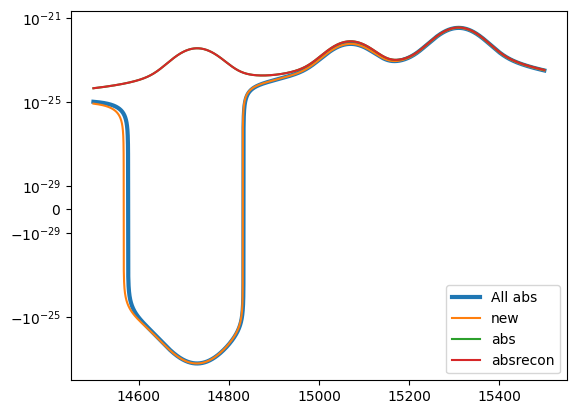

In [7]:
from scipy.special import voigt_profile

wn_grid = np.linspace(14500, 15500, 9991) << 1 / u.cm
n_v_l = 0.4
n_v_u = 0.1
trans_afi_dict = {
    (2, 0): 10,
    (2, 1): 27,
    (3, 0): 16,
}
frac_pop_list = np.array([0.4, 0.2, 0.2, 0.1])
# frac_pop_list /= frac_pop_list.sum()
g_list = [2, 6, 2, 6]
energy_list = [000, 340, 15070, 15310] << 1 / u.cm

all_abs_profiles = np.zeros((len(trans_afi_dict), wn_grid.shape[0]))
abs_profiles = np.zeros((len(trans_afi_dict), wn_grid.shape[0]))
stim_emi_profiles = np.zeros((len(trans_afi_dict), wn_grid.shape[0]))
emi_profiles = np.zeros((len(trans_afi_dict), wn_grid.shape[0]))
sum_b_fi = 0
sum_b_if = 0
for idx, trans in enumerate(trans_afi_dict):
    n_u = n_v_u * frac_pop_list[trans[0]]
    n_l = n_v_l * frac_pop_list[trans[1]]
    # print(n_u, n_l)

    g_u = g_list[trans[0]]
    g_l = g_list[trans[1]]
    energy_trans = energy_list[trans[0]] - energy_list[trans[1]]
    a_fi = trans_afi_dict.get(trans) / u.s
    all_abs_coef = a_fi * ((n_l * g_u / g_l) - n_u) / (energy_trans**2 * 8 * np.pi * ac.c.cgs)
    abs_coef = a_fi * (n_l * g_u / g_l) / (energy_trans**2 * 8 * np.pi * ac.c.cgs)
    stim_emi_coef = a_fi * -n_u / (energy_trans**2 * 8 * np.pi * ac.c.cgs)
    emi_coef = a_fi * n_u * energy_trans * ac.h.cgs * ac.c.cgs / (4 * np.pi)
    print("emi coef unit = ", emi_coef.unit)

    profile = voigt_profile(wn_grid.value - energy_trans.value, 30, 10)
    all_abs_profiles[idx] = all_abs_coef * profile
    abs_profiles[idx] = abs_coef * profile
    stim_emi_profiles[idx] = stim_emi_coef * profile
    emi_profiles[idx] = emi_coef * profile

    trans_freq = (energy_trans << 1 / u.cm).to(u.Hz, equivalencies=u.spectral())
    b_fi = (a_fi * (ac.c**2)) / (2 * ac.h * (trans_freq**3))
    b_fi = b_fi.to(u.m**2 / (u.J * u.s), equivalencies=u.spectral())
    # b_fi = a_fi / (2 * ac.h * ac.c * (energy_trans ** 3))
    sum_b_fi += b_fi
    b_if = b_fi * g_u / g_l
    sum_b_if += b_if

print(sum_b_fi, sum_b_if)

# plt.plot(wn_grid, all_abs_profiles.sum(axis=0))
# plt.plot(wn_grid, abs_profiles.sum(axis=0) + stim_emi_profiles.sum(axis=0))
# plt.plot(wn_grid, abs_profiles.sum(axis=0) - (emi_profiles.sum(axis=0) / wn_grid**3))

n_v_u_new = 0.15
n_v_l_new = 0.3

# plt.plot(wn_grid, (n_v_l_new / n_v_l) * abs_profiles.sum(axis=0) - (n_v_u_new / n_v_u) * (emi_profiles.sum(axis=0) / wn_grid**3))

all_abs_profile = all_abs_profiles.sum(axis=0) << u.cm**2
abs_profile = abs_profiles.sum(axis=0) << u.cm**2
stim_emi_profile = stim_emi_profiles.sum(axis=0) << u.cm**2
emi_profile = emi_profiles.sum(axis=0) << u.cm * u.erg / (u.s * u.sr)
print("emi units = ", emi_profile.unit)

abs_integral = simpson(abs_profile, x=wn_grid) << u.cm**2 * wn_grid.unit
norm_abs_profile = abs_profile / abs_integral

stim_emi_integral = simpson(stim_emi_profile, x=wn_grid) << u.cm**2 * wn_grid.unit
norm_stim_emi_profile = stim_emi_profile / stim_emi_integral

recon_emi_profile = emi_profile / (ac.h.cgs * ac.c.cgs**2 * wn_grid.value**3)
recon_emi_integral = simpson(recon_emi_profile, x=wn_grid) << recon_emi_profile.unit * wn_grid.unit
norm_recon_emi_profile = recon_emi_profile / recon_emi_integral

emi_integral = simpson(emi_profile, x=wn_grid) << emi_profile.unit * wn_grid.unit
norm_emi_profile = emi_profile / emi_integral
print("Normalise emi profile unit = ", norm_emi_profile.unit)

recon_abs = (n_v_l * norm_abs_profile * b_if) - (n_v_u * norm_recon_emi_profile * b_fi)
recon_abs *= (ac.h / (8 * np.pi)) * wn_grid

recon_abs = recon_abs.to(u.cm**2, equivalencies=u.spectral())
print(recon_abs.unit)

new = (n_v_l * norm_abs_profile * sum_b_if) - (n_v_u * norm_emi_profile * sum_b_fi)
new *= (ac.h / (8 * np.pi)) * wn_grid
new = new.to(u.cm**2, equivalencies=u.spectral())

# plt.plot(wn_grid, all_abs_profile, label="All abs", linewidth=3)
# plt.plot(wn_grid, abs_profile + stim_emi_profile, label="abs+stim", linestyle="--", linewidth=2)
# plt.plot(wn_grid, recon_abs, label="reconstructed")
# plt.plot(wn_grid, new, label="new")

all_abs_profiles = np.zeros((len(trans_afi_dict), wn_grid.shape[0]))
abs_profiles = np.zeros((len(trans_afi_dict), wn_grid.shape[0]))
# stim_emi_profiles = np.zeros((len(trans_afi_dict), wn_grid.shape[0]))
# emi_profiles = np.zeros((len(trans_afi_dict), wn_grid.shape[0]))
for idx, trans in enumerate(trans_afi_dict):
    n_u = n_v_u_new * frac_pop_list[trans[0]]
    n_l = n_v_l_new * frac_pop_list[trans[1]]
    g_u = g_list[trans[0]]
    g_l = g_list[trans[1]]
    energy_trans = energy_list[trans[0]] - energy_list[trans[1]]
    a_fi = trans_afi_dict.get(trans) / u.s
    all_abs_coef = a_fi * ((n_l * g_u / g_l) - n_u) / (energy_trans**2 * 8 * np.pi * ac.c.cgs)
    abs_coef = a_fi * (n_l * g_u / g_l) / (energy_trans**2 * 8 * np.pi * ac.c.cgs)
    stim_emi_coef = a_fi * -n_u / (energy_trans**2 * 8 * np.pi * ac.c.cgs)
    emi_coef = a_fi * n_u * energy_trans * ac.h.cgs * ac.c.cgs / (4 * np.pi)

    profile = voigt_profile(wn_grid.value - energy_trans.value, 30, 10)
    all_abs_profiles[idx] = all_abs_coef * profile
    abs_profiles[idx] = abs_coef * profile
    # stim_emi_profiles[idx] = stim_emi_coef * profile
    # emi_profiles[idx] = emi_coef * profile

abs_profile = abs_profiles.sum(axis=0)
abs_profile_integral = simpson(abs_profile, x=wn_grid)
abs_profile_norm = abs_profile / abs_profile_integral

# v_if = (
#     abs_profile_norm
#     * abs_profile_integral
#     * 4
#     * np.pi
#     * u.cm**2
#     / (wn_grid * ac.h)
# )
v_if = (
    abs_profile_norm
    * b_if
)
v_if_integral = simpson(v_if, x=wn_grid) * v_if.unit # * wn_grid.unit
v_if_integral = v_if_integral.to(b_if.unit)
print(f"V_if integral, = {v_if_integral}, B_if = {b_if}, ratio = {v_if_integral/b_if}")

plt.plot(wn_grid, all_abs_profiles.sum(axis=0), label="All abs", linewidth=3)

print("Norm emi unit = ", norm_emi_profile.unit)
r_emi_profile = norm_emi_profile * emi_integral
print("Reconstructed emission profile unit = ", r_emi_profile.unit)
r_stim_emi_profile = u.sr * r_emi_profile / (2 * ac.h.cgs * ac.c.cgs**2 * wn_grid**3)
print(r_stim_emi_profile / stim_emi_profile)
# r_norm_stim_emi_profile = r_stim_emi_profile / (simpson(r_stim_emi_profile, x=wn_grid) << r_stim_emi_profile.unit * wn_grid.unit)
# new = (n_v_l_new * norm_abs_profile * sum_b_if) - (n_v_u_new * r_norm_stim_emi_profile * sum_b_fi)
# new *= (ac.h / (8 * np.pi)) * wn_grid
# new = new.to(u.cm**2, equivalencies=u.spectral())

print("Reconstructed stimulated emission unit = ", r_stim_emi_profile.unit)
new = (n_v_l_new * norm_abs_profile * abs_integral / n_v_l) - (n_v_u_new * r_stim_emi_profile / n_v_u)
# new *= (ac.h / (8 * np.pi)) * wn_grid
# new = new.to(u.cm**2, equivalencies=u.spectral())
plt.plot(wn_grid, new, label="new")
print("Final ratio = ", new / all_abs_profiles.sum(axis=0))
plt.plot(wn_grid, abs_profiles.sum(axis=0), label="abs")
# abs_recon = ((n_v_l_new * norm_abs_profile * sum_b_if) * (ac.h / (8 * np.pi)) * wn_grid).to(u.cm**2, equivalencies=u.spectral())
abs_recon = (n_v_l_new * norm_abs_profile * abs_integral / n_v_l)
plt.plot(wn_grid, abs_recon, label="absrecon")

print(abs_profiles.sum(axis=0) / abs_recon)
print(n_v_l_new / n_v_l)

plt.yscale("symlog", linthresh=1e-29)
plt.legend(loc="best")
plt.show()

emi coef unit =  erg / s
9.338314457793707e-21 cm 9.350458680329921e-21 cm
B abs. unit = m3 / (J s)
7384008.286373406 m2 / (J s) 7354506.14260019 m2 / (J s) 1.0040114377772191


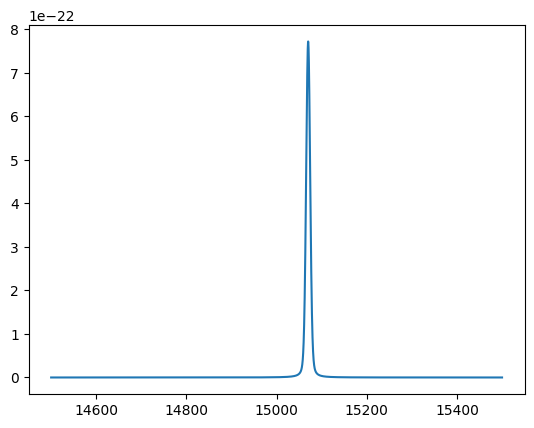

In [54]:
wn_grid = np.linspace(14500, 15500, 9991) << 1 / u.cm
n_v_l = 0.4
n_v_u = 0.1
trans_afi_dict = {
    (2, 0): 10,
    # (2, 1): 27,
    # (3, 0): 16,
}
frac_pop_list = np.array([0.4, 0.2, 0.2, 0.1])
# frac_pop_list /= frac_pop_list.sum()
g_list = [2, 6, 2, 6]
energy_list = [000, 340, 15070, 15310] << 1 / u.cm

all_abs_profiles = np.zeros((len(trans_afi_dict), wn_grid.shape[0]))
abs_profiles = np.zeros((len(trans_afi_dict), wn_grid.shape[0]))
stim_emi_profiles = np.zeros((len(trans_afi_dict), wn_grid.shape[0]))
emi_profiles = np.zeros((len(trans_afi_dict), wn_grid.shape[0]))
sum_b_fi = 0
sum_b_if = 0
sum_all_abs_coef = 0
sum_abs_coef = 0
sum_stim_emi_coef = 0
sum_emi_coef = 0
for idx, trans in enumerate(trans_afi_dict):
    n_u = n_v_u * frac_pop_list[trans[0]]
    n_l = n_v_l * frac_pop_list[trans[1]]
    # print(n_u, n_l)

    g_u = g_list[trans[0]]
    g_l = g_list[trans[1]]
    energy_trans = energy_list[trans[0]] - energy_list[trans[1]]
    a_fi = trans_afi_dict.get(trans) / u.s
    # trans_freq = (energy_trans << 1 / u.cm).to(u.Hz, equivalencies=u.spectral())
    # b_fi = (a_fi * (ac.c**2)) / (2 * ac.h * (trans_freq**3))
    b_fi = a_fi / (2 * ac.h * ac.c * (energy_trans << 1 / u.cm)**3)
    b_fi = b_fi.to(u.m**2 / (u.J * u.s), equivalencies=u.spectral())
    sum_b_fi += b_fi
    b_if = b_fi * g_u / g_l
    sum_b_if += b_if

    all_abs_coef = a_fi * ((n_l * g_u / g_l) - n_u) / (energy_trans**2 * 8 * np.pi * ac.c.cgs)
    # abs_coef = a_fi * (n_l * g_u / g_l) / (energy_trans**2 * 8 * np.pi * ac.c.cgs)
    abs_coef = n_l * b_if * energy_trans * ac.h / (4 * np.pi)
    abs_coef = abs_coef.to(u.cm, equivalencies=u.spectral())
    stim_emi_coef = a_fi * -n_u / (energy_trans**2 * 8 * np.pi * ac.c.cgs)
    emi_coef = a_fi * n_u * energy_trans * ac.h.cgs * ac.c.cgs / (4 * np.pi)
    print("emi coef unit = ", emi_coef.unit)

    profile = voigt_profile(wn_grid.value - energy_trans.value, 4, 1) * u.cm
    all_abs_profiles[idx] = all_abs_coef * profile
    abs_profiles[idx] = abs_coef * profile
    stim_emi_profiles[idx] = stim_emi_coef * profile
    emi_profiles[idx] = emi_coef * profile

    sum_all_abs_coef += all_abs_coef
    sum_abs_coef += abs_coef
    sum_stim_emi_coef += stim_emi_coef
    sum_emi_coef += emi_coef

abs_profile = abs_profiles.sum(axis=0) << u.cm**2

abs_integral = simpson(abs_profile, x=wn_grid) << abs_profile.unit * wn_grid.unit
print(abs_integral, sum_abs_coef)
# print(abs_integral * 4 * np.pi / (ac.h * wn_grid))

# b_abs_profile = abs_profile * 4 * np.pi / (ac.h * wn_grid)
# b_abs_profile = b_abs_profile.to(u.m**3 / (u.J * u.s), equivalencies=u.spectral())
# print(f"B abs. unit = {b_abs_profile.unit}")
# b_abs_integral = simpson(b_abs_profile, x=wn_grid) << b_abs_profile.unit * wn_grid.unit
# b_abs_integral = b_abs_integral.to(u.m**2 / (u.J * u.s), equivalencies=u.spectral())
# print(b_abs_integral, sum_b_if, (b_abs_integral * 2 * np.pi) / sum_b_if, sum_b_if / b_abs_integral)

b_abs_profile = abs_profile * 8 * np.pi**2 / (ac.h * wn_grid)
b_abs_profile = b_abs_profile.to(u.m**3 / (u.J * u.s), equivalencies=u.spectral())
print(f"B abs. unit = {b_abs_profile.unit}")
b_abs_integral = simpson(b_abs_profile, x=wn_grid) << b_abs_profile.unit * wn_grid.unit
b_abs_integral = b_abs_integral.to(u.m**2 / (u.J * u.s), equivalencies=u.spectral())
print(b_abs_integral, sum_b_if, b_abs_integral / sum_b_if)


plt.plot(wn_grid, abs_profile)
plt.show()

In [2]:
@numba.njit(parallel=True)
def bezier_coefficients(
    tau_matrix: npt.NDArray[np.float64],
    source_function_matrix: npt.NDArray[np.float64],
    mu_values: npt.NDArray[np.float64],
) -> t.Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    # New.
    n_layers, n_angles, n_wavelengths = tau_matrix.shape
    coefficients = np.zeros((n_layers + 1, 4, n_angles, n_wavelengths))
    control_points = np.zeros((n_layers, 2, n_angles, n_wavelengths))
    d_s_d_tau_out = np.zeros_like(tau_matrix)
    d_s_d_tau_in = np.zeros_like(tau_matrix)

    coefficients[1:-1, 0, :, :] = tau_matrix[:-1]
    coefficients[1:-1, 0, :, :] -= tau_matrix[1:]
    # tau_plus is delta_tau_matrix[1:], tau_minus is delta_tau_matrix[:-1]

    delta_tau_limit = 1.5e-1
    delta_tau_limit_mask = np.abs(coefficients[:, 0, :, :]) < delta_tau_limit

    delta_tau_sq = coefficients[:, 0, :, :] ** 2
    delta_tau_cube = coefficients[:, 0, :, :] ** 3
    exp_neg_tau = np.exp(-coefficients[:, 0, :, :])

    denom_delta_tau_sq = np.where(delta_tau_sq == 0, 1, delta_tau_sq)

    # TODO: Change indices on delta_tau_matrix based on direction!
    coefficients[:, 1, :, :] = np.where(
        delta_tau_limit_mask,
        (coefficients[:, 0, :, :] / 3) - (delta_tau_sq / 12) + (delta_tau_cube / 60),
        (2 + delta_tau_sq - 2 * coefficients[:, 0, :, :] - 2 * exp_neg_tau) / denom_delta_tau_sq,
    )
    coefficients[:, 2, :, :] = np.where(
        delta_tau_limit_mask,
        (coefficients[:, 0, :, :] / 3) - (delta_tau_sq / 4) + (delta_tau_cube / 10),
        (2 - (2 + 2 * coefficients[:, 0, :, :] + delta_tau_sq) * exp_neg_tau) / denom_delta_tau_sq,
    )
    coefficients[:, 3, :, :] = np.where(
        delta_tau_limit_mask,
        (coefficients[:, 0, :, :] / 3) - (delta_tau_sq / 6) + (delta_tau_cube / 20),
        (2 * coefficients[:, 0, :, :] - 4 + (2 * coefficients[:, 0, :, :] + 4) * exp_neg_tau) / denom_delta_tau_sq,
    )

    # source_func_mu = source_function_matrix[:, None, :] / mu_values[None, :, None]
    source_func_mu = source_function_matrix.reshape(n_layers, 1, n_wavelengths) / mu_values.reshape(1, n_angles, 1)
    min_source_mu = np.fmin(source_func_mu[:-1], source_func_mu[1:])
    max_source_mu = np.fmax(source_func_mu[:-1], source_func_mu[1:])

    # if np.any(min_source_mu < 0):
    #     print(f"WARN: Min source below 0!")
    # if np.any(max_source_mu < 0):
    #     print(f"WARN: Max source below 0!")

    tau_matrix_out_1_diff = tau_matrix[:-1] - tau_matrix[1:]
    d_diff_out = np.where(
        tau_matrix_out_1_diff == 0,
        0,
        (source_func_mu[:-1] - source_func_mu[1:]) / tau_matrix_out_1_diff,
    )
    zeta_out_denominator = tau_matrix[:-2] - tau_matrix[2:]
    zeta_out = np.where(
        zeta_out_denominator == 0,
        1 / 3,
        (1 + (tau_matrix[:-2] - tau_matrix[1:-1]) / zeta_out_denominator) / 3,
    )
    d_s_d_tau_out_numerator = d_diff_out[1:] * d_diff_out[:-1]
    d_s_d_tau_out_denominator = (zeta_out * d_diff_out[:-1]) + ((1 - zeta_out) * d_diff_out[1:])
    d_s_d_tau_out[1:-1] = np.where(
        (d_s_d_tau_out_numerator < 0) | (d_s_d_tau_out_denominator == 0),
        # d_s_d_tau_out_denominator == 0,
        0,
        d_s_d_tau_out_numerator / d_s_d_tau_out_denominator,
    )

    control_0_out = source_func_mu[1:] + 0.5 * tau_matrix_out_1_diff * d_s_d_tau_out[1:]
    control_1_out = source_func_mu[:-1] - 0.5 * tau_matrix_out_1_diff * d_s_d_tau_out[:-1]

    control_0_out = np.fmax(control_0_out, min_source_mu)
    control_0_out = np.fmin(control_0_out, max_source_mu)
    control_1_out = np.fmax(control_1_out, min_source_mu)
    control_1_out = np.fmin(control_1_out, max_source_mu)

    control_points[2:, 0, :, :] = 0.5 * (control_0_out[1:] + control_1_out[1:])
    control_points[1, 0, :, :] = control_0_out[0]

    tau_matrix_in_1_diff = tau_matrix[1:] - tau_matrix[:-1]
    d_diff_in = np.where(
        tau_matrix_in_1_diff == 0,
        0,
        (source_func_mu[1:] - source_func_mu[:-1]) / tau_matrix_in_1_diff,
    )
    zeta_in_denominator = tau_matrix[2:] - tau_matrix[:-2]
    zeta_in = np.where(
        zeta_in_denominator == 0,
        1 / 3,
        (1 + (tau_matrix[2:] - tau_matrix[1:-1]) / (zeta_in_denominator)) / 3,
    )
    d_s_d_tau_in_numerator = d_diff_in[:-1] * d_diff_in[1:]
    d_s_d_tau_in_denominator = (zeta_in * d_diff_in[1:]) + ((1 - zeta_in) * d_diff_in[:-1])
    d_s_d_tau_in[1:-1] = np.where(
        (d_s_d_tau_in_numerator < 0) | (d_s_d_tau_in_denominator == 0),
        # d_s_d_tau_in_denominator == 0,
        0,
        d_s_d_tau_in_numerator / d_s_d_tau_in_denominator,
    )

    control_0_in = source_func_mu[:-1] + 0.5 * tau_matrix_in_1_diff * d_s_d_tau_in[:-1]
    control_1_in = source_func_mu[1:] - 0.5 * tau_matrix_in_1_diff * d_s_d_tau_in[1:]

    control_0_in = np.fmax(control_0_in, min_source_mu)
    control_0_in = np.fmin(control_0_in, max_source_mu)
    control_1_in = np.fmax(control_1_in, min_source_mu)
    control_1_in = np.fmin(control_1_in, max_source_mu)

    control_points[:-2, 1, :, :] = 0.5 * (control_0_in[:-1] + control_1_in[:-1])
    control_points[-2, 1, :, :] = control_0_in[-1]

    return coefficients, control_points


@numba.njit(parallel=True)
def bezier_coefficients_new(
    tau_matrix: npt.NDArray[np.float64],
    source_function_matrix: npt.NDArray[np.float64],
    mu_values: npt.NDArray[np.float64],
) -> t.Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    # New.
    n_layers, n_angles, n_wavelengths = tau_matrix.shape
    coefficients = np.zeros((n_layers + 1, 4, n_angles, n_wavelengths))
    control_points = np.zeros((n_layers, 2, n_angles, n_wavelengths))
    d_s_d_tau_out = np.zeros_like(tau_matrix)
    d_s_d_tau_in = np.zeros_like(tau_matrix)

    # coefficients[1:-1, 0, :, :] = tau_matrix[:-1]
    # coefficients[1:-1, 0, :, :] -= tau_matrix[1:]
    coefficients[1:, 0, :, :] = tau_matrix
    coefficients[:-1, 0, :, :] -= tau_matrix
    # tau_plus is delta_tau_matrix[1:], tau_minus is delta_tau_matrix[:-1]

    delta_tau_limit = 1.5e-1
    delta_tau_limit_mask = np.abs(coefficients[:, 0, :, :]) < delta_tau_limit

    delta_tau_sq = coefficients[:, 0, :, :] ** 2
    delta_tau_cube = coefficients[:, 0, :, :] ** 3
    exp_neg_tau = np.exp(-coefficients[:, 0, :, :])

    denom_delta_tau_sq = np.where(delta_tau_sq == 0, 1, delta_tau_sq)

    # TODO: Change indices on delta_tau_matrix based on direction!
    coefficients[:, 1, :, :] = np.where(
        delta_tau_limit_mask,
        (coefficients[:, 0, :, :] / 3) - (delta_tau_sq / 12) + (delta_tau_cube / 60),
        (2 + delta_tau_sq - 2 * coefficients[:, 0, :, :] - 2 * exp_neg_tau) / denom_delta_tau_sq,
    )
    coefficients[:, 2, :, :] = np.where(
        delta_tau_limit_mask,
        (coefficients[:, 0, :, :] / 3) - (delta_tau_sq / 4) + (delta_tau_cube / 10),
        (2 - (2 + 2 * coefficients[:, 0, :, :] + delta_tau_sq) * exp_neg_tau) / denom_delta_tau_sq,
    )
    coefficients[:, 3, :, :] = np.where(
        delta_tau_limit_mask,
        (coefficients[:, 0, :, :] / 3) - (delta_tau_sq / 6) + (delta_tau_cube / 20),
        (2 * coefficients[:, 0, :, :] - 4 + (2 * coefficients[:, 0, :, :] + 4) * exp_neg_tau) / denom_delta_tau_sq,
    )

    # source_func_mu = source_function_matrix[:, None, :] / mu_values[None, :, None]
    # source_func_mu = source_function_matrix.reshape(n_layers, 1, n_wavelengths) / mu_values.reshape(1, n_angles, 1)
    source_func_mu = source_function_matrix.reshape(n_layers, 1, n_wavelengths) * np.ones((1, n_angles, 1))
    min_source_mu = np.fmin(source_func_mu[:-1], source_func_mu[1:])
    max_source_mu = np.fmax(source_func_mu[:-1], source_func_mu[1:])

    # if np.any(min_source_mu < 0):
    #     print(f"WARN: Min source below 0!")
    # if np.any(max_source_mu < 0):
    #     print(f"WARN: Max source below 0!")

    tau_matrix_out_1_diff = tau_matrix[:-1] - tau_matrix[1:]
    d_diff_out = np.where(
        tau_matrix_out_1_diff == 0,
        0,
        (source_func_mu[:-1] - source_func_mu[1:]) / tau_matrix_out_1_diff,
    )
    zeta_out_denominator = tau_matrix[:-2] - tau_matrix[2:]
    zeta_out = np.where(
        zeta_out_denominator == 0,
        1 / 3,
        (1 + (tau_matrix[:-2] - tau_matrix[1:-1]) / zeta_out_denominator) / 3,
    )
    d_s_d_tau_out_numerator = d_diff_out[1:] * d_diff_out[:-1]
    d_s_d_tau_out_denominator = (zeta_out * d_diff_out[:-1]) + ((1 - zeta_out) * d_diff_out[1:])
    d_s_d_tau_out[1:-1] = np.where(
        (d_s_d_tau_out_numerator < 0) | (d_s_d_tau_out_denominator == 0),
        # d_s_d_tau_out_denominator == 0,
        0,
        d_s_d_tau_out_numerator / d_s_d_tau_out_denominator,
    )

    control_0_out = source_func_mu[1:] + 0.5 * tau_matrix_out_1_diff * d_s_d_tau_out[1:]
    control_1_out = source_func_mu[:-1] - 0.5 * tau_matrix_out_1_diff * d_s_d_tau_out[:-1]

    control_0_out = np.fmax(control_0_out, min_source_mu)
    control_0_out = np.fmin(control_0_out, max_source_mu)
    control_1_out = np.fmax(control_1_out, min_source_mu)
    control_1_out = np.fmin(control_1_out, max_source_mu)

    control_points[2:, 0, :, :] = 0.5 * (control_0_out[1:] + control_1_out[1:])
    control_points[1, 0, :, :] = control_1_out[0]

    # control_points[1:, 0, :, :] = np.fmax(control_points[1:, 0, :, :], 0)
    control_points[1:, 0, :, :] = np.where(
        (coefficients[1:-1, 3, :, :] > 0) & (control_points[1:, 0, :, :] < 0),
        0,
        control_points[1:, 0, :, :],
    )

    tau_matrix_in_1_diff = tau_matrix[1:] - tau_matrix[:-1]
    d_diff_in = np.where(
        tau_matrix_in_1_diff == 0,
        0,
        (source_func_mu[1:] - source_func_mu[:-1]) / tau_matrix_in_1_diff,
    )
    zeta_in_denominator = tau_matrix[2:] - tau_matrix[:-2]
    zeta_in = np.where(
        zeta_in_denominator == 0,
        1 / 3,
        (1 + (tau_matrix[2:] - tau_matrix[1:-1]) / zeta_in_denominator) / 3,
    )
    d_s_d_tau_in_numerator = d_diff_in[:-1] * d_diff_in[1:]
    d_s_d_tau_in_denominator = (zeta_in * d_diff_in[1:]) + ((1 - zeta_in) * d_diff_in[:-1])
    d_s_d_tau_in[1:-1] = np.where(
        (d_s_d_tau_in_numerator < 0) | (d_s_d_tau_in_denominator == 0),
        # d_s_d_tau_in_denominator == 0,
        0,
        d_s_d_tau_in_numerator / d_s_d_tau_in_denominator,
    )

    control_0_in = source_func_mu[:-1] + 0.5 * tau_matrix_in_1_diff * d_s_d_tau_in[:-1]
    control_1_in = source_func_mu[1:] - 0.5 * tau_matrix_in_1_diff * d_s_d_tau_in[1:]

    control_0_in = np.fmax(control_0_in, min_source_mu)
    control_0_in = np.fmin(control_0_in, max_source_mu)
    control_1_in = np.fmax(control_1_in, min_source_mu)
    control_1_in = np.fmin(control_1_in, max_source_mu)

    control_points[:-2, 1, :, :] = 0.5 * (control_0_in[:-1] + control_1_in[:-1])
    control_points[-2, 1, :, :] = control_1_in[-1]

    # control_points[:-1, 1, :, :] = np.fmax(control_points[:-1, 1, :, :], 0)
    control_points[:-1, 1, :, :] = np.where(
        (coefficients[1:-1, 3, :, :] > 0) & (control_points[:-1, 1, :, :] < 0),
        0,
        control_points[:-1, 1, :, :],
    )
    # control_points[:-1, 1, :, :] = np.fmax(control_points[:-1, 1, :, :], min_source_mu)
    # control_points[:-1, 1, :, :] = np.fmin(control_points[:-1, 1, :, :], max_source_mu)

    return coefficients, control_points



def effective_source_tau_mu(
    # global_source_func_matrix: u.Quantity,
    global_chi_matrix: u.Quantity,
    global_eta_matrix: u.Quantity,
    density_profile: u.Quantity,
    dz_profile: u.Quantity,
    mu_values: npt.NDArray[np.float64],
    negative_absorption_factor: float = 0.1,
) -> t.Tuple[u.Quantity, npt.NDArray[np.float64]]:
    # log.info(f"Any global chi negative? {np.any(global_chi_matrix < 0)}")
    # log.info(f"Any global eta negative? {np.any(global_eta_matrix < 0)}")
    effective_chi = np.where(
        global_chi_matrix < 0, negative_absorption_factor * abs(global_chi_matrix), global_chi_matrix
    )
    # log.info(f"Any effective eta negative? {np.any(global_eta < 0)}")
    effective_source_func_matrix = (global_eta_matrix * density_profile[:, None] / (ac.c.cgs * effective_chi)).to(
        u.J / (u.sr * u.m**2), equivalencies=u.spectral()
    )
    # log.info(f"Any effective S negative? {np.any(effective_source_func_matrix < 0)}")
    res = effective_chi * dz_profile[:, None]
    dtau = res.decompose().value
    tau = dtau[::-1].cumsum(axis=0)[::-1]
    tau_mu = tau[:, None, :] / mu_values[None, :, None]
    return effective_source_func_matrix, tau_mu

def bezier_debug(
    layer_idx: int,
    i_matrix: u.Quantity,
    lambda_matrix: npt.NDArray[np.float64],
    direction: str,
    bezier_coefs: npt.NDArray[np.float64],
    control_points: npt.NDArray[np.float64],
) -> None:
    if not np.all(i_matrix[layer_idx] >= 0) or not np.all(lambda_matrix[layer_idx] >= 0):
        coefs_check_idx = layer_idx if direction == "out" else layer_idx + 1
        control_point_idx = 0 if direction == "out" else 1
        also_check_idx = layer_idx - 1 if direction == "out" else layer_idx + 1
        # if not np.all(i_matrix[layer_idx] >= 0):
        #     print(f"[L{layer_idx}] Warn: {direction} INTENSITY BEZIER BAD :(")
        #     print(f"Negative intensities in previous layer? {np.any(i_matrix[also_check_idx] < 0)}")
        # if not np.all(lambda_matrix[layer_idx] >= 0):
        #     print(f"[L{layer_idx}] Warn: {direction} LAMBDA BEZIER BAD :(")
        # print("delta = ", bezier_coefs[coefs_check_idx, 0])
        # if np.any(bezier_coefs[coefs_check_idx, 0] < 0):
        #     print(f"[L{layer_idx}] Warn: Negative deltas!")
        # print("alpha = ", bezier_coefs[coefs_check_idx, 1])
        # if np.any(bezier_coefs[coefs_check_idx, 1] < 0):
        #     print(f"[L{layer_idx}] Warn: Negative alphas!")
        # print("beta = ", bezier_coefs[coefs_check_idx, 2])
        # if np.any(bezier_coefs[coefs_check_idx, 2] < 0):
        #     print(f"[L{layer_idx}] Warn: Negative betas!")
        # print("gamma = ", bezier_coefs[coefs_check_idx, 3])
        # if np.any(bezier_coefs[coefs_check_idx, 3] < 0):
        #     print(f"[L{layer_idx}] Warn: Negative gammas!")
        # print("C = ", control_points[layer_idx, control_point_idx])
        # if np.any(control_points[layer_idx, control_point_idx] < 0):
        #     print(f"[L{layer_idx}] Warn: Negative C!")


def formal_solve_general(dtau: u.Quantity, source_function: u.Quantity, mu_values: npt.NDArray[np.float64], surface_albedo: float = 0):
    """
    Calculates the up- and down-welling intensity at each layer interface
    for a general (optically thick or thin) atmosphere.
    Convention: index 0 is the Bottom of the Atmosphere (BOA).

    Args:
        dtau (u.Quantity): Optical depth of each layer. Shape (n_layers, n_wavelengths).
        source_function (u.Quantity): Source function in each layer. Shape (n_layers, n_wavelengths).
        mu_values (np.ndarray): Array of mu cosines (must contain positive and negative values).

    Returns:
        Tuple[u.Quantity, u.Quantity]:
            - I_up: Up-welling intensity at the top interface of each layer. Shape (n_mu_up, n_layers+1, n_wavelengths).
            - I_down: Down-welling intensity at the top interface of each layer. Shape (n_mu_down, n_layers+1, n_wavelengths).
    """
    n_layers, n_wavelengths = dtau.shape

    # Intensity is at the interfaces, so n_layers + 1 levels.
    # Level 0 is BOA, Level n_layers is TOA.
    I_up = np.zeros((len(mu_values), n_layers + 1, n_wavelengths)) * source_function.unit
    I_down = np.zeros((len(mu_values), n_layers + 1, n_wavelengths)) * source_function.unit

    # --- Down-welling Calculation (I_down) ---
    # Boundary condition at the top (level n_layers) is zero.
    I_down[:, n_layers, :] = 0.0 * source_function.unit

    # Integrate from TOA (k=n_layers-1) down to BOA (k=0)
    for k in range(n_layers - 1, -1, -1):
        # Use abs(mu) for path length
        delta_tau_mu = dtau[k, :] / np.abs(mu_values[:, None])
        exp_term = np.exp(-delta_tau_mu)
        source_contribution = source_function[k, :] * (1 - exp_term)

        # Intensity at the top interface of the layer (level k)
        I_down[:, k, :] = I_down[:, k + 1, :] * exp_term + source_contribution

    # --- 2. Define the Bottom Boundary Condition ---
    # Calculate down-welling flux at the surface (level 0)
    # The integral of 2 * pi * I * mu * d(mu) from -1 to 0
    # Note: mu_weights from leggauss are for an integral from -1 to 1.
    # We are only integrating over the downward hemisphere.
    downward_flux = 2 * np.pi * (I_down[:, 0, :] * mu_values[:, None] * mu_weights[mu_weights > 0, None]).sum(axis=0)

    # Reflected intensity is diffuse (same in all directions)
    # reflected_intensity = surface_albedo * downward_flux / np.pi

    # Total surface emission (level 0)
    # Use a Planck function calculator for thermal emission
    # from astropy.modeling.models import BlackBody
    # bb = BlackBody(surface_temperature)
    # thermal_emission = bb(dtau.shape[1] * u.nm) # Example wavelength
    # thermal_emission = source_function[-1] * surface_emissivity # Placeholder
    # surface_emission = thermal_emission + reflected_intensity
    surface_emission = source_function[0, :]  # USE THIS IN PROD!

    # --- Up-welling Calculation (I_up) ---
    # Boundary condition at the bottom (level 0).
    # This is the intensity entering the lowest layer from below.
    # We'll use the source function of the bottom layer as the surface emission.
    I_up[:, 0, :] = surface_emission

    # Integrate from BOA (k=0) to TOA (k=n_layers-1)
    for k in range(n_layers):
        delta_tau_mu = dtau[k, :] / mu_values[:, None]
        exp_term = np.exp(-delta_tau_mu)
        source_contribution = source_function[None, k, :] * (1 - exp_term)

        # Intensity at the top of the layer (level k+1)
        I_up[:, k + 1, :] = I_up[:, k, :] * exp_term + source_contribution

    return I_up, I_down

In [3]:
n_layers = 5
n_wn = 5
n_angular_points = 3
mu_values, mu_weights = np.polynomial.legendre.leggauss(n_angular_points)
mu_values, mu_weights = (mu_values + 1) * 0.5, mu_weights / 2
global_chi_matrix = np.random.rand(n_layers, n_wn) << u.cm**2
global_chi_matrix[2, 3] *= -0.1
global_chi_matrix[1, 4] *= -0.1
global_eta_matrix = np.random.rand(n_layers, n_wn) << u.erg * u.cm / (u.s * u.sr)
density_profile = np.random.rand(n_layers) * 1e5 / u.m**3
dz_profile = np.random.rand(n_layers) * 1e6 << u.m
# source_func_matrix = global_eta_matrix / global_chi_matrix
source_func_matrix = (global_eta_matrix / (ac.c * global_chi_matrix)).to(u.J / (u.sr * u.m ** 2), equivalencies=u.spectral())
source_func_negative_cap = source_func_matrix.max()
source_func_matrix[source_func_matrix < -source_func_negative_cap] = -source_func_negative_cap

res = global_chi_matrix * dz_profile[:, None]
dtau = res.decompose().value
tau = dtau[::-1].cumsum(axis=0)[::-1]
tau_mu = tau[:, None, :] / mu_values[None, :, None]

In [4]:
bezier_coefs, control_points = bezier_coefficients_new(
    tau_matrix=tau_mu,
    source_function_matrix=source_func_matrix.value,
    mu_values=mu_values,
)
control_points = control_points << source_func_matrix.unit

TEST L4 is n_layers - 1
Exp term =  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]] J / (sr m2)
Sum term =  [[1.87026839e-14 2.25344166e-13 3.08651720e-14 2.91341049e-14
  4.46654293e-15]
 [1.83295965e-14 1.96128782e-13 3.05214705e-14 2.86495351e-14
  4.38763828e-15]
 [1.79723140e-14 1.78334787e-13 3.01856787e-14 2.81819043e-14
  4.31167267e-15]] J / (sr m2)
Control term =  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]] J / (sr m2)
TEST L3
I (in) =  [[5.22376004e-14 5.17194013e-14 3.89673868e-14 2.95198470e-14
  8.25693359e-14]
 [5.11931885e-14 5.99864186e-14 3.88114787e-14 2.95161644e-14
  7.32006396e-14]
 [5.01828000e-14 6.78601755e-14 3.86586878e-14 2.95125392e-14
  6.51699228e-14]] J / (sr m2)
Exp term =  [[1.92256773e-108 1.75389393e-078 6.79733640e-166 1.53133008e-208
  2.83988327e-038]
 [1.19657418e-035 4.13800736e-028 1.99794363e-048 4.63349665e-058
  2.59193380e-020]
 [2.07281198e-026 9.57918802e-022 1.64747858e-033 5.93279817e-039
  4.87845441e-018]] J / (sr m2

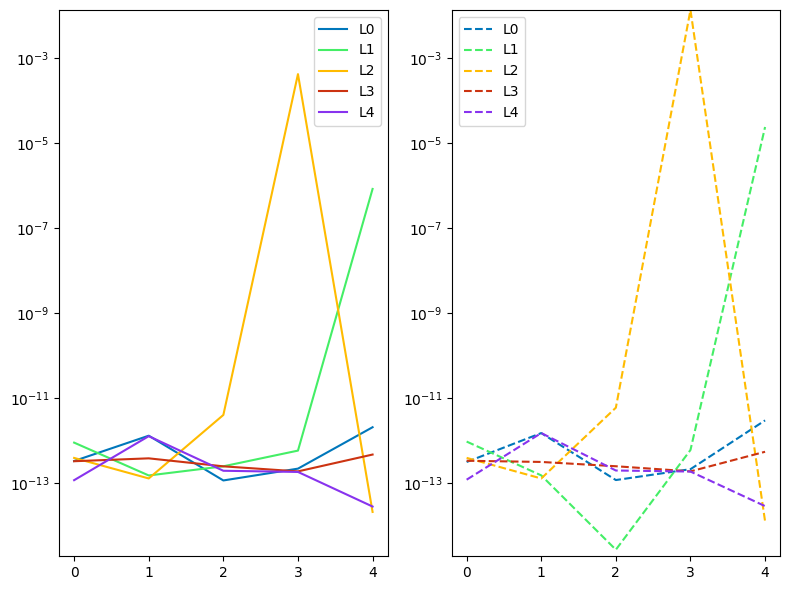

In [5]:
# print(bezier_coefs.shape)
incident_radiation_field = None
# i_in_matrix = np.zeros_like(tau_mu) << source_func_matrix.unit
i_in_matrix = np.zeros((n_layers + 1, n_angular_points, n_wn)) << source_func_matrix.unit
lambda_in_matrix = np.zeros_like(tau_mu)
# print(i_in_matrix.shape)

do_tridiag = True
for layer_idx in range(n_layers + 1)[::-1]:
    if layer_idx == n_layers:
        if incident_radiation_field is not None:
            i_in_matrix[layer_idx] = incident_radiation_field
    # elif layer_idx == 0 or layer_idx == n_layers - 2:
    #     # Parabolic:
    #     i_in_matrix[layer_idx] = (
    #             i_in_matrix[layer_idx + 1] * np.exp(-tau_plus_matrix[layer_idx])
    #             + np.sum(plus_coefficients[layer_idx, :2]
    #                      * self.global_source_func_matrix[layer_idx:layer_idx + 2][::-1, None, :], axis=0)
    #     )
    #     # log.info("I in (parabolic) = ", i_in_matrix[layer_idx], "All positive? ",
    #     #       np.all(i_in_matrix[layer_idx] >= 0))
    #     if not np.all(i_in_matrix[layer_idx] >= 0):
    #         log.warning("IN PARABOLIC BAD")
    #     # Diagonal: (gamma_plus is 0 in FOSC).
    #     # lambda_in_matrix[layer_idx] = plus_coefficients[layer_idx, 1]
    #     # Tridiagonal:
    #     # lambda_in_matrix[layer_idx] = (
    #     #         plus_coefficients[layer_idx, 0] +
    #     #         plus_coefficients[layer_idx, 1] * (1 + np.exp(-tau_plus_matrix[layer_idx]))
    #     # )
    #     lambda_in_matrix[layer_idx] = (
    #             plus_coefficients[layer_idx - 1, 0] +
    #             plus_coefficients[layer_idx, 1] * (1 + np.exp(-tau_plus_matrix[layer_idx - 1]))
    #     )
    #     # Switch to digonal if negative! If doesn't work, try FOSC.
    #     # lambda_in_matrix[layer_idx] = np.where(
    #     #     lambda_in_matrix[layer_idx] < 0,
    #     #     plus_coefficients[layer_idx, 1],
    #     #     lambda_in_matrix[layer_idx]
    #     # )
    #     # Bezier:
    #     i_in_matrix[layer_idx] = (
    #             i_in_matrix[layer_idx + 1] * np.exp(-bezier_coefs[layer_idx + 1, 0])
    #             + np.sum(bezier_coefs[layer_idx + 1, 1:3]
    #                      * self.global_source_func_matrix[layer_idx:layer_idx + 2][:, None, :], axis=0)
    #             + bezier_coefs[layer_idx + 1, 3] * control_points[layer_idx, 1]
    #     )
    #     # log.info("I in (Bezier) = ", i_in_matrix[layer_idx], "All positive? ", np.all(i_in_matrix[layer_idx] >= 0))
    #     if not np.all(i_in_matrix[layer_idx] >= 0):
    #         log.warning("IN BEZIER BAD :(")
    elif layer_idx == n_layers - 1:
        i_in_matrix[layer_idx] = (
            i_in_matrix[layer_idx + 1] * np.exp(-bezier_coefs[layer_idx + 1, 0])
            + np.sum(
                bezier_coefs[layer_idx + 1, 1:3]
                * source_func_matrix[layer_idx : layer_idx + 2][:, None, :],
                axis=0,
            )
            + bezier_coefs[layer_idx + 1, 3] * control_points[layer_idx, 1]
        )
        print(f"TEST L{layer_idx} is n_layers - 1")
        print("Exp term = ", i_in_matrix[layer_idx + 1] * np.exp(-bezier_coefs[layer_idx + 1, 0]))
        print("Sum term = ", np.sum(
                bezier_coefs[layer_idx + 1, 1:3]
                * source_func_matrix[layer_idx : layer_idx + 2][:, None, :],
                axis=0,
            ))
        print("Control term = ", bezier_coefs[layer_idx + 1, 3] * control_points[layer_idx, 1])
        if do_tridiag:
            lambda_in_matrix[layer_idx] = (
                (bezier_coefs[layer_idx + 1, 1] + bezier_coefs[layer_idx + 1, 3])
                * (1 + np.exp(-bezier_coefs[layer_idx, 0]))
                + bezier_coefs[layer_idx, 2]
                # + bezier_coefs[layer_idx, 3]
            )
        else:
            lambda_in_matrix[layer_idx] = bezier_coefs[layer_idx + 1, 1] + bezier_coefs[layer_idx + 1, 3]
        if not np.all(i_in_matrix[layer_idx] >= 0) or not np.all(lambda_in_matrix[layer_idx] >= 0):
            bezier_debug(
                layer_idx,
                i_in_matrix,
                lambda_in_matrix,
                "in",
                bezier_coefs,
                control_points,
            )
    elif layer_idx == 0:
        i_in_matrix[layer_idx] = (
            i_in_matrix[layer_idx + 1] * np.exp(-bezier_coefs[layer_idx + 1, 0])
            + np.sum(
                bezier_coefs[layer_idx + 1, 1:3]
                * source_func_matrix[layer_idx : layer_idx + 2][:, None, :],
                axis=0,
            )
            + bezier_coefs[layer_idx + 1, 3] * control_points[layer_idx, 1]
        )
        print(f"TEST L{layer_idx}")
        print("Exp term = ", i_in_matrix[layer_idx + 1] * np.exp(-bezier_coefs[layer_idx + 1, 0]))
        print("Sum term = ", np.sum(
                bezier_coefs[layer_idx + 1, 1:3]
                * source_func_matrix[layer_idx : layer_idx + 2][:, None, :],
                axis=0,
            ))
        print("Control term = ", bezier_coefs[layer_idx + 1, 3] * control_points[layer_idx, 1])
        lambda_in_matrix[layer_idx] = bezier_coefs[layer_idx + 1, 1] + bezier_coefs[layer_idx + 1, 3]
        if not np.all(i_in_matrix[layer_idx] >= 0) or not np.all(lambda_in_matrix[layer_idx] >= 0):
            bezier_debug(
                layer_idx,
                i_in_matrix,
                lambda_in_matrix,
                "in",
                bezier_coefs,
                control_points,
            )
    else:
        # # Parabolic:
        # i_in_matrix[layer_idx] = (
        #         i_in_matrix[layer_idx + 1] * np.exp(-tau_plus_matrix[layer_idx])
        #         + np.sum(plus_coefficients[layer_idx]
        #                  * self.global_source_func_matrix[layer_idx - 1:layer_idx + 2][::-1, None, :], axis=0)
        # )
        #
        # # Diagonal only: (exp term was alpha previously)
        # # lambda_in_matrix[layer_idx] = (plus_coefficients[layer_idx, 1]
        # #                                + plus_coefficients[layer_idx, 2] * np.exp(-tau_plus_matrix[layer_idx]))
        # # Tridiagonal:
        # # lambda_in_matrix[layer_idx] = (
        # #         plus_coefficients[layer_idx, 0] +
        # #         plus_coefficients[layer_idx, 1] * (1 + np.exp(-tau_plus_matrix[layer_idx])) +
        # #         plus_coefficients[layer_idx, 2] * (
        # #                 1 + np.exp(-tau_plus_matrix[layer_idx]) + np.exp(-2 * tau_plus_matrix[layer_idx]))
        # # )
        # lambda_in_matrix[layer_idx] = (
        #         plus_coefficients[layer_idx - 1, 0] +
        #         plus_coefficients[layer_idx, 1] * (1 + np.exp(-tau_plus_matrix[layer_idx - 1])) +
        #         plus_coefficients[layer_idx + 1, 2] * (
        #                 1 + np.exp(-tau_plus_matrix[layer_idx])
        #                 + np.exp(-tau_plus_matrix[layer_idx] - tau_plus_matrix[layer_idx - 1]))
        # )
        # # Bezier:
        i_in_matrix[layer_idx] = (
            i_in_matrix[layer_idx + 1] * np.exp(-bezier_coefs[layer_idx + 1, 0])
            + np.sum(
                bezier_coefs[layer_idx + 1, 1:3]
                * source_func_matrix[layer_idx : layer_idx + 2][:, None, :],
                axis=0,
            )
            + bezier_coefs[layer_idx + 1, 3] * control_points[layer_idx, 1]
        )
        print(f"TEST L{layer_idx}")
        print("I (in) = ", i_in_matrix[layer_idx])
        print("Exp term = ", i_in_matrix[layer_idx + 1] * np.exp(-bezier_coefs[layer_idx + 1, 0]))
        print("Sum term = ", np.sum(
                bezier_coefs[layer_idx + 1, 1:3]
                * source_func_matrix[layer_idx : layer_idx + 2][:, None, :],
                axis=0,
            ))
        print("Control term = ", bezier_coefs[layer_idx + 1, 3] * control_points[layer_idx, 1])
        ##
        print("Delta (1off) = ", bezier_coefs[layer_idx + 1, 0])
        print("Delta = ", bezier_coefs[layer_idx, 0])
        print("Alpha = ", bezier_coefs[layer_idx + 1, 1])
        print("Beta = ", bezier_coefs[layer_idx + 1, 2])
        print("Gamma = ", bezier_coefs[layer_idx + 1, 3])
        print("alpha*S_k = ", bezier_coefs[layer_idx + 1, 1] * source_func_matrix[layer_idx][None, :])
        print("beta*S_k-1 = ", bezier_coefs[layer_idx + 1, 2] * source_func_matrix[layer_idx + 1][None, :])
        # if layer_idx == 1:
        #     delta_tau = tau_mu[layer_idx] - tau_mu[layer_idx + 1]
        #     delta_tau_limit = 1.5e-1
        #     delta_tau_limit_mask = delta_tau < delta_tau_limit
        #     delta_tau_sq = delta_tau ** 2
        #     delta_tau_cube = delta_tau ** 3
        #     exp_neg_tau = np.exp(-delta_tau)
        #     denom_delta_tau_sq = np.where(delta_tau_sq == 0, 1, delta_tau_sq)
        #     alpha = np.where(
        #         delta_tau_limit_mask,
        #         (delta_tau / 3) - (delta_tau_sq / 12) + (delta_tau_cube / 60),
        #         (2 + delta_tau_sq - 2 * delta_tau - 2 * exp_neg_tau) / denom_delta_tau_sq,
        #     )
        #     beta = np.where(
        #         delta_tau_limit_mask,
        #         (delta_tau / 3) - (delta_tau_sq / 4) + (delta_tau_cube / 10),
        #         (2 - (2 + 2 * delta_tau + delta_tau_sq) * exp_neg_tau) / denom_delta_tau_sq,
        #     )
        #     gamma = np.where(
        #         delta_tau_limit_mask,
        #         (delta_tau / 3) - (delta_tau_sq / 6) + (delta_tau_cube / 20),
        #         (2 * delta_tau - 4 + (2 * delta_tau + 4) * exp_neg_tau) / denom_delta_tau_sq,
        #     )
        #     print(f"Test alpha = {alpha}")
        #     print("Alpha here = ", bezier_coefs[layer_idx + 1, 1])
        #     print(f"Test beta = {beta}")
        #     print("Beta here = ", bezier_coefs[layer_idx + 1, 2])
        #     print(f"Test gamma = {gamma}")
        #     print("Gamma here = ", bezier_coefs[layer_idx + 1, 3])
        #     source_func_mu = source_func_matrix.reshape(n_layers, 1, n_wn) / mu_values.reshape(1, n_angular_points, 1)
        #     source_func_mu = source_func_mu.value
        #     min_source_mu = np.fmin(source_func_mu[:-1], source_func_mu[1:])
        #     max_source_mu = np.fmax(source_func_mu[:-1], source_func_mu[1:])
        #
        #     tau_matrix_in_1_diff = tau_mu[1:] - tau_mu[:-1]
        #     # tau_matrix_in_1_diff = tau_mu[layer_idx + 1] - tau_mu[layer_idx]
        #     # tau_matrix_in_1_diff = tau_mu[layer_idx] - tau_mu[layer_idx + 1]
        #     print(tau_matrix_in_1_diff)
        #     print(delta_tau)
        #     d_in = np.where(
        #         tau_matrix_in_1_diff == 0,
        #         0,
        #         (source_func_mu[1:] - source_func_mu[:-1]) / tau_matrix_in_1_diff,
        #     )
        #     d_diff_in_new = np.where(
        #         delta_tau == 0,
        #         0,
        #         (source_func_mu[layer_idx] - source_func_mu[layer_idx + 1]) / delta_tau,
        #     )
        #     print(f"D diff in old = {d_in[layer_idx]}")
        #     print(f"D diff in new = {d_diff_in_new}")
        #     zeta_in_denominator = tau_mu[2:] - tau_mu[:-2]
        #     zeta_in = np.where(
        #         zeta_in_denominator == 0,
        #         1 / 3,
        #         (1 + (tau_mu[2:] - tau_mu[1:-1]) / zeta_in_denominator) / 3,
        #     )
        #     print("Zeta in? ", zeta_in)
        #     d_s_d_tau_in = np.zeros_like(tau_mu)
        #
        #     d_s_d_tau_in_numerator = d_in[:-1] * d_in[1:]
        #     d_s_d_tau_in_denominator = (zeta_in * d_in[1:]) + ((1 - zeta_in) * d_in[:-1])
        #     d_s_d_tau_in[1:-1] = np.where(
        #         # (d_s_d_tau_in_numerator < 0) | (d_s_d_tau_in_denominator == 0),
        #         d_s_d_tau_in_denominator == 0,
        #         0,
        #         d_s_d_tau_in_numerator / d_s_d_tau_in_denominator,
        #     )
        #     print("ds/dtau old = ", d_s_d_tau_in)
        #
        #     d_back = (source_func_mu[layer_idx + 1] - source_func_mu[layer_idx]) / (tau_mu[layer_idx + 1] - tau_mu[layer_idx])
        #     d_front = (source_func_mu[layer_idx] - source_func_mu[layer_idx - 1]) / (tau_mu[layer_idx] - tau_mu[layer_idx - 1])
        #     print("d_back = ", d_back)
        #     print("d_front = ", d_front)
        #     print(d_in)
        #     d_s_d_tau_in_numerator_new = d_front * d_back
        #     d_s_d_tau_in_denominator_new = (zeta_in[0] * d_back) + ((1 - zeta_in[0]) * d_front)
        #     d_s_d_tau_in_new = np.where(
        #         (d_s_d_tau_in_numerator_new < 0) | (d_s_d_tau_in_denominator_new == 0),
        #         0,
        #         d_s_d_tau_in_numerator_new / d_s_d_tau_in_denominator_new,
        #     )
        #     print("ds/dtau new = ", d_s_d_tau_in_new)
        #
        #     control_0_in = source_func_mu[:-1] + 0.5 * tau_matrix_in_1_diff * d_s_d_tau_in[:-1]
        #     control_1_in = source_func_mu[1:] - 0.5 * tau_matrix_in_1_diff * d_s_d_tau_in[1:]
        #     print("C0 old ", control_0_in)
        #     # print(control_1_in)
        #
        #     control_0_in_new = source_func_mu[layer_idx] + (tau_mu[layer_idx + 1] - tau_mu[layer_idx]) * d_s_d_tau_in_new / 2
        #     print("C0 new", control_0_in_new)


        if do_tridiag:
            lambda_in_matrix[layer_idx] = (
                (bezier_coefs[layer_idx + 1, 1] + bezier_coefs[layer_idx + 1, 3])
                * (1 + np.exp(-bezier_coefs[layer_idx, 0]))
                + bezier_coefs[layer_idx, 2]
                # + bezier_coefs[layer_idx, 3]
            )
        else:
            lambda_in_matrix[layer_idx] = bezier_coefs[layer_idx + 1, 1] + bezier_coefs[layer_idx + 1, 3]
        if not np.all(i_in_matrix[layer_idx] >= 0) or not np.all(lambda_in_matrix[layer_idx] >= 0):
            bezier_debug(
                layer_idx,
                i_in_matrix,
                lambda_in_matrix,
                "in",
                bezier_coefs,
                control_points,
            )

# inv_mu = 1 / mu_values
# layer_tau = tau - dtau
# intensity_out = (
#     np.exp(-inv_mu[:, None, None] * layer_tau[None, ...]) - np.exp(-inv_mu[:, None, None] * tau[None, ...])
# ) * source_func_matrix[None, ...]
# intensity_out = (
#     2
#     * np.pi
#     * u.sr
#     * (
#         intensity_out
#         * mu_values[
#             :,
#             None,
#             None,
#         ]
#         * mu_weights[:, None, None]
#     ).sum(axis=0)
# )
i_up, i_down = formal_solve_general(dtau=dtau, source_function=source_func_matrix, mu_values=mu_values)
i_up = 2 * np.pi * u.sr * np.sum(i_up * mu_weights[:, None, None], axis=0)
i_down = 2 * np.pi * u.sr * np.sum(i_down * mu_weights[:, None, None], axis=0)
i_matrix = 0.5 * (i_up + i_down)

i_down_bezier = 2 * np.pi * u.sr * np.sum(i_in_matrix * mu_weights[:, None], axis=1)
y_max = max(i_down.max().value, i_down_bezier.max().value)
y_min = min(i_down[:-1].min().value, i_down_bezier[:-1].min().value) * 0.7
print(i_down)

# print(i_in_matrix)
plot_colors = get_vibrant_colors(n_colors=n_layers, ordered=True)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))

for layer_idx in range(n_layers):
    ax1.plot(range(n_wn), i_down_bezier[layer_idx], label=f"L{layer_idx}", linestyle="-", color=plot_colors[layer_idx])
    ax2.plot(range(n_wn), i_down[layer_idx], label=f"L{layer_idx}", linestyle="--", color=plot_colors[layer_idx])
ax1.set_yscale("log", )
ax2.set_yscale("log", )
ax1.legend(loc="best")
ax2.legend(loc="best")
ax1.set_ylim(bottom=y_min, top=y_max)
ax2.set_ylim(bottom=y_min, top=y_max)
plt.tight_layout()
plt.show()

In [55]:
def emission_quadratures(
    ngauss: int,
) -> t.Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    """Compute the emission quadratures.

    Args:
        ngauss: Number of gauss points

    Returns:
        t.Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]]: abscissa and weights
    """
    mu, weight = np.polynomial.legendre.leggauss(ngauss)
    return (mu + 1) * 0.5, weight / 2


def emission_1d(
    dtau: u.Quantity,
    mu_tau: npt.NDArray[np.float64],
    source_function: u.Quantity,
) -> t.Tuple[u.Quantity, u.Quantity]:
    """1D emission.

    Args:
        dtau: Optical depth for each layer
        mu_tau: Cosine of the angle between the ray and the normal
        source_function: Source function

    Returns:
        t.Tuple[u.Quantity, u.Quantity]: Emission at each quadrature and optical depth

    """
    # dtau goes from boa to toa so we need to reverse it
    dtau_toa = dtau[::-1]

    inv_mu = 1 / mu_tau

    tau = dtau_toa.cumsum(axis=0)[::-1]

    layer_tau = tau - dtau

    emission_tau = np.exp(-layer_tau) - np.exp(-tau)

    intensity = (
        np.exp(-inv_mu[:, None, None] * layer_tau[None, ...])
        - np.exp(-inv_mu[:, None, None] * tau[None, ...])
    ) * source_function[None, ...]

    surface = np.exp(-inv_mu[:, None] * tau[None, 0, ...]) * source_function[None, 0]

    return intensity.sum(axis=1) + surface, emission_tau


def integrate_emission_quadrature(
    emission_mu: u.Quantity,
    mu_tau: npt.NDArray[np.float64],
    mu_weights: npt.NDArray[np.float64],
) -> u.Quantity:
    """Integrate emission using quadrature points."""
    emission_mu = emission_mu

    return 2 * np.pi * (emission_mu * mu_tau[:, None] * mu_weights[:, None]).sum(axis=0) * u.sr


mu_tau, mu_weights = emission_quadratures(4)
emission_mu, emission_tau = emission_1d(dtau, mu_tau, source_func_matrix)
emission_old_toa = integrate_emission_quadrature(emission_mu, mu_tau, mu_weights)
inv_mu = 1 / mu_tau
layer_tau = tau - dtau
emission_old = (
    np.exp(-inv_mu[:, None, None] * layer_tau[None, ...]) - np.exp(-inv_mu[:, None, None] * tau[None, ...])
) * source_func_matrix[None, ...]
emission_old = (
    2
    * np.pi
    * u.sr
    * (
        emission_old
        * mu_tau[
            :,
            None,
            None,
        ]
        * mu_weights[:, None, None]
    ).sum(axis=0)
)
print("Old emission = ", emission_old)
emission_up_mu, emission_down_mu = formal_solve_general(dtau, source_func_matrix, mu_tau)
emission_up = 2 * np.pi * u.sr * np.sum(emission_up_mu * mu_weights[:, None, None], axis=0)
emission_down = 2 * np.pi * u.sr * np.sum(emission_down_mu * mu_weights[:, None, None], axis=0)
print("Emission (up) = ", emission_up, "\nEmission (down) = ", emission_down)

print("Emission up (old) TOA = ", emission_old_toa)
print("Emission up (new) TOA = ", emission_up[-1])
print("Emission down (new) TOA = ", emission_down[0])

Old emission =  [[7.08714320e-096 4.68008796e-080 4.44839834e-108 1.11822549e-062
  3.25389787e-080]
 [7.97451315e-056 1.04060485e-049 1.10663198e-066 2.02102001e-036
  1.31717540e-080]
 [5.85481718e-029 5.61244196e-033 2.90602566e-055 3.22583739e-035
  6.27768189e-068]
 [1.32676785e-008 1.48339167e-019 1.79697368e-022 8.06812974e-011
  5.41203876e-037]
 [3.72046166e+000 2.09589901e+000 4.74132469e+000 1.03661040e+001
  1.14531667e+000]] erg / (cm s)
Emission (up) =  [[4.81308784e+01 6.14397743e+00 1.62100285e+00 9.68504709e+00
  1.32497585e+01]
 [4.81308784e+01 6.14397743e+00 1.62100285e+00 9.68504709e+00
  1.32497585e+01]
 [6.47543499e+00 5.34390228e+00 7.12128458e-01 2.86791367e+00
  7.25497423e+21]
 [1.79417594e+00 1.11901565e+01 1.17752846e+01 3.24696316e+18
  4.74201888e+00]
 [3.11550756e+00 4.90388270e+00 4.31102535e-01 7.01542888e+00
  4.74701391e+00]
 [7.44092336e+00 4.19179802e+00 9.48264938e+00 2.07322081e+01
  2.29063335e+00]] erg / (cm s) 
Emission (down) =  [[3.14699843e+

In [43]:
# test at 1, 4
# bezier_coefs
check_layer_idx = 1
check_wn_idx = 3
d_front_k = ((source_func_matrix[check_layer_idx, None, check_wn_idx] - source_func_matrix[check_layer_idx - 1, None, check_wn_idx])
             / (tau_mu[check_layer_idx, :, check_wn_idx] - tau_mu[check_layer_idx - 1, :, check_wn_idx]))
d_back_k = ((source_func_matrix[check_layer_idx + 1, None, check_wn_idx] - source_func_matrix[check_layer_idx, None, check_wn_idx])
            / (tau_mu[check_layer_idx + 1, :, check_wn_idx] - tau_mu[check_layer_idx, :, check_wn_idx]))
zeta_k = (1 + (tau_mu[check_layer_idx + 1, :, check_wn_idx] - tau_mu[check_layer_idx, :, check_wn_idx]) / (tau_mu[check_layer_idx + 1, :, check_wn_idx]  - tau_mu[check_layer_idx - 1, :, check_wn_idx])) / 3

d_front_k_minus = ((source_func_matrix[check_layer_idx + 1, None, check_wn_idx] - source_func_matrix[check_layer_idx, None, check_wn_idx])
                   / (tau_mu[check_layer_idx + 1, :, check_wn_idx] - tau_mu[check_layer_idx, :, check_wn_idx]))
d_back_k_minus = ((source_func_matrix[check_layer_idx + 2, None, check_wn_idx] - source_func_matrix[check_layer_idx + 1, None, check_wn_idx])
                  / (tau_mu[check_layer_idx + 2, :, check_wn_idx] - tau_mu[check_layer_idx + 1, :, check_wn_idx]))
zeta_k_minus = (1 + (tau_mu[check_layer_idx + 2, :, check_wn_idx] - tau_mu[check_layer_idx + 1, :, check_wn_idx]) / (tau_mu[check_layer_idx + 2, :, check_wn_idx]  - tau_mu[check_layer_idx, :, check_wn_idx])) / 3

print("[d_back*d_front]_{k} = ", d_front_k * d_back_k)
d_s_d_tau_k = np.where(
    d_front_k * d_back_k < 0,
    0,
    (d_front_k * d_back_k) / (zeta_k * d_back_k + (1 - zeta_k) * d_front_k)
)
print("[d_back*d_front]_{k-1} = ", d_front_k_minus * d_back_k_minus)
d_s_d_tau_k_minus = np.where(
    d_front_k_minus * d_back_k_minus < 0,
    0,
    (d_front_k_minus * d_back_k_minus) / (zeta_k_minus * d_back_k_minus + (1 - zeta_k_minus) * d_front_k_minus)
)
print("dS/dtau_{k} = ", d_s_d_tau_k)
print("dS/dtau_{k-1} = ", d_s_d_tau_k_minus)
c_0 = source_func_matrix[check_layer_idx, None, check_wn_idx] + (tau_mu[check_layer_idx + 1, :, check_wn_idx] - tau_mu[check_layer_idx, :, check_wn_idx]) * d_s_d_tau_k / 2
c_1 = source_func_matrix[check_layer_idx + 1, None, check_wn_idx] - (tau_mu[check_layer_idx + 1, :, check_wn_idx] - tau_mu[check_layer_idx, :, check_wn_idx]) * d_s_d_tau_k_minus / 2
print("C^0 = ", c_0)
print("C^1 = ", c_1)
min_source = max(min(source_func_matrix[check_layer_idx, check_wn_idx], source_func_matrix[check_layer_idx + 1, check_wn_idx]), 0)
max_source = max(source_func_matrix[check_layer_idx, check_wn_idx], source_func_matrix[check_layer_idx + 1, check_wn_idx])
c_0 = np.fmax(np.fmin(c_0, max_source), min_source)
c_1 = np.fmax(np.fmin(c_1, max_source), min_source)
print("C^0 = ", c_0)
print("C^1 = ", c_1)
print("Source here = ", source_func_matrix[check_layer_idx, None, check_wn_idx])
print("Source above = ", source_func_matrix[check_layer_idx + 1, None, check_wn_idx])
control = 0.5 * (c_0 + c_1)
print("Control = ", control)
# control = np.fmax(np.fmin(control, max_source), min_source)
# print("Control = ", control)

# Coefs

delta_tau_limit = 1.5e-1
delta_tau_mu = tau_mu[check_layer_idx, :, check_wn_idx] - tau_mu[check_layer_idx + 1, :, check_wn_idx]
print("tau/mu here = ", tau_mu[check_layer_idx, :, check_wn_idx])
print("tau/mu above = ", tau_mu[check_layer_idx + 1, :, check_wn_idx])
print("delta tau/mu = ", delta_tau_mu)
delta_tau_limit_mask = delta_tau_mu < delta_tau_limit
delta_tau_sq = delta_tau_mu ** 2
delta_tau_cube = delta_tau_mu ** 3
exp_neg_tau = np.exp(-delta_tau_mu)
denom_delta_tau_sq = np.where(delta_tau_sq == 0, 1, delta_tau_sq)
alpha = np.where(
    delta_tau_limit_mask,
    (delta_tau_mu / 3) - (delta_tau_sq / 12) + (delta_tau_cube / 60),
    (2 + delta_tau_sq - 2 * delta_tau_mu - 2 * exp_neg_tau) / denom_delta_tau_sq,
)
beta = np.where(
    delta_tau_limit_mask,
    (delta_tau_mu / 3) - (delta_tau_sq / 4) + (delta_tau_cube / 10),
    (2 - (2 + 2 * delta_tau_mu + delta_tau_sq) * exp_neg_tau) / denom_delta_tau_sq,
)
gamma = np.where(
    delta_tau_limit_mask,
    (delta_tau_mu / 3) - (delta_tau_sq / 6) + (delta_tau_cube / 20),
    (2 * delta_tau_mu - 4 + (2 * delta_tau_mu + 4) * exp_neg_tau) / denom_delta_tau_sq,
)
print(f"Alpha = {alpha}")
print(f"Beta = {beta}")
print(f"Gamma = {gamma}")

[d_back*d_front]_{k} =  [  6.67355939 131.35205488 413.65301623] erg2 / (cm2 s2 sr2)
[d_back*d_front]_{k-1} =  [0.02606995 0.51312069 1.61591625] erg2 / (cm2 s2 sr2)
dS/dtau_{k} =  [0.38510793 1.70852812 3.03194832] erg / (cm s sr)
dS/dtau_{k-1} =  [0.66425866 2.94697801 5.22969735] erg / (cm s sr)
C^0 =  [-7.98811854 -7.98811854 -7.98811854] erg / (cm s sr)
C^1 =  [8.40456846 8.40456846 8.40456846] erg / (cm s sr)
C^0 =  [0. 0. 0.] erg / (cm s sr)
C^1 =  [0.18438684 0.18438684 0.18438684] erg / (cm s sr)
Source here =  [0.18438684] erg / (cm s sr)
Source above =  [-5.69188877] erg / (cm s sr)
Control =  [0.09219342 0.09219342 0.09219342] erg / (cm s sr)
tau/mu here =  [316.50033221  71.34022907  40.20081312]
tau/mu above =  [274.05765705  61.77350872  34.80988654]
delta tau/mu =  [42.44267516  9.56672035  5.39092658]
Alpha = [0.95398788 0.81279305 0.69751078]
Beta = [0.00111026 0.02176645 0.06225588]
Gamma = [0.04490186 0.16537049 0.23567559]


In [30]:
print(control_points[1, 1, :, 3])

[0.18438684 0.18438684 0.18438684] erg / (cm s sr)


In [17]:
print(source_func_matrix)

[[ 1.92066729e-01  1.87588271e+01  1.96348928e+00  1.61310826e+02
   5.09433383e+00]
 [ 9.14878272e-01  1.38432014e+00  5.71613859e-01  1.84386844e-01
  -6.40209019e+00]
 [ 2.74731240e-01  2.04741352e+00  6.12649961e+00 -5.69188877e+00
   5.14673509e-01]
 [ 1.39543024e+00  3.22631756e-01  9.02232112e-02  1.29728121e+00
   6.48249384e-02]
 [ 2.10853523e+00  9.25907373e+00  7.34788639e-02  2.86798775e-01
   1.68165787e+00]] erg / (cm s sr)


In [63]:
test_coefs = np.zeros((n_layers + 1, n_angular_points, n_wn))
test_coefs[1:-1, :, :] = tau_mu[:-1]
test_coefs[1:-1, :, :] -= tau_mu[1:]
print(test_coefs)
# test_coefs[1:,:, :] = tau_mu
# test_coefs[:-1, :, :] -= tau_mu

[[[  0.           0.           0.           0.           0.        ]
  [  0.           0.           0.           0.           0.        ]
  [  0.           0.           0.           0.           0.        ]]

 [[135.09796257  40.77837786 236.95767209   3.34278687 154.25641658]
  [ 30.45153074   9.19158219  53.41104854   0.75347529  34.76991009]
  [ 17.15969114   5.1795331   30.0975706    0.4245896   19.59313386]]

 [[ 22.44772534  46.64042439  40.09159398  42.44267516  -3.77777169]
  [  5.05979206  10.512907     9.03677882   9.56672035  -0.85152232]
  [  2.85123496   5.92411064   5.09230011   5.39092658  -0.47983992]]

 [[103.88604721  79.40463963  50.3949279  -37.11802216  85.24752582]
  [ 23.41626106  17.89807025  11.3591846   -8.36652583  19.21507626]
  [ 13.19525809  10.08571162   6.40099511  -4.71460697  10.82785547]]

 [[115.06803675  89.72613754  93.93431411 125.7657754  103.37412736]
  [ 25.93671875  20.22457026  21.17310727  28.34802467  23.30087262]
  [ 14.61555699  11.396713

In [64]:
test_coefs = np.zeros((n_layers + 1, n_angular_points, n_wn))
test_coefs[1:,:, :] = tau_mu
test_coefs[:-1, :, :] -= tau_mu
print(test_coefs)

[[[-5.00196783e+02 -2.71972060e+02 -6.41565148e+02 -3.19843119e+02
   -4.68750589e+02]
  [-1.12746021e+02 -6.13034082e+01 -1.44610921e+02 -7.20937044e+01
   -1.05657944e+02]
  [-6.35333216e+01 -3.45449810e+01 -8.14894583e+01 -4.06254027e+01
   -5.95391312e+01]]

 [[ 1.35097963e+02  4.07783779e+01  2.36957672e+02  3.34278687e+00
    1.54256417e+02]
  [ 3.04515307e+01  9.19158219e+00  5.34110485e+01  7.53475294e-01
    3.47699101e+01]
  [ 1.71596911e+01  5.17953310e+00  3.00975706e+01  4.24589602e-01
    1.95931339e+01]]

 [[ 2.24477253e+01  4.66404244e+01  4.00915940e+01  4.24426752e+01
   -3.77777169e+00]
  [ 5.05979206e+00  1.05129070e+01  9.03677882e+00  9.56672035e+00
   -8.51522321e-01]
  [ 2.85123496e+00  5.92411064e+00  5.09230011e+00  5.39092658e+00
   -4.79839918e-01]]

 [[ 1.03886047e+02  7.94046396e+01  5.03949279e+01 -3.71180222e+01
    8.52475258e+01]
  [ 2.34162611e+01  1.78980703e+01  1.13591846e+01 -8.36652583e+00
    1.92150763e+01]
  [ 1.31952581e+01  1.00857116e+01  6

In [16]:
val = 10 * u.erg * u.cm / u.s
wn = 4000 / u.cm
print(val / (ac.h.cgs * ac.c.cgs**2 * wn**3))

2.6237508405850168e-05 cm2


In [129]:
v_fi = 10 * u.erg * u.cm / u.s
wn = 4000 / u.cm
v_fi = val / (ac.h.cgs**2 * ac.c.cgs**2 * wn**4)
i_prec = 3 * u.J / u.m**2
v_fi_prec = v_fi * i_prec
v_fi_prec = v_fi_prec.decompose()
v_fi_integrated = v_fi_prec * wn.unit
v_fi_integrated.decompose()

<Quantity 2.96980425e+21 1 / s>

In [69]:
mat = np.random.rand(5, 5)
sf = np.random.rand(5, 5)
sf[0, 0] *= -1
sf[1, 3] *= -1
sf[2, 3] *= -1
sf[2, 4] *= -1
sf[3, 0] *= -1
sf[4, 1] *= -1
sf[4, 2] *= -1
# print(mat)
# mat.max(axis=1)
sf_cap = 1.0 * sf.max(axis=1)[:, None]
print(sf)
np.where(
    sf < -sf_cap,
    sf_cap,
    sf
)
print(np.clip(sf, min=-sf_cap))

[[-0.58932987  0.88717697  0.3773411   0.18768022  0.61271387]
 [ 0.02537319  0.13523976  0.5139003  -0.40822286  0.03800162]
 [ 0.14499386  0.66300668  0.36011926 -0.27732411 -0.263421  ]
 [-0.88070446  0.86017432  0.92458174  0.08544376  0.09146214]
 [ 0.644931   -0.68414029 -0.28002703  0.93084005  0.56072786]]
[[-0.58932987  0.88717697  0.3773411   0.18768022  0.61271387]
 [ 0.02537319  0.13523976  0.5139003  -0.40822286  0.03800162]
 [ 0.14499386  0.66300668  0.36011926 -0.27732411 -0.263421  ]
 [-0.88070446  0.86017432  0.92458174  0.08544376  0.09146214]
 [ 0.644931   -0.68414029 -0.28002703  0.93084005  0.56072786]]


In [4]:
test_dir = r"/mnt/c/PhD/programs/charlesrex/outputs/"

eff_chi = pickle.load(open(f"{test_dir}eff_chi.pickle", "rb"))
eff_tau_mu = pickle.load(open(f"{test_dir}eff_tau_mu.pickle", "rb"))
eff_source = pickle.load(open(f"{test_dir}eff_source.pickle", "rb"))

chi = pickle.load(open(f"{test_dir}chi.pickle", "rb"))
eta = pickle.load(open(f"{test_dir}eta.pickle", "rb"))
tau_mu = pickle.load(open(f"{test_dir}tau_mu.pickle", "rb"))
source = pickle.load(open(f"{test_dir}source.pickle", "rb"))
density = pickle.load(open(f"{test_dir}density.pickle", "rb"))

[1.80699844e-13 1.47092387e-12 3.54678502e-12 ... 7.31237588e-28
 7.07057021e-28 2.26254246e-28] J / (sr m2)


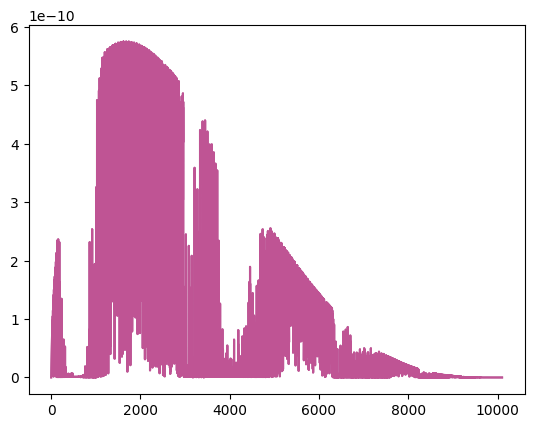

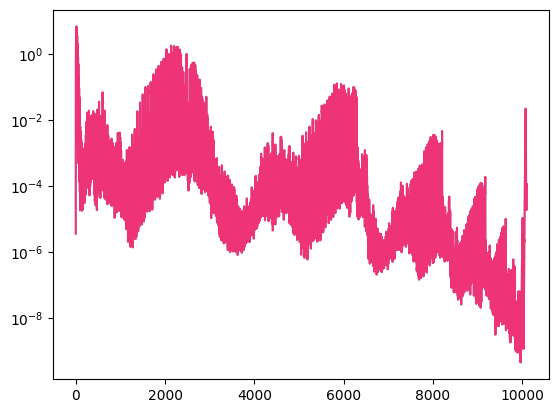

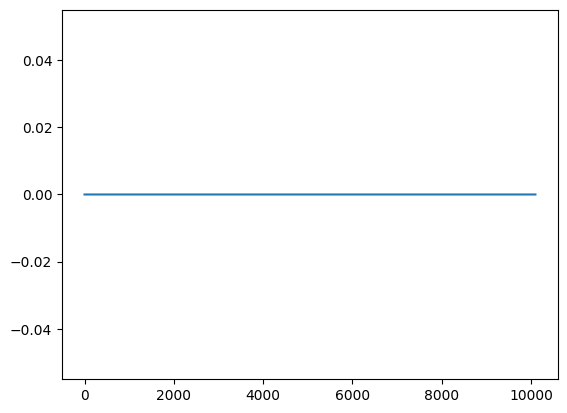

In [5]:
test_grid = np.arange(0, len(source[0]))
test_layer = 20
full_color = "#EE3377"
eff_color = "#33BBEE88"

test_source = eta[test_layer] * density[test_layer] / (chi[test_layer] * ac.c.cgs)
test_source =  test_source.to(u.J / (u.sr * u.m**2), equivalencies=u.spectral())
print(test_source)
plt.plot(test_grid, source[test_layer], zorder=1, color=full_color)
plt.plot(test_grid, eff_source[test_layer], zorder=2, color=eff_color)
plt.plot(test_grid, test_source, zorder=2, color="#EE337788")
# plt.plot(test_grid, source[test_layer] - eff_source[test_layer], zorder=1)
plt.show()

plt.plot(test_grid, chi[test_layer], zorder=2, label="Chi", color=full_color)
plt.plot(test_grid, eff_chi[test_layer], zorder=1, label="effective chi", color=eff_color)
# plt.plot(test_grid, chi[test_layer] - eff_chi[test_layer], zorder=1, label="Chi")
plt.yscale("log")
plt.show()

# plt.plot(test_grid, tau_mu[test_layer, 0], zorder=2, label="tau/mu", color=full_color)
# plt.plot(test_grid, eff_tau_mu[test_layer, 0], zorder=1, label="effective tau/mu", color=eff_color)
plt.plot(test_grid, tau_mu[test_layer, 0] - eff_tau_mu[test_layer, 0], zorder=1, label="effective tau/mu")
# plt.yscale("log")
plt.show()

In [13]:
np.logspace(np.log10(1e-9), np.log10(1e3), 37)

array([1.00000000e-09, 2.15443469e-09, 4.64158883e-09, 1.00000000e-08,
       2.15443469e-08, 4.64158883e-08, 1.00000000e-07, 2.15443469e-07,
       4.64158883e-07, 1.00000000e-06, 2.15443469e-06, 4.64158883e-06,
       1.00000000e-05, 2.15443469e-05, 4.64158883e-05, 1.00000000e-04,
       2.15443469e-04, 4.64158883e-04, 1.00000000e-03, 2.15443469e-03,
       4.64158883e-03, 1.00000000e-02, 2.15443469e-02, 4.64158883e-02,
       1.00000000e-01, 2.15443469e-01, 4.64158883e-01, 1.00000000e+00,
       2.15443469e+00, 4.64158883e+00, 1.00000000e+01, 2.15443469e+01,
       4.64158883e+01, 1.00000000e+02, 2.15443469e+02, 4.64158883e+02,
       1.00000000e+03])

In [5]:
l27_pop_old = np.array([0.2551314661339794, 0.18950662925750592, 0.1528941297612258, 0.1382222665583643, 0.13090166179957768, 0.08600686621195654, 0.028058963140782357, 0.014860061726656031, 0.003099776754239018, 0.0009956826358893981, 0.0003224960168330585])
l27_pop_new = np.array([0.2373323879665292, 0.18707673332963506, 0.1574452734159546, 0.1433528512754117, 0.12567837484092242, 0.09266560850904325, 0.03848086175520964, 0.01281292079815488, 0.003531149848137142, 0.0012104519719962777, 0.0004133862860820266])

max((l27_pop_new - l27_pop_old) / l27_pop_old)

np.float64(0.37142850083720863)

S' =  0.16281740350971155
max(|S|) =  10.503438284928212
abs(S) =  [ 0.23277153  0.72228076  1.02127034  0.37803735 10.50343828  1.62817404]
abs(S)/max(|S|) =  [0.02216146 0.06876613 0.097232   0.03599177 1.         0.15501343]
[  0.23277153  -0.72228076   1.02127034   0.37803735 -10.50343828
   1.62817404]
[0.23277153 0.15162108 1.02127034 0.37803735 0.         1.62817404]
[2.32771529e-01 7.90711899e-02 1.02127034e+00 3.78037354e-01
 4.46802440e-06 1.62817404e+00]


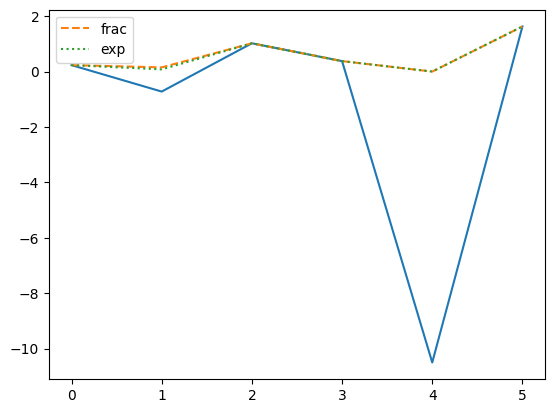

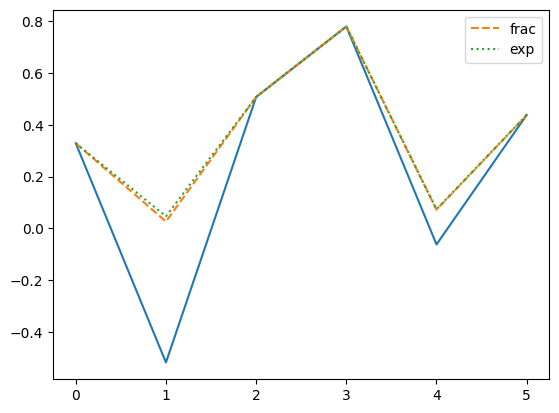

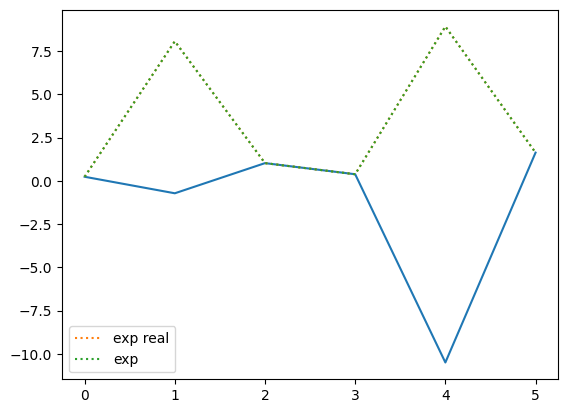

In [65]:
eta = np.random.rand(5, 6)
chi = np.random.rand(5, 6)
chi[0, 3] *= -1
chi[1, 1] *= -1
chi[1, 4] *= -1
chi[2, 3] *= -1
chi[3, 0] *= -1
chi[3, 1] *= -1
chi[3, 3] *= -1
chi[4, 3] *= -1

source_func = eta / chi

test_layer = 3

s_prime = 0.1 * np.max(source_func, axis=1)
max_abs_s = np.max(abs(source_func), axis=1)
eff1_source_func = np.where(source_func < 0, s_prime[:, None] * (1 - abs(source_func) / max_abs_s[:, None]), source_func)
eff2_source_func = np.where(source_func < 0, s_prime[:, None] * np.exp(-abs(source_func)), source_func)

plot_layer = 1
plt.plot(np.arange(source_func.shape[1]), source_func[plot_layer])

print("S' = ", s_prime[plot_layer])
print("max(|S|) = ", max_abs_s[plot_layer])
print("abs(S) = ", abs(source_func[plot_layer]))
print("abs(S)/max(|S|) = ", abs(source_func[plot_layer]) / max_abs_s[plot_layer])

print(source_func[plot_layer])
print(eff1_source_func[plot_layer])
print(eff2_source_func[plot_layer])
plt.plot(np.arange(source_func.shape[1]), eff1_source_func[plot_layer], linestyle="--", label="frac")
plt.plot(np.arange(source_func.shape[1]), eff2_source_func[plot_layer], linestyle=":", label="exp")
plt.legend()
plt.show()

chi_prime = 0.1 * np.max(chi, axis=1)
max_abs_chi = np.max(abs(chi), axis=1)
eff1_chi = np.where(chi < 0, chi_prime[:, None] * (1 - abs(chi) / max_abs_chi[:, None]), chi)
eff2_chi = np.where(chi < 0, chi_prime[:, None] * np.exp(-abs(chi)), chi)

plt.plot(np.arange(chi.shape[1]), chi[plot_layer])
plt.plot(np.arange(chi.shape[1]), eff1_chi[plot_layer], linestyle="--", label="frac")
plt.plot(np.arange(chi.shape[1]), eff2_chi[plot_layer], linestyle=":", label="exp")
plt.legend()
plt.show()


# eff1_source_func = np.where(source_func < 0, eta / eff1_chi, source_func)
# eff2_source_func = np.where(source_func < 0, s_prime[:, None] * np.exp(abs(source_func)), source_func)
eff2_source_func = np.where(source_func < 0, eta / eff2_chi, source_func)

plt.plot(np.arange(chi.shape[1]), eta[plot_layer] / chi[plot_layer])
# plt.plot(np.arange(chi.shape[1]), eta[plot_layer] / eff1_chi[plot_layer], linestyle="--", label="frac real")
# plt.plot(np.arange(source_func.shape[1]), eff1_source_func[plot_layer], linestyle="--", label="frac")
plt.plot(np.arange(chi.shape[1]), eta[plot_layer] / eff2_chi[plot_layer], linestyle=":", label="exp real")
plt.plot(np.arange(source_func.shape[1]), eff2_source_func[plot_layer], linestyle=":", label="exp")
plt.legend()
plt.show()

In [4]:
import re
from collections import defaultdict

def parse_nlte_populations(file_path: str) -> np.ndarray:
    """
    Parses an NLTE population output file and stores the data in a NumPy array.

    The function assumes the file format is:
    [L<iteration>] n['<species>' <state>] = <population_value>

    Args:
        file_path: The path to the input text file.

    Returns:
        A 2D NumPy array where the first dimension is the iteration number
        and the second dimension is the state index.
    """
    # Use a dictionary to temporarily store data, as iterations might not be
    # perfectly ordered or contiguous in the file.
    # defaultdict is useful here to handle new keys automatically.
    iterations_data = defaultdict(list)

    # Regex to capture the iteration number and the population value
    # It looks for:
    # \d+       : one or more digits (for the iteration number)
    # \s=\s     : an equals sign surrounded by spaces
    # [-+]?\d*\.\d+e?[-+]?\d* : a floating point number, including scientific notation
    line_pattern = re.compile(r"\[L(\d+)\] n\['X2Pi' \d+\] = ([-+]?\d*\.\d+e?[-+]?\d*)")

    try:
        with open(file_path, 'r') as f:
            for line in f:
                match = line_pattern.search(line)
                if match:
                    iteration = int(match.group(1))
                    population = float(match.group(2))
                    iterations_data[iteration].append(population)

    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return np.array([])
    except Exception as e:
        print(f"An error occurred: {e}")
        return np.array([])

    if not iterations_data:
        print("No data was parsed. Check the file format.")
        return np.array([])

    # Determine the dimensions for the final NumPy array
    # The number of iterations will be the number of unique keys (e.g., L20, L21...)
    # We assume the number of states is consistent across all iterations.
    num_iterations = len(iterations_data)

    # Find the number of states from the first complete iteration block
    first_iteration_key = sorted(iterations_data.keys())[0]
    num_states = len(iterations_data[first_iteration_key])

    # Create the final NumPy array
    # We will sort the iterations by their number to ensure correct order
    pop_matrix = np.zeros((num_iterations, num_states))

    # We iterate through the sorted keys of the dictionary to build the array
    # in the correct order.
    for idx, iteration_num in enumerate(sorted(iterations_data.keys())):
        populations = iterations_data[iteration_num]
        if len(populations) == num_states:
            pop_matrix[idx, :] = populations
        else:
            print(f"Warning: Iteration {iteration_num} has an inconsistent number of states. Padding with zeros.")
            # Handle cases where an iteration might be incomplete
            padded_pops = np.zeros(num_states)
            padded_pops[:len(populations)] = populations
            pop_matrix[idx, :] = padded_pops


    return pop_matrix

# --- How to use the script ---
file_to_parse = "/mnt/c/PhD/NLTE/Models/KELT-20b/1xOH_bL20/test4_nlte.log"
pops = parse_nlte_populations(file_to_parse)
print(pops.shape)
pop_matrix = np.zeros((301, 60, 11))
for iter_idx in range(0, 301):
    pop_matrix[iter_idx, :, :] = pops[:, iter_idx*11:(iter_idx + 1)*11]

(60, 3311)


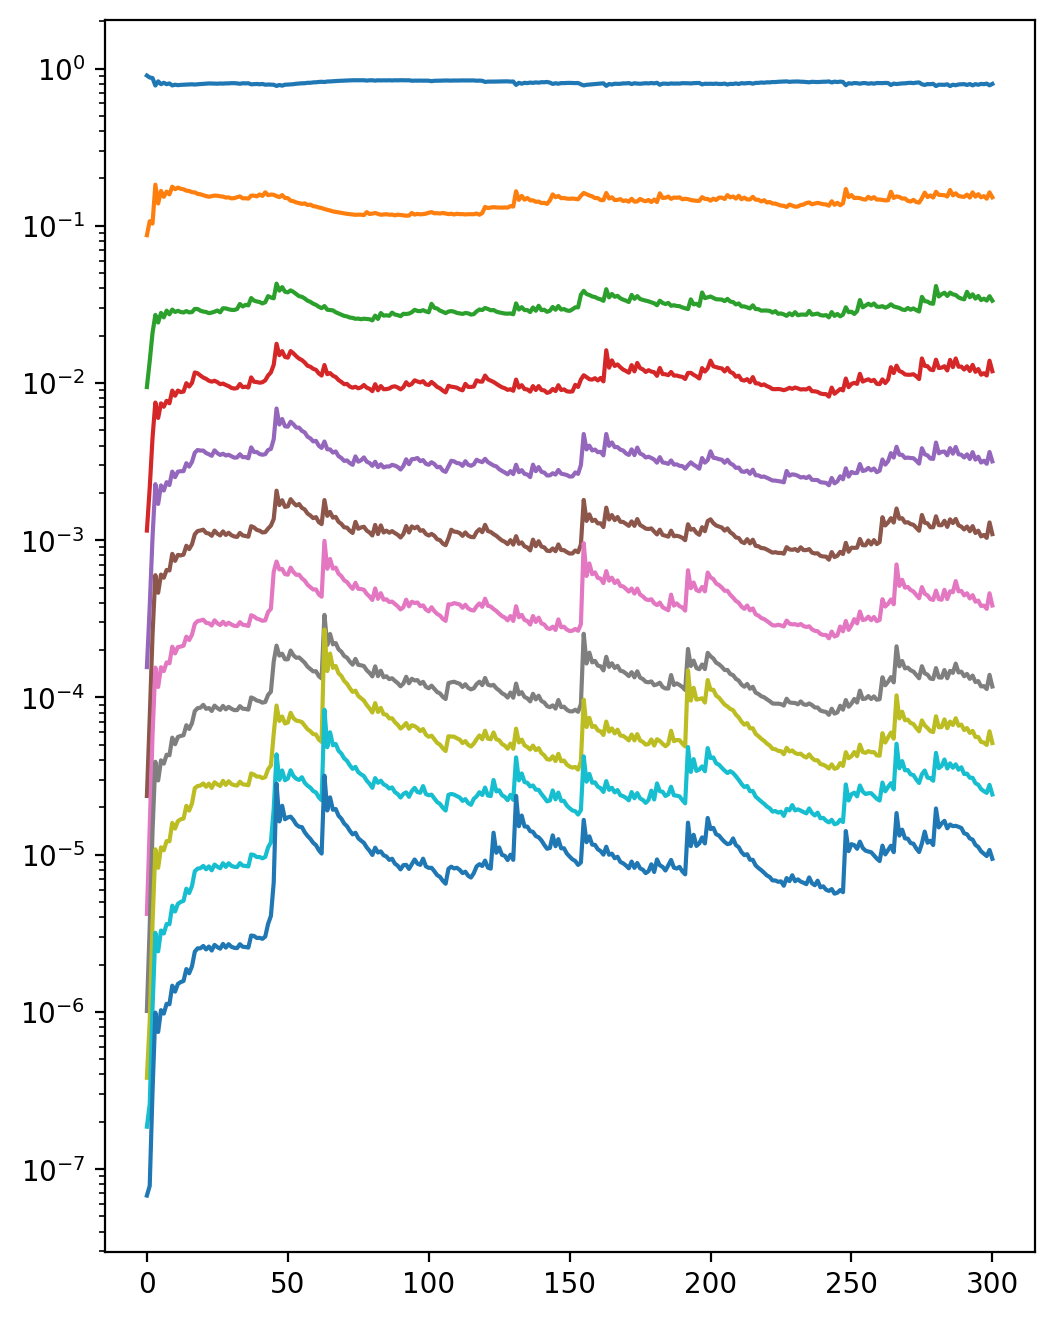

In [27]:
plot_layer = 16

plt.figure(figsize=(6, 8), dpi=200)
plt.plot(np.arange(pop_matrix.shape[0]), pop_matrix[:, plot_layer])
# plt.ylim(bottom=1e-2)
plt.yscale("log")
plt.show()

In [136]:
pop_matrix_old = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/1xOH_bL20/KELT-20b_cont_boundaryL20_pop_matrix.pickle", "rb"))
delta_pop_old = abs(pop_matrix_old[1:, :, :11] - pop_matrix_old[:-1, :, :11]) / pop_matrix_old[:-1, :, :11]

pop_matrix = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/1xOH_bL20/outputs_new6/KELT-20b_cont_boundaryL20_pop_matrix.pickle", "rb"))
delta_pop = abs(pop_matrix[1:, :, :11] - pop_matrix[:-1, :, :11]) / pop_matrix[:-1, :, :11]

print(f"Number of iterations = {pop_matrix.shape[0]}")
print(f"current worst delta @ L{np.argmax(delta_pop[-1, :, :].max(axis=1))} = {delta_pop[-1].max()}")

# for layer_idx in range(20, 80):
#     plt.figure(figsize=(6, 6), dpi=200)
#     plt.plot(np.arange(delta_pop.shape[0]), delta_pop[:, layer_idx, :])
#     plt.xlim(left=0, right=delta_pop.shape[0] - 1)
#     plt.yscale("log")
#     plt.text(0.9, 0.9, f"L{layer_idx}", ha="center", va="center", transform=plt.gca().transAxes, fontsize=label_fontsize, fontweight="bold")
#     plt.ylabel("Relative change", fontsize=label_fontsize)
#     plt.xlabel("Iteration", fontsize=label_fontsize)
#     plt.show()

Number of iterations = 14
current worst delta @ L36 = 0.04441268575685864


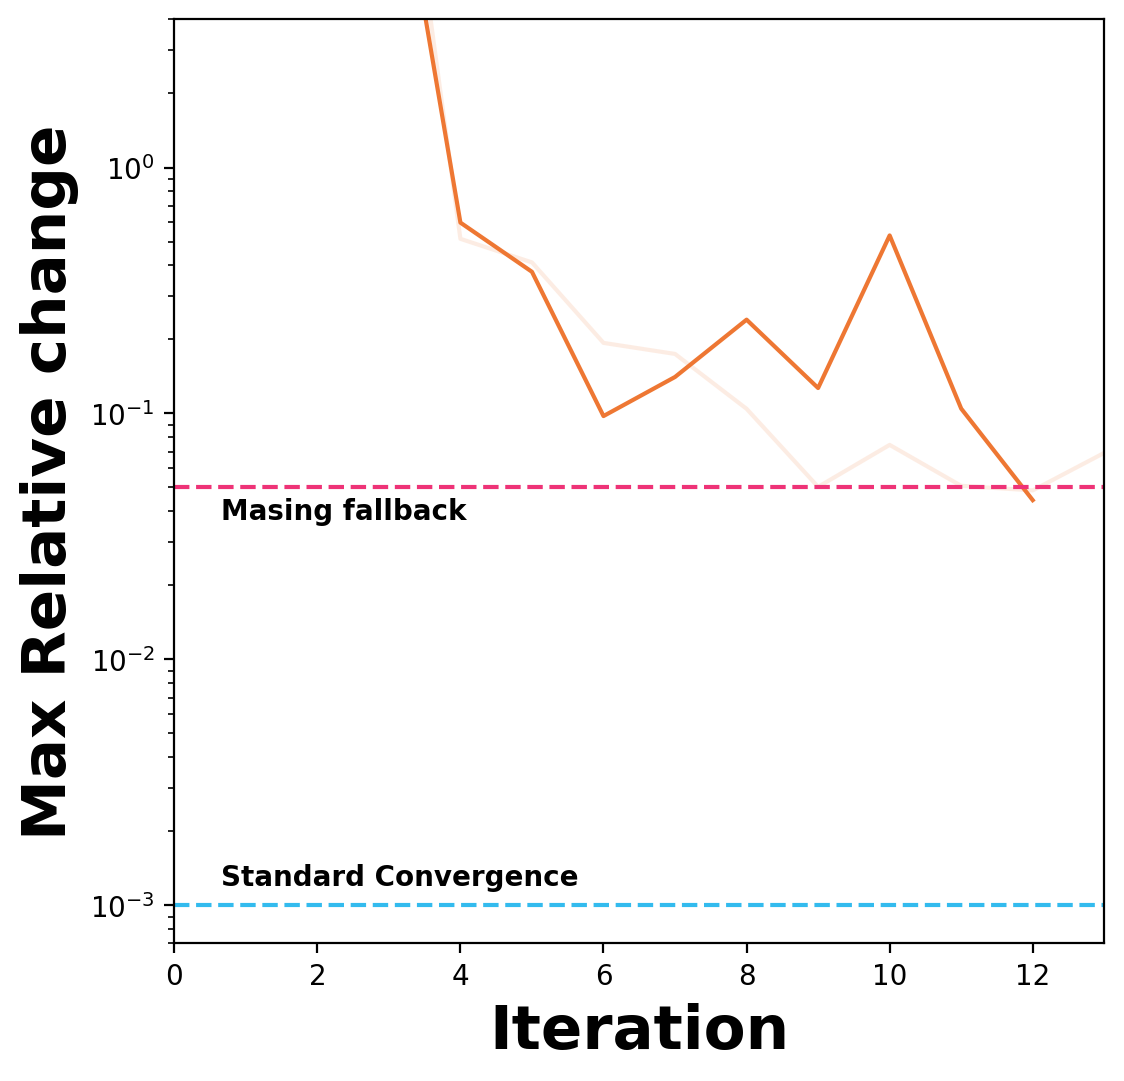

In [139]:
plt.figure(figsize=(6, 6), dpi=200)
plt.plot(np.arange(delta_pop_old.shape[0]), delta_pop_old[:, :, :].max(axis=(1, 2)), color="#EE773322")
plt.plot(np.arange(delta_pop.shape[0]), delta_pop[:, :, :].max(axis=(1, 2)), color="#EE7733")
text_x = delta_pop.shape[0] / 20
plt.hlines(xmin=0, xmax=delta_pop.shape[0], y=0.05, color="#EE3377", linestyle="--")
plt.text(text_x, 0.04, f"Masing fallback", ha="left", va="center", fontsize=10, fontweight="bold")
plt.hlines(xmin=0, xmax=delta_pop.shape[0], y=0.001, color="#33BBEE", linestyle="--")
plt.text(text_x, 0.0013, f"Standard Convergence", ha="left", va="center", fontsize=10, fontweight="bold")
plt.xlim(left=0, right=delta_pop.shape[0])
plt.ylim(bottom=7e-4, top=4)
plt.yscale("log")
plt.ylabel("Max Relative change", fontsize=label_fontsize, fontweight="bold")
plt.xlabel("Iteration", fontsize=label_fontsize, fontweight="bold")
plt.show()

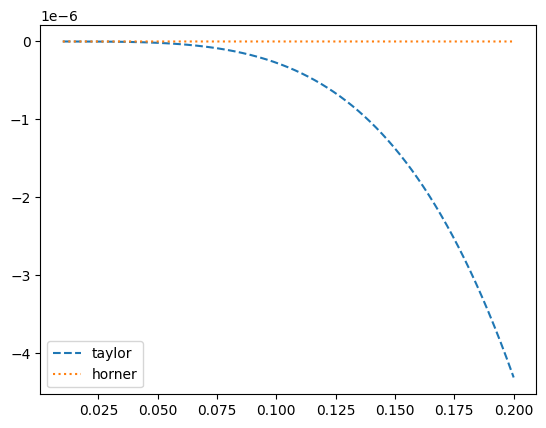

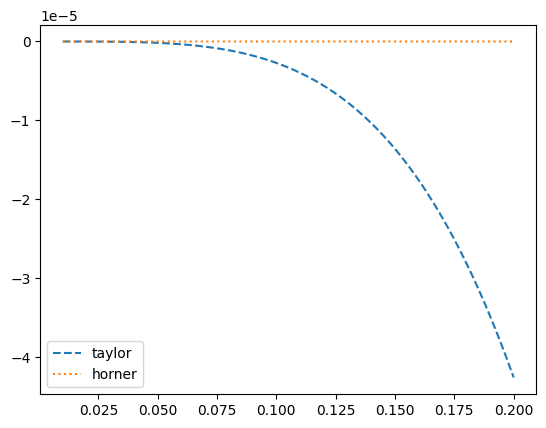

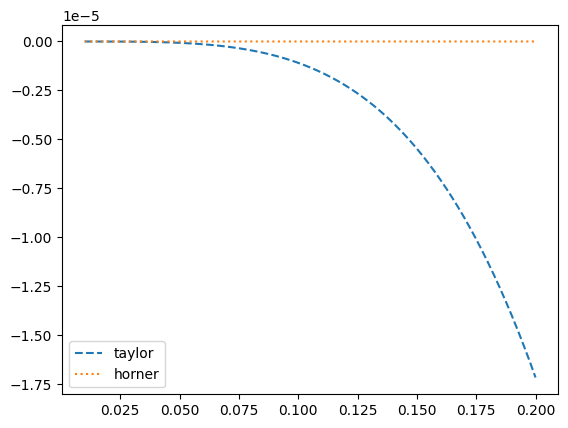

In [159]:
delta_tau = np.linspace(0.01, 0.2, 10000)
delta_tau_sq = delta_tau ** 2
delta_tau_cube = delta_tau ** 3
exp_neg_delta_tau = np.exp(-delta_tau)
alpha = (2 + delta_tau_sq - 2 * delta_tau - 2 * exp_neg_delta_tau) / delta_tau_sq
alpha_taylor = (delta_tau / 3) - (delta_tau_sq / 12) + (delta_tau_cube / 60)
alpha_horner = (delta_tau * (delta_tau * (delta_tau * (delta_tau * (delta_tau * (delta_tau * ((10 - delta_tau)* delta_tau - 90) + 720) - 5040) + 30240) - 151200) + 604800))/1814400
# plt.plot(delta_tau, alpha, label="alpha")
# plt.plot(delta_tau, alpha_taylor, label="taylor", linestyle="--")
# plt.plot(delta_tau, alpha_horner, label="horner", linestyle=":")
plt.plot(delta_tau, alpha - alpha_taylor, label="taylor", linestyle="--")
plt.plot(delta_tau, alpha - alpha_horner, label="horner", linestyle=":")
plt.legend()
plt.show()
beta = (2 - (2 + 2 * delta_tau + delta_tau_sq) * exp_neg_delta_tau) / delta_tau_sq
beta_taylor = (delta_tau / 3) - (delta_tau_sq / 4) + (delta_tau_cube / 10)
beta_horner = (delta_tau * (delta_tau * (delta_tau * (delta_tau * (delta_tau * (delta_tau * ((140 - 18 * delta_tau) * delta_tau - 945) + 5400) - 25200) + 90720) - 226800) + 302400))/907200
# plt.plot(delta_tau, beta, label="alpha")
# plt.plot(delta_tau, beta_taylor, label="taylor", linestyle="--")
# plt.plot(delta_tau, beta_horner, label="horner", linestyle=":")
plt.plot(delta_tau, beta - beta_taylor, label="taylor", linestyle="--")
plt.plot(delta_tau, beta - beta_horner, label="horner", linestyle=":")
plt.legend()
plt.show()
gamma = (2 * delta_tau - 4 + (2 * delta_tau + 4) * exp_neg_delta_tau) / delta_tau_sq
gamma_taylor = (delta_tau / 3) - (delta_tau_sq / 6) + (delta_tau_cube / 20)
gamma_horner = (delta_tau * (delta_tau * (delta_tau * (delta_tau * (delta_tau * (delta_tau * ((35 - 4 * delta_tau) * delta_tau - 270) + 1800) - 10080) + 45360) - 151200) + 302400))/907200
# plt.plot(delta_tau, gamma, label="alpha")
# plt.plot(delta_tau, gamma_taylor, label="taylor", linestyle="--")
# plt.plot(delta_tau, gamma_horner, label="horner", linestyle=":")
plt.plot(delta_tau, gamma - gamma_taylor, label="taylor", linestyle="--")
plt.plot(delta_tau, gamma - gamma_horner, label="horner", linestyle=":")
plt.legend()
plt.show()

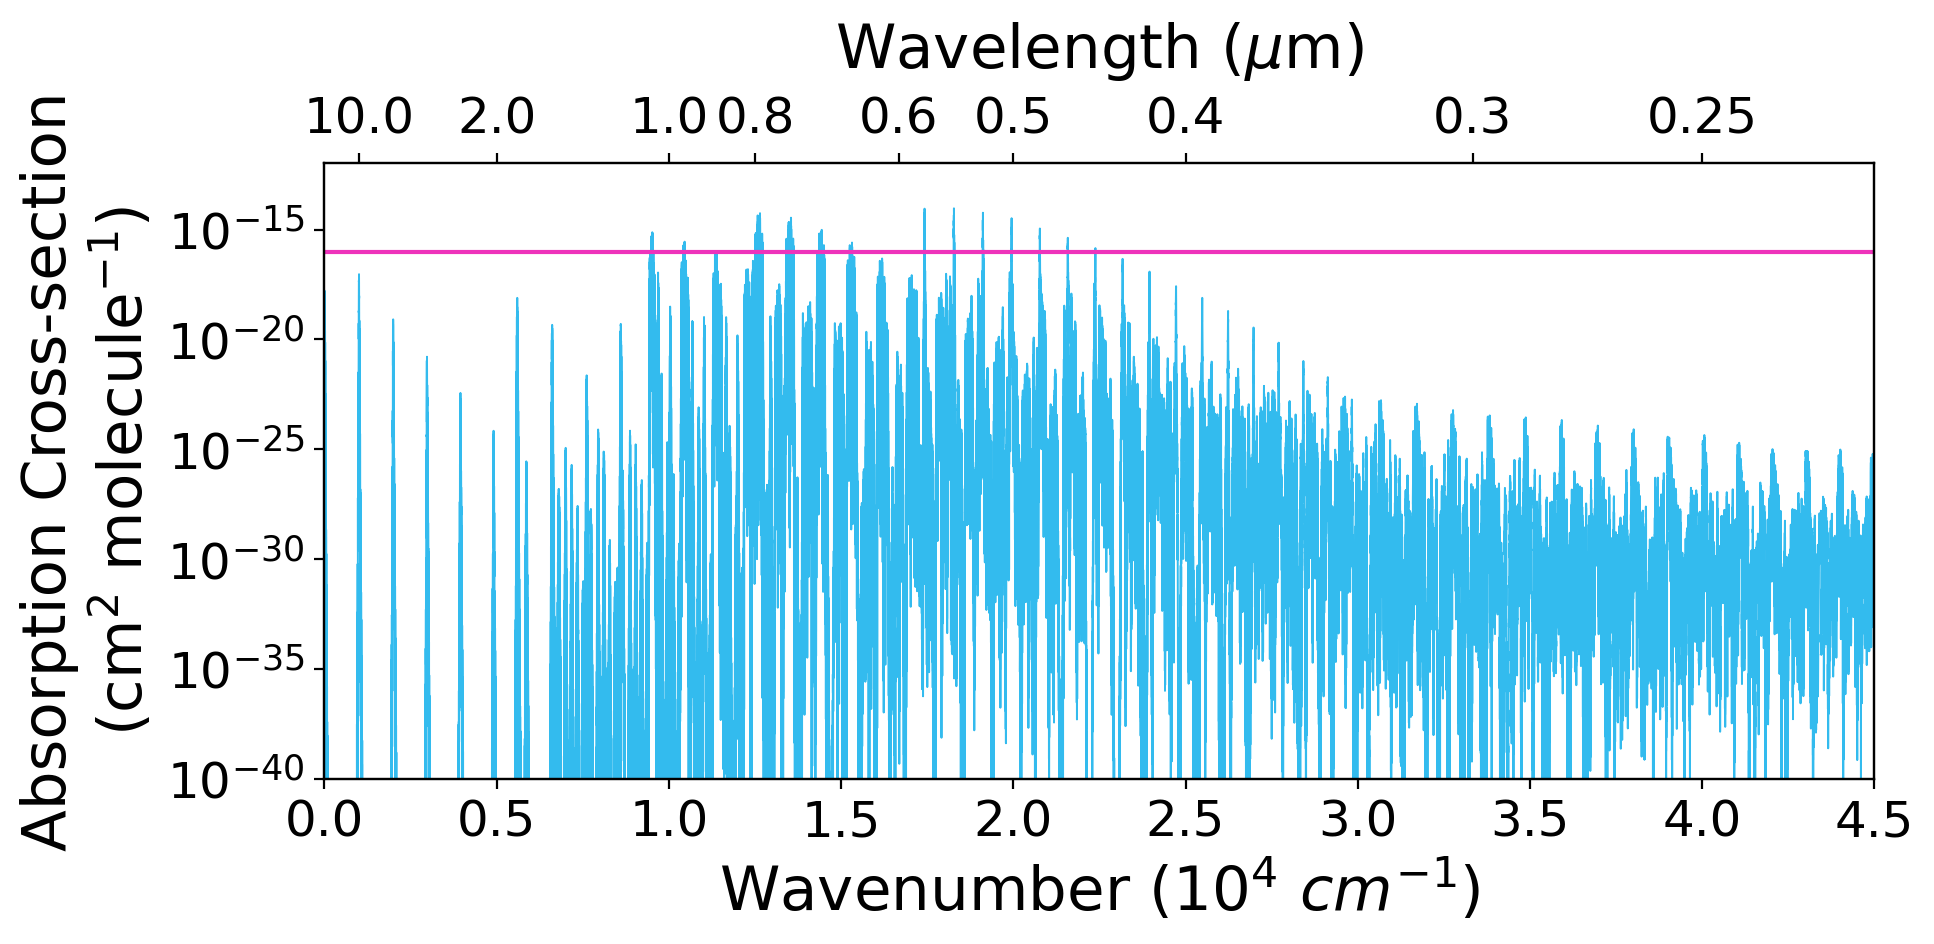

In [62]:
xsec = np.loadtxt(r"/mnt/c/PhD/VO/ExoCross/51V-16O__HyVO__5K_Helgi.xsec")
plt.figure(figsize=(10, 4), dpi=200)
plt.plot(xsec[:, 0] / 1e4, xsec[:, 1], linewidth=0.7, color="#33BBEE", zorder=1)
# strong_xsec = xsec[:, 1]
# strong_xsec[strong_xsec < 1e-16] = np.nan
# plt.scatter(xsec[:, 0] / 1e4, strong_xsec, linewidth=0.7, color="#EE33BB", zorder=2, s=10, marker="|")
plt.hlines(xmin=xsec[0, 0] / 1e4, xmax=xsec[-1, 0] / 1e4, y=1e-16, color="#EE33BB")
plt.yscale("log")
plt.ylim(bottom=1e-40)
plt.xlim(left=xsec[0, 0] / 1e4, right=xsec[-1, 0] / 1e4)
# plt.xlim(left=1.435, right=1.45)
plt.xlabel("Wavenumber (10$^{4}$ $cm^{-1}$)", fontsize=label_fontsize)
plt.ylabel("Absorption Cross-section\n(cm$^{2}$ molecule$^{-1}$)", fontsize=label_fontsize)
plt.tick_params(labelsize=tick_fontsize)

ax_wl = plt.gca().twiny()
ax_wl.set_xlim(left=0, right=xsec[-1, 0] / 1e4)
wl_tick_vals = [10.0, 2.0, 1.0, 0.8, 0.6, 0.5, 0.4, 0.3, 0.25]
new_tick_locations = [1e4 / x / 10000 for x in wl_tick_vals]
ax_wl.set_xlabel("Wavelength ($\\mu$m)", fontsize=label_fontsize, labelpad=10)
ax_wl.set_xticks(ticks=new_tick_locations, labels=wl_tick_vals, fontsize=tick_fontsize)

plt.savefig(r"/mnt/c/PhD/VO/ExoCross/51V-16O__HyVO__5K_Helgi.png", dpi=200, bbox_inches="tight")
plt.show()

In [41]:
import re
from collections import defaultdict

def parse_nlte_populations(file_path: str) -> np.ndarray:
    """
    Parses an NLTE population output file and stores the data in a NumPy array.

    The function assumes the file format is:
    [L<iteration>] n['<species>' <state>] = <population_value>

    Args:
        file_path: The path to the input text file.

    Returns:
        A 2D NumPy array where the first dimension is the iteration number
        and the second dimension is the state index.
    """
    # Use a dictionary to temporarily store data, as iterations might not be
    # perfectly ordered or contiguous in the file.
    # defaultdict is useful here to handle new keys automatically.
    iterations_data = defaultdict(list)

    # Regex to capture the iteration number and the population value
    # It looks for:
    # \d+       : one or more digits (for the iteration number)
    # \s=\s     : an equals sign surrounded by spaces
    # [-+]?\d*\.\d+e?[-+]?\d* : a floating point number, including scientific notation
    line_pattern = re.compile(r"\[L(\d+)\] n\['X2Pi' \d+\] = ([-+]?\d+\.?\d*e?[\-\+]?\d*)")

    try:
        with open(file_path, 'r') as f:
            for line in f:
                match = line_pattern.search(line)
                if match:
                    iteration = int(match.group(1))
                    population = float(match.group(2))
                    iterations_data[iteration].append(population)

    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return np.array([])
    except Exception as e:
        print(f"An error occurred: {e}")
        return np.array([])

    if not iterations_data:
        print("No data was parsed. Check the file format.")
        return np.array([])

    # Determine the dimensions for the final NumPy array
    # The number of iterations will be the number of unique keys (e.g., L20, L21...)
    # We assume the number of states is consistent across all iterations.
    num_iterations = len(iterations_data)

    # Find the number of states from the first complete iteration block
    first_iteration_key = sorted(iterations_data.keys())[0]
    num_states = len(iterations_data[first_iteration_key])

    # Create the final NumPy array
    # We will sort the iterations by their number to ensure correct order
    pop_matrix = np.zeros((num_iterations, num_states))

    # We iterate through the sorted keys of the dictionary to build the array
    # in the correct order.
    for idx, iteration_num in enumerate(sorted(iterations_data.keys())):
        populations = iterations_data[iteration_num]
        if len(populations) == num_states:
            pop_matrix[idx, :] = populations
        else:
            print(f"Warning: Iteration {iteration_num} has an inconsistent number of states. Padding with zeros.")
            # Handle cases where an iteration might be incomplete
            padded_pops = np.zeros(num_states)
            padded_pops[:len(populations)] = populations
            pop_matrix[idx, :] = padded_pops


    return pop_matrix

# --- How to use the script ---
file_to_parse = "/mnt/c/PhD/NLTE/Models/KELT-20b/1000xOH_bL20/test_oscillation2.log"
pops = parse_nlte_populations(file_to_parse)
print(pops.shape)
n_iter = 9
pop_matrix = np.zeros((n_iter, 60, 11))
for iter_idx in range(0, n_iter):
    pop_matrix[iter_idx, :, :] = pops[:, iter_idx*11:(iter_idx + 1)*11]

(60, 99)


In [11]:
pop_matrix = pickle.load(open(r"/mnt/c/PhD/NLTE/Models/KELT-20b/1000xOH_bL20/outputs/KELT-20b_cont_boundaryL20_pop_matrix.pickle", "rb"))
check_iter = 6
check_changes = np.where(
    (pop_matrix[-check_iter-1:-1, :, :] == 0) & (pop_matrix[-check_iter:, :, :] == 0),
    0,
    abs(pop_matrix[-check_iter:, :, :] - pop_matrix[-check_iter-1:-1, :, :]) / pop_matrix[-check_iter-1:-1, :, :]
).max(axis=(1, 2))
# print(temp_changes.shape)
# print(temp_changes)
# check_changes = (temp_changes).max(axis=(1, 2))
# check_changes = max_changes[-check_iter:]
print(check_changes)
change_dif = np.diff(check_changes)
oscillating = change_dif[:-1] * change_dif[1:]
oscillating = oscillating < 0
print(oscillating, sum(oscillating))
if sum(oscillating) >= 3:
    print("yes")
do_damping = sum(oscillating) >= 3
print(do_damping)

[1.18252494 1.14593742 2.0844932  0.97884891 1.94647151 0.94387336]
[ True  True  True  True] 4
yes
True


/tmp/ipykernel_611020/1942742197.py:6: RuntimeWarning: invalid value encountered in divide
  abs(pop_matrix[-check_iter:, :, :] - pop_matrix[-check_iter-1:-1, :, :]) / pop_matrix[-check_iter-1:-1, :, :]


In [40]:
(abs(pop_matrix[1:, :, :] - pop_matrix[:-1, :, :]) / pop_matrix[:-1, :, :]).max(axis=(1, 2))

/tmp/ipykernel_318864/3528381193.py:1: RuntimeWarning: overflow encountered in divide
  (abs(pop_matrix[1:, :, :] - pop_matrix[:-1, :, :]) / pop_matrix[:-1, :, :]).max(axis=(1, 2))


array([       inf, 3.68527405, 2.44024223, 0.70442427, 1.92595159,
       0.80601814, 2.24044094, 0.74889362])